# Goal
Given an author location, identify the country it is in.

## Strategy
0. Combine several sources of data by keeping a dictionary with key=alpha_2 and value=all the info
1. Search for country names
2. Search for US state abbreviations
3. Search for subdivision names
4. Filter out number and emojis and rule out entries that are too short

# Country Info

1. ***pycountry*** https://pypi.org/project/pycountry/, 
https://github.com/flyingcircusio/pycountry
- Relevant attributes: name, official name, common name, flag, alpha_2, subdivisions
2. ***countryinfo*** https://pypi.org/project/countryinfo/#api-usage
- Relevant attributes: name, altSpellings, capital, nativeName, provinces, alpha_2
3. ***OSM data*** retrieved using Overpass API
- Tags used: place="province", "region", "district", "county", "municipality", "city"

In [ ]:
# !pip3 install pycountry
# !pip3 install countryinfo
# !pip3 install us

In [46]:
import time
import pandas as pd
import numpy as np
import re
import json
import functools
import pycountry
from countryinfo import CountryInfo
DC_STATEHOOD=1 
import us

In [287]:
pd.options.display.max_rows = 500

## pycountry

In [2]:
# Get country names and flags from pycountry
pycountry_countries = list(pycountry.countries)
pycountry_dict = {c.alpha_2:dict() for c in pycountry_countries}
for c in pycountry_countries:
    c_code = c.alpha_2
    pycountry_dict[c_code]['name'] = c.name
    other_names = set()
    if 'common_name' in c._fields:
        other_names.add(c.common_name)
    if 'official_name' in c._fields:
        other_names.add(c.official_name)
    pycountry_dict[c_code]['other_names'] = other_names
    pycountry_dict[c_code]['flag'] = c.flag if 'flag' in c._fields else None

In [3]:
# Get subdivisions from pycountry
subdiv = list(pycountry.subdivisions)
subdiv_dict = dict()
for s in subdiv:
    c_code = s.country_code
    if c_code not in subdiv_dict:
        subdiv_dict[c_code] = set()
    subdiv_dict[c_code].add(s.name)
for c_code, sub in subdiv_dict.items():
    pycountry_dict[c_code]['subdivisions'] = sub
for c_code in set(pycountry_dict).difference(set(subdiv_dict)): # those without subdivisions field
    pycountry_dict[c_code]['subdivisions'] = set()

In [ ]:
# len(subdiv_dict), sum([len(p) for p in subdiv_dict.values()])
# pycountry_dict['SG']

## countryinfo

In [6]:
# Get data from countryinfo
countryinfo_all = CountryInfo().all()
countryinfo_dict = dict()
params_to_get = ['name', 'altSpellings', 'capital', 'nativeName', 'provinces']
for c in countryinfo_all:
    alpha2 = countryinfo_all[c]['ISO']['alpha2']
    params = [p for p in params_to_get if p in countryinfo_all[c]]
    countryinfo_dict[alpha2] = {param: countryinfo_all[c][param] for param in params}
    if 'provinces' in countryinfo_dict[alpha2]:
        countryinfo_dict[alpha2]['provinces'] = set(countryinfo_dict[alpha2]['provinces'])
    else:
        countryinfo_dict[alpha2]['provinces'] = set()
for c_code in countryinfo_dict: # handle missing entries
    if 'altSpellings' in countryinfo_dict[c_code]:
        temp = countryinfo_dict[c_code]['altSpellings'][1:] # the first entry is the two-letter code
        countryinfo_dict[c_code]['altSpellings'] = set(temp) 
    else:
        countryinfo_dict[c_code]['altSpellings'] = set()
    countryinfo_dict[c_code]['altSpellings'] = countryinfo_dict[c_code]['altSpellings'].difference([''])
    countryinfo_dict[c_code]['provinces'] = countryinfo_dict[c_code]['provinces'].difference([''])
    if 'capital' not in countryinfo_dict[c_code]:
        countryinfo_dict[c_code]['capital'] = None 
    if countryinfo_dict[c_code]['capital'] =='':
        countryinfo_dict[c_code]['capital'] = None 

In [7]:
countryinfo_dict['SG']

{'name': 'Singapore',
 'altSpellings': {'Republik Singapura', 'Singapura', '新加坡共和国'},
 'capital': 'Singapore',
 'nativeName': 'Singapore',
 'provinces': {'Singapore'}}

### UK is problematic

In [8]:
[c['name'] for c in countryinfo_all.values() if c['ISO']['alpha2']==''], [c['name'] for c in countryinfo_all.values() if c['ISO']['alpha2']=='GB']

(['Scotland'], ['United Kingdom', 'Wales'])

In [9]:
uk_problems = [c for  c in countryinfo_all.values() if c['ISO']['alpha2']=='GB' or c['ISO']['alpha2']=='' ]

In [11]:
countryinfo_dict['GB'] = {'name': 'United Kingdom', 'altSpellings':{'UK', 'Great Britain'}, 'capital':'London', 
                          'native_name':'United Kingdom', 'provinces': functools.reduce(set.union, [set(t['provinces']) for t in uk_problems])}
# This is not accurate but whatever
countryinfo_dict['GB']['provinces'] |= {'England','Wales','Scotland','Northern Ireland'}
if '' in countryinfo_dict:
    del countryinfo_dict['']

In [12]:
# Problematic
countryinfo_dict['IS']['altSpellings'].remove('Island')

## OSM data

In [13]:
with open('osm_places.json', 'r') as f:
    s = f.readlines()
osm = [json.loads(p) for p in s]
osm = {list(country.keys())[0]:list(country.values())[0] for country in osm}
for k,v in osm.items():
    if v==[]:
        osm[k] = [set()]
osm = {k:functools.reduce(lambda x,y: set(x).union(y),v) for k,v in osm.items()}
osm = {k:set(v).difference([None]) for k,v in osm.items()}

In [14]:
osm['SG']

{'Singapore'}

# Consolidate three data sources

In [15]:
len(pycountry_dict.keys()), len(countryinfo_dict), len(osm.keys()), set(pycountry_dict) ==set(osm), set(countryinfo_dict).issubset(set(osm))

(249, 232, 249, True, True)

In [16]:
c_code = 'SG'
pycountry_dict[c_code], countryinfo_dict[c_code], osm[c_code]

({'name': 'Singapore',
  'other_names': {'Republic of Singapore'},
  'flag': '🇸🇬',
  'subdivisions': {'Central Singapore',
   'North East',
   'North West',
   'South East',
   'South West'}},
 {'name': 'Singapore',
  'altSpellings': {'Republik Singapura', 'Singapura', '新加坡共和国'},
  'capital': 'Singapore',
  'nativeName': 'Singapore',
  'provinces': {'Singapore'}},
 {'Singapore'})

In [17]:
# initialize
all_places = {c_code:{'name':set(), 'alt_names':set(), 'flag':None, 'capital':None, 'provinces':set(), 'subdivisions':set()} 
              for c_code in pycountry_dict}

In [18]:
# populate
for c_code in all_places:
    if c_code in pycountry_dict:
        all_places[c_code]['name'].add(pycountry_dict[c_code]['name'])
        all_places[c_code]['alt_names']     |= pycountry_dict[c_code]['other_names']
        all_places[c_code]['flag']          = pycountry_dict[c_code]['flag']
        all_places[c_code]['subdivisions'] |= pycountry_dict[c_code]['subdivisions']
    if c_code in countryinfo_dict:
        all_places[c_code]['name'].add(countryinfo_dict[c_code]['name'])
        all_places[c_code]['alt_names']     |= countryinfo_dict[c_code]['altSpellings']
        all_places[c_code]['capital']       = countryinfo_dict[c_code]['capital']
        all_places[c_code]['provinces']     = countryinfo_dict[c_code]['provinces']
    if c_code in osm:
        all_places[c_code]['subdivisions'] |= osm[c_code]

## US states abbreviations

In [128]:
us_states = us.states.STATES + [us.states.DC]
df_us_states = pd.DataFrame({'state_name': [s.name for s in us_states], 'state_abbr': [s.abbr for s in us_states]})
us_states_list = list(df_us_states.state_name)
us_states_list.sort(key=lambda x: len(x), reverse=True)
us_states_list.remove('Georgia')

# Load author location data

In [20]:
df_loc = pd.read_csv('author_locations_with_count_no_country.csv', index_col=0)
df_loc = df_loc.rename(columns={'location_original':'location'}) # forgot to change col name
df_loc = df_loc[~df_loc.location.isna()]
df_loc['country'] = np.nan

# Matching

In [21]:
# When doing matching, better to match longer strings first
def return_list_of_places_with_ccode_sorted_by_len(attr):
    temp = []
    for c_code in all_places:
        attr_list = list(all_places[c_code][attr])
        temp += [(c_code, p) for p in attr_list]
    temp = sorted(temp,  key=lambda x: len(x[1]), reverse=True)
    return temp

In [ ]:
# return_list_of_places_with_ccode_sorted_by_len('alt_names')

## 1. name

In [22]:
names = return_list_of_places_with_ccode_sorted_by_len('name')

In [188]:
# verbose = True
# starttime = time.time()
# s = starttime
# print(f'{len(names)} entries to check') if verbose else None
# for i, (c_code, name) in enumerate(names):
#     starttime = time.time()
#     print(f'#{i} Searching for {name} in {c_code}... ', end='') if verbose else None
#     temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
#     idx = temp[temp.location.str.contains(name, case=False)].index
#     df_loc.loc[idx, 'country']= c_code
#     print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//1/100}s') if verbose else None
# print(f'Took {int(time.time()-s)}s in total') if verbose else None

In [25]:
# len(df_loc[~df_loc.country.isna()]), len(df_loc)

(49306, 578733)

# 2. alt_names

In [26]:
alt_names = return_list_of_places_with_ccode_sorted_by_len('alt_names')

In [27]:
verbose = True
print(f'{len(alt_names)} entries to check') if verbose else None
starttime = time.time()
for i, (c_code, alt_name) in enumerate(alt_names):
    starttime = time.time()
    print(f'#{i} Searching for {alt_name} in {c_code}... ', end='') if verbose else None
    temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
    idx = temp[temp.location.str.contains(alt_name, case=False)].index
    df_loc.loc[idx, 'country']= c_code
    print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//1/100} s') if verbose else None
print(f'Took {int(time.time()-s)}s in total') if verbose else None    

526 entries to check
#0 Searching for Região Administrativa Especial de Macau da República Popular da China in MO... 0 matches found, took 0 s
#1 Searching for Macao Special Administrative Region of the People's Republic of China in MO... 0 matches found, took 0 s
#2 Searching for Collectivité territoriale de Saint-Pierre-et-Miquelon in PM... 0 matches found, took 0 s
#3 Searching for United Kingdom of Great Britain and Northern Ireland in GB... 0 matches found, took 0 s
#4 Searching for Hong Kong Special Administrative Region of China in HK... 0 matches found, took 0 s
#5 Searching for al-Jumhūriyyah al-ʾIslāmiyyah al-Mūrītāniyyah in MR... 0 matches found, took 0 s
#6 Searching for Macao Special Administrative Region of China in MO... 0 matches found, took 0 s
#7 Searching for Commonwealth of the Northern Mariana Islands in MP... 0 matches found, took 0 s
#8 Searching for South Georgia and the South Sandwich Islands in GS... 0 matches found, took 0 s
#9 Searching for Democratic Republ

#93 Searching for Հայաստանի Հանրապետություն in AM... 0 matches found, took 0 s
#94 Searching for République centrafricaine in CF... 0 matches found, took 0 s
#95 Searching for Zhōnghuá Rénmín Gònghéguó in CN... 0 matches found, took 0 s
#96 Searching for Republic of Côte d'Ivoire in CI... 0 matches found, took 0 s
#97 Searching for Republic of Guinea-Bissau in GW... 0 matches found, took 0 s
#98 Searching for República da Guiné-Bissau in GW... 0 matches found, took 0 s
#99 Searching for Jomhuri-ye Eslāmi-ye Irān in IR... 0 matches found, took 0 s
#100 Searching for Grand Duchy of Luxembourg in LU... 0 matches found, took 0 s
#101 Searching for Grand-Duché de Luxembourg in LU... 0 matches found, took 0 s
#102 Searching for Al-Mamlakah al-Maġribiyah in MA... 0 matches found, took 0 s
#103 Searching for Repoblikan'i Madagasikara in MG... 0 matches found, took 0 s
#104 Searching for Sint Maarten (Dutch part) in SX... 0 matches found, took 0 s
#105 Searching for République des Seychelles in

#199 Searching for Poblacht na hÉireann in IE... 0 matches found, took 0 s
#200 Searching for Jumhūriyyat al-‘Irāq in IQ... 0 matches found, took 0 s
#201 Searching for Республика Казахстан in KZ... 0 matches found, took 0 s
#202 Searching for Republic of Kiribati in KI... 0 matches found, took 0 s
#203 Searching for Republic of Maldives in MV... 0 matches found, took 0 s
#204 Searching for Република Македонија in MK... 1 matches found, took 0 s
#205 Searching for Repubblika ta' Malta in MT... 0 matches found, took 0 s
#206 Searching for República Portuguesa in PT... 0 matches found, took 0 s
#207 Searching for Republic of Paraguay in PY... 0 matches found, took 0 s
#208 Searching for Российская Федерация in RU... 3 matches found, took 0 s
#209 Searching for République du Rwanda in RW... 0 matches found, took 0 s
#210 Searching for Republic of Suriname in SR... 0 matches found, took 0 s
#211 Searching for Republic of Slovenia in SI... 0 matches found, took 0 s
#212 Searching for Konung

#310 Searching for Republic of Chile in CL... 0 matches found, took 0 s
#311 Searching for Congo-Brazzaville in CG... 0 matches found, took 0 s
#312 Searching for Union des Comores in KM... 0 matches found, took 0 s
#313 Searching for República de Cuba in CU... 0 matches found, took 0 s
#314 Searching for Taneẓroft Tutrimt in EH... 0 matches found, took 0 s
#315 Searching for Gabonese Republic in GA... 0 matches found, took 0 s
#316 Searching for Republic of Ghana in GH... 0 matches found, took 0 s
#317 Searching for Hellenic Republic in GR... 0 matches found, took 0 s
#318 Searching for Republic of Haiti in HT... 0 matches found, took 0 s
#319 Searching for Republic of India in IN... 0 matches found, took 0 s
#320 Searching for Republic of Kenya in KE... 0 matches found, took 0 s
#321 Searching for Republic of Korea in KR... 76 matches found, took 0 s
#322 Searching for Lebanese Republic in LB... 0 matches found, took 0 s
#323 Searching for Republica Moldova in MD... 0 matches found, 

#428 Searching for weSwatini in SZ... 0 matches found, took 0 s
#429 Searching for Venezuela in VE... 0 matches found, took 0 s
#430 Searching for Shqipëri in AL... 0 matches found, took 0 s
#431 Searching for Shqipnia in AL... 0 matches found, took 0 s
#432 Searching for Hayastan in AM... 0 matches found, took 0 s
#433 Searching for Belgique in BE... 111 matches found, took 0 s
#434 Searching for Bielaruś in BY... 0 matches found, took 0 s
#435 Searching for Svizzera in CH... 17 matches found, took 0 s
#436 Searching for Zhonghua in CN... 0 matches found, took 0 s
#437 Searching for Zhōngguó in CN... 0 matches found, took 0 s
#438 Searching for Zhongguo in CN... 0 matches found, took 0 s
#439 Searching for DR Congo in CD... 0 matches found, took 0 s
#440 Searching for Iritriyā in ER... 0 matches found, took 0 s
#441 Searching for ሃገረ ኤርትራ in ER... 0 matches found, took 0 s
#442 Searching for Færøerne in FO... 0 matches found, took 0 s
#443 Searching for Gwadloup in GP... 0 matches fou

In [28]:
# len(df_loc[~df_loc.country.isna()]), len(df_loc)

(70378, 578733)

# 3. capital

In [29]:
capitals = [(k,v['capital']) for k,v in all_places.items() if v['capital'] is not None]
capitals = sorted(capitals, key=lambda x: len(x[1]), reverse=True)

In [137]:
# verbose = True
# print(f'{len(capitals)} entries to check') if verbose else None
# starttime = time.time()
# for i, (c_code, cap) in enumerate(capitals):
#     starttime = time.time()
#     print(f'#{i} Searching for {cap} in {c_code}... ', end='') if verbose else None
#     temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
#     idx = temp[temp.location.str.contains(cap, case=False)].index
#     df_loc.loc[idx, 'country']= c_code
#     print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//100} s') if verbose else None

In [138]:
len(df_loc[~df_loc.country.isna()]), len(df_loc)

(87524, 578733)

In [142]:
# This is a problem
df_loc[df_loc.location.str.contains('Victoria')&(df_loc.country=='SC')]

,location,count,country
55,"Melbourne, Victoria",1880,SC
646,"Victoria, British Columbia",211,SC
1897,"Victoria, BC",66,SC
2319,Victoria,53,SC
3009,"Geelong, Victoria",39,SC
...,...,...,...
566199,Instagram Victoria_R_Maslin,1,SC
567830,"Belgrave, Victoria",1,SC
571255,"Eagle Point, Victoria",1,SC
575043,"SE Region, Victoria, AU.",1,SC


# 4. US states
Main reason is to avoid overlap with provinces (e.g. New York vs York)

In [151]:
# verbose = False
# print(f'{len(us_states_list)} entries to check') if verbose else None
# for s in us_states_list: # note that Georgia was removed
#     temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
#     idx = temp[temp.location.str.contains(s, case=False)].index
#     df_loc.loc[idx, 'country']= 'US'
#     print(f'{len(idx)} matches found') if verbose else None

In [158]:
# for s in df_us_states.state_abbr:
#     temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
#     idx = temp[temp.location.str.contains('(\W|^){s}\.?(\W|$)')].index
#     df_loc.loc[idx, 'country']= 'US'

In [174]:
# df_loc.loc[df_loc[df_loc.location.str.contains('NY')].index, 'country'] = 'US'

In [175]:
len(df_loc[~df_loc.country.isna()]), len(df_loc)

(117343, 578733)

# 5. provinces

In [177]:
# note that some of them are very short and hence we need to account for that when matching
provinces = return_list_of_places_with_ccode_sorted_by_len('provinces')
# parentheses
extra_provinces = []
temp = [p for p in provinces if '(' in p[1]]
for c_code, s in temp:
    l1, l2 = s.index('('), s.index(')')
    extra_provinces += [(c_code, re.sub('Province', '', s[:l1]).strip()), (c_code, re.sub('Province', '', s[l1+1:l2]).strip())]
# City( of)
extra_provinces2 = [(p[0], re.sub('City( of)?', '', p[1]).strip()) for p in provinces if bool(re.search('City', p[1]))]
provinces = provinces + extra_provinces + extra_provinces2
provinces = [p for p in provinces if p[1]!='city'] # this messes things up
provinces = sorted(list(set(provinces)), key=lambda x:len(x[1]), reverse=True)

In [185]:
# verbose = True
# print(f'{len(provinces)} entries to check') if verbose else None
# starttime = time.time()
# s = starttime
# for i, (c_code, p) in enumerate(provinces):
#     starttime = time.time()
#     print(f'#{i} Searching for {p} in {c_code}... ', end='') if verbose else None
#     temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
#     idx = temp[temp.location.str.contains(f'(\W|^){p}(\W|$)', case=False)].index
#     df_loc.loc[idx, 'country']= c_code
#     print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//1/100} s') if verbose else None
# print(f'Took {int(time.time()-s)}s in total') if verbose else None    

In [ ]:
# Some entries with obvious problems
# 1322 Southampton
# 1323 Long Island
# 1377 Guadalajara
# 1465 Santa Cruz
# 2232 Northern
# 2258 San Jose
# 2371 Southern
# 2384 Carolina
# 2392 Mountain
# 2775 Angeles
# 2761 Western 
# 2780 Central
# 2926 Eastern
# 3491 Centre
# 3502 Oxford
# 3369 Rivers
# 3716 Forest
# 4495 Lake
# 4636 Man
# 4657 Van
# 4670 Ig

In [184]:
len(df_loc[~df_loc.country.isna()]), len(df_loc)

(160139, 578733)

In [189]:
all_places['US'].keys()

dict_keys(['name', 'alt_names', 'flag', 'capital', 'provinces', 'subdivisions'])

In [193]:
temp = df_loc[~df_loc.country.isna()]
temp['count'].sum()/df_loc['count'].sum()

0.5633116405437747

# 6. Flag

In [203]:
flags = [(x,all_places[x]['flag']) for x in all_places]

In [205]:
for c_code, f in flags: # for each country flag
    temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
    idx = temp[temp.location.str.contains(f, case=False)].index
    df_loc.loc[idx, 'country'] = c_code

In [206]:
len(df_loc[~df_loc.country.isna()]), len(df_loc)

(174831, 578733)

# 7. Subdivisions

In [270]:
subdivisions = return_list_of_places_with_ccode_sorted_by_len('subdivisions')
provinces_text = {p[1] for p in provinces}
subdivisions_filtered = [s for s in subdivisions if s[1] not in provinces_text]
for i,s in enumerate(subdivisions_filtered): # take out []
    if '[' in s[1]:
        l = s[1].index('[') - 1
        subdivisions_filtered[i] = (s[0], s[1][:l-1])

In [271]:
verbose = True
print(f'{len(subdivisions)} entries to check') if verbose else None
starttime = time.time()
s = starttime
for i, (c_code, p) in enumerate(subdivisions_filtered):
    starttime = time.time()
    print(f'#{i} Searching for {p} in {c_code}... ', end='') if verbose else None
    temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
    idx = temp[temp.location.str.contains(f'(\W|^){p}(\W|$)', case=False)].index
    df_loc.loc[idx, 'country']= c_code
    print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//1/100}s') if verbose else None
print(f'Took {int(time.time()-s)}s in total') if verbose else None    

35390 entries to check
#0 Searching for Waqooyi Galbeed وقويي جالبيد in SO... 0 matches found, took 0.45s
#1 Searching for Västra Götalands lä in SE... 0 matches found, took 0.41s
#2 Searching for Koukou Angarana كوكو أنغرانا in TD... 0 matches found, took 0.35s
#3 Searching for Ounianga Kebir أونيانقا كبير in TD... 0 matches found, took 0.45s
#4 Searching for Nakhon Si Thammarat Province in TH... 0 matches found, took 0.38s
#5 Searching for Prachuap Khiri Khan Province in TH... 0 matches found, took 0.28s
#6 Searching for United States Virgin Islands in US... 0 matches found, took 0.3s
#7 Searching for Eje Agrícola de Las Majaguas in VE... 0 matches found, took 0.3s
#8 Searching for United States Virgin Islands in VI... 0 matches found, took 0.31s
#9 Searching for Crooked Island and Long Cay in BS... 0 matches found, took 0.3s
#10 Searching for Provincia Pantaleón Dalence in BO... 0 matches found, took 0.28s
#11 Searching for Provincia Bautista Saavedra in BO... 0 matches found, took 

#100 Searching for Jász-Nagykun-Szolnok megye in HU... 0 matches found, took 0.41s
#101 Searching for Gerejan St Yoseph Naikoten in ID... 0 matches found, took 0.66s
#102 Searching for Kohgiluyeh and Boyer-Ahmad in IR... 0 matches found, took 0.72s
#103 Searching for Kohgīlūyeh va Bowyer Aḩmad in IR... 0 matches found, took 0.56s
#104 Searching for Sveitarfélagið Skagaströnd in IS... 0 matches found, took 0.57s
#105 Searching for Eyja- og Miklaholtshreppur in IS... 0 matches found, took 0.68s
#106 Searching for Civitella in Val di Chiana in IT... 0 matches found, took 0.51s
#107 Searching for Al Hoceïma ⵍⵃⵓⵙⵉⵎⴰ الحسيمة in MA... 0 matches found, took 0.89s
#108 Searching for Tangier-Tétouan-Al Hoceima in MA... 0 matches found, took 0.48s
#109 Searching for Ciudad Adolfo Lopez Mateos in MX... 0 matches found, took 0.44s
#110 Searching for Chalco de Díaz Covarrubias in MX... 0 matches found, took 0.35s
#111 Searching for San Cristóbal de las Casas in MX... 3 matches found, took 0.3s
#112 

#200 Searching for Sri Jayawardenepura Kotte in LK... 0 matches found, took 0.5s
#201 Searching for Nagoda Region Start Point in LK... 0 matches found, took 0.51s
#202 Searching for Mtarnagha Saflia امطرناغة in MA... 0 matches found, took 0.54s
#203 Searching for Dakhla-Oued Ed-Dahab (EH) in MA... 0 matches found, took 0.48s
#204 Searching for Tanger-Tétouan-Al Hoceïma in MA... 0 matches found, took 0.44s
#205 Searching for စစ်ကိုင်းတိုင်း (Sagaing) in MM... 0 matches found, took 0.59s
#206 Searching for Federal Capital Territory in NG... 11 matches found, took 0.51s
#207 Searching for Comarca La Espercita No 1 in NI... 0 matches found, took 0.4s
#208 Searching for Comarca San José de Bocay in NI... 0 matches found, took 0.31s
#209 Searching for Comarca La Espercita No 2 in NI... 0 matches found, took 0.43s
#210 Searching for Comarca Quebrada El Negro in NI... 0 matches found, took 0.81s
#211 Searching for Comarca Nuevos Encuentros in NI... 0 matches found, took 0.39s
#212 Searching fo

#302 Searching for Cordillera de los Leones in EC... 0 matches found, took 0.24s
#303 Searching for Cordillera de Chilchiles in EC... 0 matches found, took 0.31s
#304 Searching for Cordillera de Chinchanga in EC... 0 matches found, took 0.27s
#305 Searching for العاصمة الإدارية الجديدة in EG... 0 matches found, took 0.29s
#306 Searching for Muhafazat Kafr al Shaykh in EG... 0 matches found, took 0.29s
#307 Searching for Principality of Asturias in ES... 0 matches found, took 0.28s
#308 Searching for Donostia / San Sebastián in ES... 0 matches found, took 0.28s
#309 Searching for Santa Coloma de Gramenet in ES... 1 matches found, took 0.3s
#310 Searching for Benishangul-Gumuz Region in ET... 0 matches found, took 0.27s
#311 Searching for የሐረሪ ክልል / Harari Region in ET... 0 matches found, took 0.29s
#312 Searching for Saint-Pierre-et-Miquelon in FR... 0 matches found, took 0.3s
#313 Searching for Oberrheinische Tiefebene in FR... 0 matches found, took 0.34s
#314 Searching for Wrexha in G

#404 Searching for São Lourenço dos Órgãos in CV... 0 matches found, took 0.62s
#405 Searching for Kreisfreie Stadt Weimar in DE... 0 matches found, took 0.28s
#406 Searching for Pfaffenhofen an der Ilm in DE... 0 matches found, took 0.29s
#407 Searching for Leinfelden-Echterdingen in DE... 0 matches found, took 0.27s
#408 Searching for Bad Tölz-Wolfratshausen in DE... 0 matches found, took 0.28s
#409 Searching for Bad Peterstal-Griesbach in DE... 0 matches found, took 0.26s
#410 Searching for Burgenlandkreis (Saale) in DE... 0 matches found, took 0.3s
#411 Searching for Trockenborn-Wolfersdorf in DE... 0 matches found, took 0.27s
#412 Searching for Freie Hansestadt Bremen in DE... 0 matches found, took 0.27s
#413 Searching for Breitenbach am Herzberg in DE... 0 matches found, took 0.28s
#414 Searching for Weißenburg-Gunzenhausen in DE... 0 matches found, took 0.28s
#415 Searching for Eifelkreis Bitburg-Prüm in DE... 0 matches found, took 0.29s
#416 Searching for San Ignacio de Sabanet

#507 Searching for Obura Wonenara District in PG... 0 matches found, took 0.4s
#508 Searching for Koroba-Kopiago District in PG... 0 matches found, took 0.38s
#509 Searching for województwo małopolskie in PL... 0 matches found, took 0.36s
#510 Searching for województwo mazowieckie in PL... 0 matches found, took 0.32s
#511 Searching for South Hamgyong Province in KP... 0 matches found, took 0.3s
#512 Searching for Departamento del Guairá in PY... 0 matches found, took 0.31s
#513 Searching for Departamento de Caazapá in PY... 0 matches found, took 0.32s
#514 Searching for Chuvashskaya Respublika in RU... 0 matches found, took 0.35s
#515 Searching for Ingushetiya, Respublika in RU... 0 matches found, took 0.33s
#516 Searching for Chechenskaya Respublika in RU... 0 matches found, took 0.31s
#517 Searching for Калининградская область in RU... 0 matches found, took 0.32s
#518 Searching for Nizhegorodskaya oblast' in RU... 0 matches found, took 0.31s
#519 Searching for Al Ḩudūd ash Shamālīyah

#610 Searching for Mudiriyat al Minufiyah in EG... 0 matches found, took 0.3s
#611 Searching for Mudiriyat al Gharbiyah in EG... 0 matches found, took 0.28s
#612 Searching for New Valley Governorate in EG... 0 matches found, took 0.29s
#613 Searching for Debubawi K’eyyĭḥ Baḥri in ER... 0 matches found, took 0.3s
#614 Searching for Boujdour ⴱⵓⵊⴷⵓⵔ بوجدور in EH... 0 matches found, took 0.31s
#615 Searching for Santiago de Compostela in ES... 0 matches found, took 0.36s
#616 Searching for Malpica de Bergantiños in ES... 0 matches found, took 0.36s
#617 Searching for Principado de Asturias in ES... 0 matches found, took 0.31s
#618 Searching for Newry, Mourne and Down in GB... 0 matches found, took 0.3s
#619 Searching for Samegrelo-Zemo Svaneti in GE... 0 matches found, took 0.3s
#620 Searching for Kombo North/Saint Mary in GM... 0 matches found, took 0.28s
#621 Searching for Mahaica-Berbice Region in GY... 0 matches found, took 0.29s
#622 Searching for Potaro-Siparuni Region in GY... 0 mat

#714 Searching for Mintaqat al Qunaytirah in SY... 0 matches found, took 0.28s
#715 Searching for Muhafazat Dayr az Zawr in SY... 0 matches found, took 0.56s
#716 Searching for Mintaqat al Ladhiqiyah in SY... 0 matches found, took 0.28s
#717 Searching for Logone Oriental Region in TD... 0 matches found, took 0.31s
#718 Searching for Nakhon Pathom Province in TH... 0 matches found, took 0.28s
#719 Searching for Amnat Charoen Province in TH... 0 matches found, took 0.27s
#720 Searching for Rattanawari Si Charoen in TH... 0 matches found, took 0.3s
#721 Searching for Khao Phraya Doen Thong in TH... 0 matches found, took 0.28s
#722 Searching for Kaeng Krachan District in TH... 0 matches found, took 0.28s
#723 Searching for Nakhon Phanom Province in TH... 0 matches found, took 0.29s
#724 Searching for Krung Thep Maha Nakhon in TH... 1 matches found, took 0.3s
#725 Searching for จังหวัดพระนครศรีอยุธยา in TH... 0 matches found, took 0.27s
#726 Searching for Maha Sarakham Province in TH... 0 m

#819 Searching for Sidi Khaled سيدي خالد in DZ... 0 matches found, took 0.41s
#820 Searching for Blida ⵍⴻⴱⵍⵉⴸⴰ البليدة in DZ... 0 matches found, took 0.43s
#821 Searching for Touggourt ⵜⵓⴳⵓⵔⵜ تقرت in DZ... 0 matches found, took 0.38s
#822 Searching for Cordillera Manga Urcu in EC... 0 matches found, took 0.37s
#823 Searching for Cordillera de Boscaya in EC... 0 matches found, took 0.46s
#824 Searching for Cerros de la Estacada in EC... 0 matches found, took 0.44s
#825 Searching for Cordillera de Muchine in EC... 0 matches found, took 0.44s
#826 Searching for Cordillera de Cayapas in EC... 0 matches found, took 0.34s
#827 Searching for Cordillera de Galeras in EC... 0 matches found, took 0.35s
#828 Searching for Cordilleras de Zainos in EC... 0 matches found, took 0.32s
#829 Searching for Cordillera de Chicaña in EC... 0 matches found, took 0.39s
#830 Searching for Sector de Los Cofanes in EC... 0 matches found, took 0.35s
#831 Searching for Cerros de la Estancia in EC... 0 matches foun

#924 Searching for Province of Antabamba in PE... 0 matches found, took 0.38s
#925 Searching for Province of El Collao in PE... 0 matches found, took 0.36s
#926 Searching for Province of Candarave in PE... 0 matches found, took 0.35s
#927 Searching for Contralmirante Villar in PE... 0 matches found, took 0.42s
#928 Searching for Department of Huánuco in PE... 0 matches found, took 0.32s
#929 Searching for Province of Cajamarca in PE... 0 matches found, took 0.35s
#930 Searching for Department of Ucayali in PE... 0 matches found, took 0.29s
#931 Searching for Province of Cajatambo in PE... 0 matches found, took 0.39s
#932 Searching for Province of Tambopata in PE... 0 matches found, took 0.29s
#933 Searching for Province of Utcubamba in PE... 0 matches found, took 0.3s
#934 Searching for Province of Churcampa in PE... 0 matches found, took 0.38s
#935 Searching for Province of Cajabamba in PE... 0 matches found, took 0.32s
#936 Searching for Province of El Dorado in PE... 0 matches found

#1029 Searching for Eje Agrícola de Turén in VE... 0 matches found, took 0.33s
#1030 Searching for La Cañada de Urdaneta in VE... 0 matches found, took 0.3s
#1031 Searching for Phan Rang – Tháp Chàm in VN... 0 matches found, took 0.29s
#1032 Searching for Thành phố Hồ Chí Minh in VN... 0 matches found, took 0.33s
#1033 Searching for Al Mahwit Governorate in YE... 0 matches found, took 0.29s
#1034 Searching for Hadramaut Governorate in YE... 0 matches found, took 0.29s
#1035 Searching for Al Mahrah Governorate in YE... 0 matches found, took 0.31s
#1036 Searching for Al Bayda' Governorate in YE... 0 matches found, took 0.3s
#1037 Searching for Al Mashannah District in YE... 0 matches found, took 0.3s
#1038 Searching for مديرية قضاء ذي السفال in YE... 0 matches found, took 0.27s
#1039 Searching for Mudhaykhirah District in YE... 0 matches found, took 0.32s
#1040 Searching for Darah-ye Suf-e Pa'in in AF... 0 matches found, took 0.3s
#1041 Searching for Aspangberg-St. Peter in AT... 0 match

#1134 Searching for Cataluny in ES... 0 matches found, took 0.69s
#1135 Searching for A Pobra do Caramiñal in ES... 0 matches found, took 0.32s
#1136 Searching for Castelló de la Plana in ES... 3 matches found, took 0.32s
#1137 Searching for A Coruñ in ES... 0 matches found, took 0.51s
#1138 Searching for Jerez de la Frontera in ES... 7 matches found, took 0.29s
#1139 Searching for አርባ ምንጭ / Arba Minch in ET... 0 matches found, took 0.31s
#1140 Searching for Ahvenanmaan maakunta in FI... 0 matches found, took 0.31s
#1141 Searching for Egentliga Tavastland in FI... 0 matches found, took 0.3s
#1142 Searching for Auvergne-Rhône-Alpes in FR... 0 matches found, took 0.3s
#1143 Searching for Pyrénées-Atlantiques in FR... 2 matches found, took 0.57s
#1144 Searching for Boulogne-Billancourt in FR... 2 matches found, took 0.31s
#1145 Searching for Central Bedfordshire in GB... 0 matches found, took 0.3s
#1146 Searching for Western North Region in GH... 0 matches found, took 0.29s
#1147 Searchin

#1240 Searching for Thar Pārkar District in PK... 0 matches found, took 0.31s
#1241 Searching for Justo Fidel Palacios in PA... 0 matches found, took 0.32s
#1242 Searching for Province of Aymaraes in PE... 0 matches found, took 0.3s
#1243 Searching for Province of Huancané in PE... 0 matches found, took 0.32s
#1244 Searching for Province of Pachitea in PE... 0 matches found, took 0.31s
#1245 Searching for Province of Barranca in PE... 0 matches found, took 0.33s
#1246 Searching for Province of Caylloma in PE... 0 matches found, took 0.31s
#1247 Searching for Province of Chucuito in PE... 0 matches found, took 0.31s
#1248 Searching for Rodríguez de Mendoza in PE... 0 matches found, took 0.39s
#1249 Searching for Province of Huaytará in PE... 0 matches found, took 0.3s
#1250 Searching for District of Matapalo in PE... 0 matches found, took 0.31s
#1251 Searching for Department of Ancash in PE... 0 matches found, took 0.33s
#1252 Searching for District of Corrales in PE... 0 matches found,

#1346 Searching for Phatthalung Province in TH... 0 matches found, took 0.3s
#1347 Searching for Phitsanulok Province in TH... 0 matches found, took 0.31s
#1348 Searching for Chanthaburi Province in TH... 0 matches found, took 0.28s
#1349 Searching for Suphan Buri Province in TH... 0 matches found, took 0.3s
#1350 Searching for San Chao Pho Khun Si in TH... 0 matches found, took 0.36s
#1351 Searching for Uthai Thani Province in TH... 0 matches found, took 0.3s
#1352 Searching for Khlong Lan Phatthana in TH... 0 matches found, took 0.34s
#1353 Searching for Phetchaburi Province in TH... 0 matches found, took 0.35s
#1354 Searching for Phang Khon Si Champa in TH... 0 matches found, took 0.34s
#1355 Searching for Noen Sa-nga District in TH... 0 matches found, took 0.32s
#1356 Searching for Wiang Haeng District in TH... 0 matches found, took 0.31s
#1357 Searching for Bang Saphan District in TH... 0 matches found, took 0.35s
#1358 Searching for Mueang Thong Tha Rae in TH... 0 matches found, 

#1452 Searching for Xiangcheng District in CN... 0 matches found, took 0.32s
#1453 Searching for 海南区 ᠬᠠᠶᠢᠨᠠᠨ ᠲᠣᠭᠣᠷᠢᠭ in CN... 0 matches found, took 0.31s
#1454 Searching for Chanhe Hui District in CN... 0 matches found, took 0.31s
#1455 Searching for Bairin Right Banner in CN... 0 matches found, took 0.63s
#1456 Searching for Liangjiang New Area in CN... 0 matches found, took 0.31s
#1457 Searching for Zhengxiang District in CN... 0 matches found, took 0.32s
#1458 Searching for Shangcheng District in CN... 0 matches found, took 0.3s
#1459 Searching for Cartagena de Indias in CO... 0 matches found, took 0.31s
#1460 Searching for Mutsamudu موتسامودو in KM... 0 matches found, took 0.33s
#1461 Searching for Ilhas de Barlavento in CV... 0 matches found, took 0.33s
#1462 Searching for Rychnov nad Kněžnou in CZ... 0 matches found, took 0.35s
#1463 Searching for Praha, Hlavní město in CZ... 0 matches found, took 0.3s
#1464 Searching for Jettingen-Scheppach in DE... 0 matches found, took 0.31s
#

#1558 Searching for Casciana Terme Lari in IT... 0 matches found, took 0.32s
#1559 Searching for Muhafazat al Mafraq in JO... 0 matches found, took 0.32s
#1560 Searching for Ishikawa Prefecture in JP... 0 matches found, took 0.3s
#1561 Searching for Rumoi Subprefecture in JP... 0 matches found, took 0.33s
#1562 Searching for Kumamoto Prefecture in JP... 0 matches found, took 0.3s
#1563 Searching for Ashigarakami County in JP... 0 matches found, took 0.31s
#1564 Searching for Shimoniikawa County in JP... 0 matches found, took 0.33s
#1565 Searching for Miyazaki Prefecture in JP... 0 matches found, took 0.31s
#1566 Searching for Kitamurayama County in JP... 0 matches found, took 0.31s
#1567 Searching for Kamiminotchi County in JP... 0 matches found, took 0.29s
#1568 Searching for Nishikasugai County in JP... 0 matches found, took 0.35s
#1569 Searching for Kanagawa Prefecture in JP... 0 matches found, took 0.3s
#1570 Searching for Nishitsugaru County in JP... 0 matches found, took 0.34s
#1

#1664 Searching for Province of Bongará in PE... 0 matches found, took 0.36s
#1665 Searching for Distrito de Papayal in PE... 0 matches found, took 0.32s
#1666 Searching for Province of Sechura in PE... 0 matches found, took 0.32s
#1667 Searching for Province of Acomayo in PE... 0 matches found, took 0.32s
#1668 Searching for Distrito de La Cruz in PE... 0 matches found, took 0.35s
#1669 Searching for Province of Carhuaz in PE... 0 matches found, took 0.33s
#1670 Searching for Province of Chincha in PE... 0 matches found, took 0.31s
#1671 Searching for Province of Atalaya in PE... 0 matches found, took 0.34s
#1672 Searching for Province of Corongo in PE... 0 matches found, took 0.31s
#1673 Searching for Province of Chupaca in PE... 0 matches found, took 0.29s
#1674 Searching for Province of Sullana in PE... 0 matches found, took 0.35s
#1675 Searching for Province of Yunguyo in PE... 0 matches found, took 0.3s
#1676 Searching for Maguindanao del Sur in PH... 0 matches found, took 0.34s


#1771 Searching for Chernihivska oblast in UA... 0 matches found, took 0.4s
#1772 Searching for Khmelnytskyi Oblast in UA... 0 matches found, took 0.37s
#1773 Searching for Хмельницька область in UA... 1 matches found, took 0.37s
#1774 Searching for Житомирська область in UA... 0 matches found, took 0.32s
#1775 Searching for Chernivetska oblast in UA... 0 matches found, took 0.29s
#1776 Searching for Municipio de La Paz in UY... 0 matches found, took 0.31s
#1777 Searching for Indian River County in US... 0 matches found, took 0.29s
#1778 Searching for South San Francisco in US... 1 matches found, took 0.3s
#1779 Searching for Aleutians West (CA) in US... 0 matches found, took 0.31s
#1780 Searching for Williamsburg (city) in US... 0 matches found, took 0.31s
#1781 Searching for Town of Plattsburgh in US... 0 matches found, took 0.29s
#1782 Searching for Valdez-Cordova (CA) in US... 0 matches found, took 0.29s
#1783 Searching for International Falls in US... 0 matches found, took 0.29s
#

#1878 Searching for Peace River (town) in CA... 0 matches found, took 0.32s
#1879 Searching for Quinte West (city) in CA... 0 matches found, took 0.32s
#1880 Searching for Temiskaming Shores in CA... 0 matches found, took 0.29s
#1881 Searching for La Nouvelle-Beauce in CA... 0 matches found, took 0.31s
#1882 Searching for Deer Forks No. 232 in CA... 0 matches found, took 0.31s
#1883 Searching for Lac-Saint-Jean-Est in CA... 0 matches found, took 0.61s
#1884 Searching for County of Barrhead in CA... 0 matches found, took 0.31s
#1885 Searching for Stirling (village) in CA... 0 matches found, took 0.32s
#1886 Searching for La Rivière-du-Nord in CA... 0 matches found, took 0.31s
#1887 Searching for La Côte-de-Beaupré in CA... 0 matches found, took 0.31s
#1888 Searching for Three Hills (town) in CA... 0 matches found, took 0.36s
#1889 Searching for Distretto di Moesa in CH... 0 matches found, took 0.32s
#1890 Searching for Región de Los Ríos in CL... 1 matches found, took 0.32s
#1891 Search

#1986 Searching for Derry and Strabane in GB... 0 matches found, took 0.31s
#1987 Searching for Torfae in GB... 0 matches found, took 0.48s
#1988 Searching for Strathclyde Region in GB... 0 matches found, took 0.31s
#1989 Searching for Fisherfield forest in GB... 0 matches found, took 0.29s
#1990 Searching for Samtskhe-Javakheti in GE... 0 matches found, took 0.32s
#1991 Searching for Tkuarchal District in GE... 0 matches found, took 0.34s
#1992 Searching for Região Continental in GQ... 0 matches found, took 0.32s
#1993 Searching for Kentrikí Makedonía in GR... 0 matches found, took 0.31s
#1994 Searching for Kommune Qeqertalik in GL... 0 matches found, took 0.41s
#1995 Searching for Avannaata Kommunia in GL... 0 matches found, took 0.43s
#1996 Searching for 新界 New Territories in HK... 0 matches found, took 0.48s
#1997 Searching for localité Tèt Salin in HT... 0 matches found, took 0.54s
#1998 Searching for Croix-des-Bouquets in HT... 0 matches found, took 0.39s
#1999 Searching for Közé

#2094 Searching for Comarca Las Vallas in NI... 0 matches found, took 0.31s
#2095 Searching for Tablazo de Waslala in NI... 0 matches found, took 0.31s
#2096 Searching for Comarca Kuikuinita in NI... 0 matches found, took 0.29s
#2097 Searching for Run Flin Las Tejas in NI... 0 matches found, took 0.31s
#2098 Searching for Comarca El Sarayal in NI... 0 matches found, took 0.31s
#2099 Searching for Comarca El Naranjo in NI... 0 matches found, took 0.31s
#2100 Searching for Costa Caribe Norte in NI... 0 matches found, took 0.31s
#2101 Searching for Comarca Las Flores in NI... 0 matches found, took 0.31s
#2102 Searching for Comarca Kisniniwás in NI... 0 matches found, took 0.29s
#2103 Searching for Comarca El Garrobo in NI... 0 matches found, took 0.31s
#2104 Searching for Estero Yaslam Bila in NI... 0 matches found, took 0.31s
#2105 Searching for Comarca de Kilambé in NI... 0 matches found, took 0.34s
#2106 Searching for Bocana de Haulover in NI... 0 matches found, took 0.28s
#2107 Search

#2202 Searching for Baq`a' Governorate in SA... 0 matches found, took 0.31s
#2203 Searching for South Darfur State in SD... 0 matches found, took 0.29s
#2204 Searching for North Darfur State in SD... 0 matches found, took 0.31s
#2205 Searching for Région de Kédougou in SN... 0 matches found, took 0.32s
#2206 Searching for San Rafael Oriente in SV... 0 matches found, took 0.31s
#2207 Searching for Santa Rosa de Lima in SV... 0 matches found, took 0.3s
#2208 Searching for City of San Marino in SM... 0 matches found, took 0.31s
#2209 Searching for Beledweyne بلد وين in SO... 0 matches found, took 0.31s
#2210 Searching for Ceerigaabo عيرجابو in SO... 0 matches found, took 0.31s
#2211 Searching for Zapadnobački okrug in RS... 0 matches found, took 0.29s
#2212 Searching for Severnobački okrug in RS... 0 matches found, took 0.31s
#2213 Searching for Bjeshkët e Junikut in RS... 0 matches found, took 0.3s
#2214 Searching for Distrikt Marowijne in SR... 0 matches found, took 0.31s
#2215 Searchin

#2310 Searching for Lake and Peninsula in US... 0 matches found, took 0.29s
#2311 Searching for Town of Binghamton in US... 0 matches found, took 0.29s
#2312 Searching for Town of Orangetown in US... 0 matches found, took 0.3s
#2313 Searching for Town of Clarkstown in US... 0 matches found, took 0.29s
#2314 Searching for Saint Johns County in US... 0 matches found, took 0.33s
#2315 Searching for Jarkurgan District in UZ... 0 matches found, took 0.31s
#2316 Searching for Qŭrghontepa Tumani in UZ... 0 matches found, took 0.31s
#2317 Searching for Наманганский Район in UZ... 0 matches found, took 0.29s
#2318 Searching for Samarkand Province in UZ... 0 matches found, took 0.31s
#2319 Searching for Samarqand Viloyati in UZ... 0 matches found, took 0.31s
#2320 Searching for Jarqoʻrgʻon tumani in UZ... 0 matches found, took 0.31s
#2321 Searching for Sanatoriya tamojni in UZ... 0 matches found, took 0.31s
#2322 Searching for Sariosiyo district in UZ... 0 matches found, took 0.29s
#2323 Searchi

#2418 Searching for Provincia Muñecas in BO... 0 matches found, took 0.31s
#2419 Searching for Provincia Camacho in BO... 0 matches found, took 0.31s
#2420 Searching for Provincia Velasco in BO... 0 matches found, took 0.31s
#2421 Searching for Provincia Linares in BO... 0 matches found, took 0.34s
#2422 Searching for Provincia Litoral in BO... 0 matches found, took 0.31s
#2423 Searching for Provincia Cercado in BO... 0 matches found, took 0.33s
#2424 Searching for Santa Cruz do Sul in BR... 0 matches found, took 0.34s
#2425 Searching for Bragança Paulista in BR... 3 matches found, took 0.31s
#2426 Searching for Juazeiro do Norte in BR... 5 matches found, took 0.7s
#2427 Searching for Thimphu Dzongkhag in BT... 0 matches found, took 0.34s
#2428 Searching for Trongsa Dzongkhag in BT... 0 matches found, took 0.32s
#2429 Searching for དར་དཀར་ན་རྫོང་ཁག་ in BT... 0 matches found, took 0.31s
#2430 Searching for Sarpang Dzongkhag in BT... 0 matches found, took 0.33s
#2431 Searching for Tsiran

#2527 Searching for Landkreis Bamberg in DE... 0 matches found, took 0.32s
#2528 Searching for Doberschau-Gaußig in DE... 0 matches found, took 0.31s
#2529 Searching for Baden-Württemberg in DE... 20 matches found, took 0.32s
#2530 Searching for Leinefelde-Worbis in DE... 1 matches found, took 0.35s
#2531 Searching for Katlenburg-Lindau in DE... 0 matches found, took 0.31s
#2532 Searching for Alb-Pfinz-Plateau in DE... 0 matches found, took 0.32s
#2533 Searching for Frankfurt am Main in DE... 12 matches found, took 0.31s
#2534 Searching for Karlstein am Main in DE... 0 matches found, took 0.33s
#2535 Searching for Aichach-Friedberg in DE... 0 matches found, took 0.32s
#2536 Searching for Kernen im Remstal in DE... 0 matches found, took 0.31s
#2537 Searching for Oelsnitz/Vogtland in DE... 0 matches found, took 0.31s
#2538 Searching for Ralbitz-Rosenthal in DE... 0 matches found, took 0.31s
#2539 Searching for Rietheim-Weilheim in DE... 0 matches found, took 0.31s
#2540 Searching for Mai

#2636 Searching for Norðurland eystra in IS... 0 matches found, took 0.29s
#2637 Searching for Akraneskaupstaður in IS... 0 matches found, took 0.32s
#2638 Searching for Grundarfjarðarbær in IS... 0 matches found, took 0.32s
#2639 Searching for Skútustaðahreppur in IS... 0 matches found, took 0.34s
#2640 Searching for Hrunamannahreppur in IS... 0 matches found, took 0.36s
#2641 Searching for Grýtubakkahreppur in IS... 0 matches found, took 0.32s
#2642 Searching for Norðurland vestra in IS... 0 matches found, took 0.33s
#2643 Searching for Skorradalshreppur in IS... 0 matches found, took 0.32s
#2644 Searching for Rangárþing eystra in IS... 0 matches found, took 0.31s
#2645 Searching for Fljótsdalshreppur in IS... 0 matches found, took 0.32s
#2646 Searching for Corte Brugnatella in IT... 0 matches found, took 0.34s
#2647 Searching for Nord-Est Sardegna in IT... 0 matches found, took 0.31s
#2648 Searching for Sardigna/Sardegna in IT... 0 matches found, took 0.31s
#2649 Searching for Monta

#2745 Searching for Comarca Angostura in NI... 0 matches found, took 0.31s
#2746 Searching for Comarca Paraisito in NI... 0 matches found, took 0.32s
#2747 Searching for Nordenskiöld Land in NO... 0 matches found, took 0.31s
#2748 Searching for Manawatu-Wanganui in NZ... 0 matches found, took 0.38s
#2749 Searching for Shamāl al Bāţinah in OM... 0 matches found, took 0.35s
#2750 Searching for Ramlat Mudayfiyah in OM... 0 matches found, took 0.42s
#2751 Searching for Niqyan Bin Zahrah in OM... 0 matches found, took 0.59s
#2752 Searching for Ramlat Umm Faqqah in OM... 0 matches found, took 0.39s
#2753 Searching for Sargodha District in PK... 0 matches found, took 0.37s
#2754 Searching for Mānsehra District in PK... 0 matches found, took 0.37s
#2755 Searching for Hujra Shah Muqeem in PK... 0 matches found, took 0.41s
#2756 Searching for Dera Murad Jamali in PK... 0 matches found, took 0.39s
#2757 Searching for Peshāwar District in PK... 0 matches found, took 0.39s
#2758 Searching for Mianw

#2854 Searching for Bratislavský kraj in SK... 0 matches found, took 0.59s
#2855 Searching for Ravne na Koroškem in SI... 0 matches found, took 0.33s
#2856 Searching for Mokronog-Trebelno in SI... 0 matches found, took 0.31s
#2857 Searching for Šmarje pri Jelšah in SI... 0 matches found, took 0.35s
#2858 Searching for Dolenjske Toplice in SI... 0 matches found, took 0.29s
#2859 Searching for Rečica ob Savinji in SI... 0 matches found, took 0.31s
#2860 Searching for Središče ob Dravi in SI... 0 matches found, took 0.32s
#2861 Searching for Bistrica ob Sotli in SI... 0 matches found, took 0.31s
#2862 Searching for Šmarješke Toplice in SI... 0 matches found, took 0.31s
#2863 Searching for Vallentuna kommun in SE... 0 matches found, took 0.31s
#2864 Searching for Linköpings kommun in SE... 0 matches found, took 0.31s
#2865 Searching for Oxelösunds kommun in SE... 0 matches found, took 0.31s
#2866 Searching for Härnösands kommun in SE... 0 matches found, took 0.31s
#2867 Searching for Mörby

#2963 Searching for Ngarenairobi Ward in TZ... 0 matches found, took 0.34s
#2964 Searching for Daraja Mbili Ward in TZ... 0 matches found, took 0.31s
#2965 Searching for Shungumbweni Ward in TZ... 0 matches found, took 0.31s
#2966 Searching for Maji ya Chai Ward in TZ... 0 matches found, took 0.31s
#2967 Searching for Gelai Lumbwa Ward in TZ... 0 matches found, took 0.33s
#2968 Searching for Chernivtsi Oblast in UA... 0 matches found, took 0.46s
#2969 Searching for Луганська область in UA... 0 matches found, took 0.34s
#2970 Searching for Khersonska oblast in UA... 0 matches found, took 0.35s
#2971 Searching for Kharkivska oblast in UA... 0 matches found, took 0.64s
#2972 Searching for Волинська область in UA... 0 matches found, took 0.33s
#2973 Searching for Львівська область in UA... 0 matches found, took 0.34s
#2974 Searching for Kirovograd Oblast in UA... 0 matches found, took 0.29s
#2975 Searching for Zaporizhia Oblast in UA... 0 matches found, took 0.32s
#2976 Searching for Вінни

#3072 Searching for مديرية بلاد الروس in YE... 0 matches found, took 0.33s
#3073 Searching for Az Zahir District in YE... 0 matches found, took 0.31s
#3074 Searching for Al Mina' District in YE... 0 matches found, took 0.31s
#3075 Searching for Zamukh wa Manwakh in YE... 0 matches found, took 0.29s
#3076 Searching for مديرية بني العوام in YE... 0 matches found, took 0.31s
#3077 Searching for Harib al Qaramish in YE... 0 matches found, took 0.32s
#3078 Searching for Amanat al `Asimah in YE... 0 matches found, took 0.32s
#3079 Searching for مديرية حبور ظليمة in YE... 0 matches found, took 0.31s
#3080 Searching for Southern Province in ZM... 0 matches found, took 0.32s
#3081 Searching for Muchinga Province in ZM... 0 matches found, took 0.31s
#3082 Searching for Dahanah-ye Ghori in AF... 0 matches found, took 0.32s
#3083 Searching for Tarnek wa Jaldak in AF... 0 matches found, took 0.34s
#3084 Searching for Taluqan District in AF... 0 matches found, took 0.34s
#3085 Searching for Bagrami 

#3183 Searching for Pinggui District in CN... 0 matches found, took 0.32s
#3184 Searching for Alxa Left Banner in CN... 0 matches found, took 0.31s
#3185 Searching for Jing'an District in CN... 0 matches found, took 0.32s
#3186 Searching for Pingchang County in CN... 0 matches found, took 0.31s
#3187 Searching for Longhua District in CN... 0 matches found, took 0.32s
#3188 Searching for Ar Horqin Banner in CN... 0 matches found, took 0.34s
#3189 Searching for Xian'an District in CN... 0 matches found, took 0.32s
#3190 Searching for Xiuying District in CN... 0 matches found, took 0.31s
#3191 Searching for Hotan Prefecture in CN... 0 matches found, took 0.32s
#3192 Searching for Chengqu District in CN... 0 matches found, took 0.32s
#3193 Searching for Heshigten Banner in CN... 0 matches found, took 0.32s
#3194 Searching for Jingkou District in CN... 0 matches found, took 0.35s
#3195 Searching for Xinzhou District in CN... 0 matches found, took 0.31s
#3196 Searching for Haizhou District i

#3294 Searching for Sétif ⵙⴻⵜⵉⴼ سطيف in DZ... 0 matches found, took 0.35s
#3295 Searching for Centro Historico in EC... 1 matches found, took 0.32s
#3296 Searching for Cerros de Coaque in EC... 0 matches found, took 0.46s
#3297 Searching for Cerros de Iseras in EC... 0 matches found, took 0.4s
#3298 Searching for Cordillera Zarza in EC... 0 matches found, took 0.39s
#3299 Searching for cerro los capaes in EC... 0 matches found, took 0.34s
#3300 Searching for Montañas de Jama in EC... 0 matches found, took 0.34s
#3301 Searching for Zamora Chinchipe in EC... 0 matches found, took 0.31s
#3302 Searching for Muhafazat Matruh in EG... 0 matches found, took 0.33s
#3303 Searching for بني سويف الجديدة in EG... 0 matches found, took 0.34s
#3304 Searching for Shubra al Khayma in EG... 0 matches found, took 0.34s
#3305 Searching for Al Baḩr al Aḩmar in EG... 0 matches found, took 0.32s
#3306 Searching for Al Wādī al Jadīd in EG... 0 matches found, took 0.31s
#3307 Searching for El Farafra Oasis in

#3405 Searching for Borgo Valbelluna in IT... 0 matches found, took 0.34s
#3406 Searching for Sella Giudicarie in IT... 0 matches found, took 0.34s
#3407 Searching for Pieve del Grappa in IT... 0 matches found, took 0.34s
#3408 Searching for Porte di Rendena in IT... 0 matches found, took 0.33s
#3409 Searching for Cembra Lisignago in IT... 0 matches found, took 0.33s
#3410 Searching for Monti della Laga in IT... 0 matches found, took 0.33s
#3411 Searching for Isola del Giglio in IT... 0 matches found, took 0.34s
#3412 Searching for Brentino Belluno in IT... 0 matches found, took 0.32s
#3413 Searching for Vallada Agordina in IT... 0 matches found, took 0.32s
#3414 Searching for Capraia e Limite in IT... 0 matches found, took 0.34s
#3415 Searching for Cellio con Breia in IT... 0 matches found, took 0.32s
#3416 Searching for Polesine Zibello in IT... 0 matches found, took 0.34s
#3417 Searching for L'Alguer/Alghero in IT... 0 matches found, took 0.32s
#3418 Searching for Colli al Metauro i

#3516 Searching for Adâfer el Akhdar in MR... 0 matches found, took 0.34s
#3517 Searching for Adâfer el Akhḍar in MR... 0 matches found, took 0.32s
#3518 Searching for Rodrigues Island in MU... 0 matches found, took 0.32s
#3519 Searching for Segamat District in MY... 1 matches found, took 0.32s
#3520 Searching for Sarikei Division in MY... 0 matches found, took 0.38s
#3521 Searching for Kuala Kubu Bharu in MY... 0 matches found, took 0.35s
#3522 Searching for Limbang Division in MY... 0 matches found, took 0.34s
#3523 Searching for Bintulu Division in MY... 0 matches found, took 0.34s
#3524 Searching for Kuala Terengganu in MY... 0 matches found, took 0.33s
#3525 Searching for Bandaraya Melaka in MY... 0 matches found, took 0.32s
#3526 Searching for Kuching Division in MY... 0 matches found, took 0.32s
#3527 Searching for Ohangwena Region in NA... 0 matches found, took 0.32s
#3528 Searching for Damagaram Takaya in NE... 0 matches found, took 0.32s
#3529 Searching for Comarca El Cedro i

#3627 Searching for Kamchatskiy kray in RU... 0 matches found, took 0.32s
#3628 Searching for Республика Алтай in RU... 0 matches found, took 0.6s
#3629 Searching for Krasnoyarsk Krai in RU... 0 matches found, took 0.33s
#3630 Searching for Astrakhan Oblast in RU... 0 matches found, took 0.32s
#3631 Searching for Великий Новгород in RU... 2 matches found, took 0.34s
#3632 Searching for Kurskaja oblast' in RU... 0 matches found, took 0.32s
#3633 Searching for Набережные Челны in RU... 0 matches found, took 0.32s
#3634 Searching for Yaroslavl Oblast in RU... 0 matches found, took 0.32s
#3635 Searching for Брянская область in RU... 0 matches found, took 0.33s
#3636 Searching for Habarovskij kraj in RU... 0 matches found, took 0.34s
#3637 Searching for Zabaykalsky Krai in RU... 0 matches found, took 0.32s
#3638 Searching for Tyva, Respublika in RU... 0 matches found, took 0.32s
#3639 Searching for Volgograd Oblast in RU... 0 matches found, took 0.36s
#3640 Searching for Липецкая область in

#3738 Searching for Sam Khwai Phueak in TH... 0 matches found, took 0.34s
#3739 Searching for Ban Mai Nong Sai in TH... 0 matches found, took 0.32s
#3740 Searching for Wiang Phang Kham in TH... 0 matches found, took 0.32s
#3741 Searching for Phra That Pu Kam in TH... 0 matches found, took 0.32s
#3742 Searching for จังหวัดบุรีรัมย์ in TH... 0 matches found, took 0.32s
#3743 Searching for จังหวัดอุตรดิตถ์ in TH... 0 matches found, took 0.34s
#3744 Searching for Pak Nam Tha Ruea in TH... 0 matches found, took 0.64s
#3745 Searching for Phichit Province in TH... 0 matches found, took 0.35s
#3746 Searching for Lamphun Province in TH... 0 matches found, took 0.32s
#3747 Searching for บางระกำเมืองใหม่ in TH... 0 matches found, took 0.34s
#3748 Searching for เมืองใหม่โคกกรวด in TH... 0 matches found, took 0.31s
#3749 Searching for จังหวัดอุทัยธานี in TH... 0 matches found, took 0.34s
#3750 Searching for Phu Chong Na Yoi in TH... 0 matches found, took 0.32s
#3751 Searching for Khuean Bang Lang i

#3849 Searching for Shofirkon Tumani in UZ... 0 matches found, took 0.34s
#3850 Searching for Ámiwdárya rayonı in UZ... 0 matches found, took 0.37s
#3851 Searching for Qoshkopir Tumani in UZ... 0 matches found, took 0.38s
#3852 Searching for Yangiobod Tumani in UZ... 0 matches found, took 0.39s
#3853 Searching for Bulung`ur Tumani in UZ... 0 matches found, took 0.35s
#3854 Searching for Jalaquduk Tumani in UZ... 0 matches found, took 0.35s
#3855 Searching for Ghijduwon Tumani in UZ... 0 matches found, took 0.38s
#3856 Searching for Taqiyatas rayoni in UZ... 0 matches found, took 0.39s
#3857 Searching for Mirishkor tumani in UZ... 0 matches found, took 0.4s
#3858 Searching for Mirzaobod Tumani in UZ... 0 matches found, took 0.34s
#3859 Searching for Altos Mirandinos in VE... 0 matches found, took 0.38s
#3860 Searching for Distrito Capital in VE... 0 matches found, took 0.36s
#3861 Searching for Guiana Highlands in VE... 0 matches found, took 0.67s
#3862 Searching for Valles de Aragua in

#3960 Searching for Mogi das Cruzes in BR... 7 matches found, took 0.37s
#3961 Searching for Sapucaia do Sul in BR... 2 matches found, took 0.38s
#3962 Searching for Itaquaquecetuba in BR... 1 matches found, took 0.43s
#3963 Searching for Bento Gonçalves in BR... 1 matches found, took 0.54s
#3964 Searching for Várzea Paulista in BR... 0 matches found, took 0.41s
#3965 Searching for Pindamonhangaba in BR... 2 matches found, took 0.38s
#3966 Searching for Duque de Caxias in BR... 8 matches found, took 0.38s
#3967 Searching for Poços de Caldas in BR... 0 matches found, took 0.45s
#3968 Searching for Taboão da Serra in BR... 2 matches found, took 0.46s
#3969 Searching for Franco da Rocha in BR... 0 matches found, took 0.43s
#3970 Searching for གསར་སྤང་རྫོང་ཁག in BT... 0 matches found, took 0.37s
#3971 Searching for Samtse District in BT... 0 matches found, took 0.43s
#3972 Searching for ཐིམ་ཕུ་རྫོང་ཁག་ in BT... 0 matches found, took 0.48s
#3973 Searching for Dagana District in BT... 0 matc

#4072 Searching for Hannan District in CN... 0 matches found, took 0.52s
#4073 Searching for Tunchang County in CN... 0 matches found, took 0.42s
#4074 Searching for Shucheng County in CN... 0 matches found, took 0.44s
#4075 Searching for Pingding County in CN... 0 matches found, took 0.47s
#4076 Searching for Baicheng County in CN... 0 matches found, took 0.41s
#4077 Searching for Yushui District in CN... 0 matches found, took 0.38s
#4078 Searching for Xingshan County in CN... 0 matches found, took 0.38s
#4079 Searching for Bazhou District in CN... 0 matches found, took 0.44s
#4080 Searching for Yuexiu District in CN... 0 matches found, took 0.41s
#4081 Searching for Dongli District in CN... 0 matches found, took 0.42s
#4082 Searching for Luqiao District in CN... 0 matches found, took 0.39s
#4083 Searching for Changsha County in CN... 0 matches found, took 0.38s
#4084 Searching for Shanxi Province in CN... 0 matches found, took 0.38s
#4085 Searching for Chengmai County in CN... 0 matc

#4184 Searching for الواحات الداخلة in EG... 0 matches found, took 0.47s
#4185 Searching for Sharm El Sheikh in EG... 0 matches found, took 0.44s
#4186 Searching for الصحراء الغربية in EH... 0 matches found, took 0.52s
#4187 Searching for Lleid in ES... 0 matches found, took 0.62s
#4188 Searching for Terra de Melide in ES... 0 matches found, took 0.47s
#4189 Searching for Giron in ES... 0 matches found, took 0.74s
#4190 Searching for Santa Margalida in ES... 0 matches found, took 0.52s
#4191 Searching for Vitoria-Gasteiz in ES... 9 matches found, took 0.46s
#4192 Searching for Castilla y León in ES... 0 matches found, took 0.4s
#4193 Searching for Gambela Peoples in ET... 0 matches found, took 0.39s
#4194 Searching for Keski-Pohjanmaa in FI... 0 matches found, took 0.51s
#4195 Searching for Etelä-Pohjanmaa in FI... 2 matches found, took 0.44s
#4196 Searching for Hauts-de-France in FR... 0 matches found, took 0.38s
#4197 Searching for Ille-et-Vilaine in FR... 0 matches found, took 0.43s

#4297 Searching for Sorbolo Mezzani in IT... 0 matches found, took 0.35s
#4298 Searching for Isola Mirancola in IT... 0 matches found, took 0.34s
#4299 Searching for Reggio Calabria in IT... 0 matches found, took 0.35s
#4300 Searching for Ville d'Anaunia in IT... 0 matches found, took 0.39s
#4301 Searching for Alta Val Tidone in IT... 0 matches found, took 0.35s
#4302 Searching for Mongiuffi Melia in IT... 0 matches found, took 0.34s
#4303 Searching for Campo nell'Elba in IT... 0 matches found, took 0.34s
#4304 Searching for Coreglia Ligure in IT... 0 matches found, took 0.35s
#4305 Searching for Poggio Torriana in IT... 0 matches found, took 0.34s
#4306 Searching for Sissa Trecasali in IT... 0 matches found, took 0.36s
#4307 Searching for Serrara Fontana in IT... 0 matches found, took 0.35s
#4308 Searching for Chichibu County in JP... 0 matches found, took 0.39s
#4309 Searching for Kitasoma County in JP... 0 matches found, took 0.34s
#4310 Searching for Shakotan County in JP... 0 matc

#4409 Searching for Estero San José in MX... 0 matches found, took 0.36s
#4410 Searching for Lagos de Moreno in MX... 0 matches found, took 0.36s
#4411 Searching for Puerto Vallarta in MX... 6 matches found, took 0.36s
#4412 Searching for State of Mexico in MX... 0 matches found, took 0.38s
#4413 Searching for Heroica Caborca in MX... 0 matches found, took 0.37s
#4414 Searching for Lázaro Cárdenas in MX... 4 matches found, took 0.35s
#4415 Searching for Ciudad Victoria in MX... 0 matches found, took 0.39s
#4416 Searching for San Luis Potosí in MX... 0 matches found, took 0.37s
#4417 Searching for Heroica Nogales in MX... 0 matches found, took 0.44s
#4418 Searching for Gjorče Petrov † in MK... 0 matches found, took 0.48s
#4419 Searching for Mandalay Region in MM... 0 matches found, took 0.49s
#4420 Searching for Ngathaingchaung in MM... 0 matches found, took 0.48s
#4421 Searching for Баянхошуу боомт in MN... 0 matches found, took 0.45s
#4422 Searching for Praia de Bilene in MZ... 0 matc

#4521 Searching for Kokopo District in PG... 0 matches found, took 0.42s
#4522 Searching for Kabwum District in PG... 0 matches found, took 0.42s
#4523 Searching for Rabaul District in PG... 0 matches found, took 0.8s
#4524 Searching for Losuia District in PG... 0 matches found, took 0.44s
#4525 Searching for Kandep District in PG... 0 matches found, took 0.42s
#4526 Searching for Maprik District in PG... 0 matches found, took 0.4s
#4527 Searching for Bulolo District in PG... 0 matches found, took 0.45s
#4528 Searching for Aitape District in PG... 0 matches found, took 0.41s
#4529 Searching for Kiunga District in PG... 0 matches found, took 0.41s
#4530 Searching for Morobe Province in PG... 0 matches found, took 0.38s
#4531 Searching for Kikori District in PG... 0 matches found, took 0.41s
#4532 Searching for Saidor District in PG... 0 matches found, took 0.42s
#4533 Searching for Piekary Śląskie in PL... 2 matches found, took 0.38s
#4534 Searching for Póvoa de Varzim in PT... 4 matche

#4633 Searching for Vellinge kommun in SE... 0 matches found, took 0.53s
#4634 Searching for Partille kommun in SE... 0 matches found, took 0.46s
#4635 Searching for Ödeshögs kommun in SE... 0 matches found, took 0.55s
#4636 Searching for Borlänge kommun in SE... 0 matches found, took 0.47s
#4637 Searching for Grand Anse Mahe in SC... 0 matches found, took 0.42s
#4638 Searching for Muhafazat Hamah in SY... 0 matches found, took 0.49s
#4639 Searching for محافظة السويداء in SY... 0 matches found, took 0.41s
#4640 Searching for محافظة القنيطرة in SY... 0 matches found, took 0.79s
#4641 Searching for Jisr ash-Shugur in SY... 0 matches found, took 0.51s
#4642 Searching for محافظة ريف دمشق in SY... 0 matches found, took 0.41s
#4643 Searching for قائمقامية أسيني in TD... 0 matches found, took 0.37s
#4644 Searching for Massaguet مساقط in TD... 0 matches found, took 0.42s
#4645 Searching for Koukou Angarana in TD... 0 matches found, took 0.48s
#4646 Searching for Logone-Oriental in TD... 0 matc

#4745 Searching for Town of Corning in US... 0 matches found, took 0.53s
#4746 Searching for North Greenbush in US... 0 matches found, took 0.59s
#4747 Searching for Jefferson Davis in US... 0 matches found, took 0.81s
#4748 Searching for Town of Dunkirk in US... 0 matches found, took 0.7s
#4749 Searching for Yellow Medicine in US... 0 matches found, took 0.58s
#4750 Searching for Deerfield Beach in US... 1 matches found, took 0.41s
#4751 Searching for North Hempstead in US... 0 matches found, took 0.4s
#4752 Searching for Washington D.C. in US... 0 matches found, took 0.39s
#4753 Searching for Napa Valley AVA in US... 0 matches found, took 0.41s
#4754 Searching for North Dansville in US... 0 matches found, took 0.39s
#4755 Searching for Kenai Peninsula in US... 1 matches found, took 0.38s
#4756 Searching for Town of Batavia in US... 0 matches found, took 0.37s
#4757 Searching for Charlottesville in US... 6 matches found, took 0.74s
#4758 Searching for San Luis Obispo in US... 0 matche

#4857 Searching for Ash Shaghadirah in YE... 0 matches found, took 0.35s
#4858 Searching for مديرية القريشية in YE... 0 matches found, took 0.34s
#4859 Searching for مديرية مغرب عنس in YE... 0 matches found, took 0.37s
#4860 Searching for Louis Trichardt in ZA... 3 matches found, took 0.36s
#4861 Searching for Lusaka Province in ZM... 0 matches found, took 0.35s
#4862 Searching for تالقان ولسوالۍ in AF... 0 matches found, took 0.35s
#4863 Searching for Khwajah Du Koh in AF... 0 matches found, took 0.36s
#4864 Searching for Mazar i sharif in AF... 0 matches found, took 0.43s
#4865 Searching for Dasht-e Qal`ah in AF... 0 matches found, took 0.42s
#4866 Searching for Pachir wa Agam in AF... 0 matches found, took 0.53s
#4867 Searching for Shahid-e Hasas in AF... 0 matches found, took 0.67s
#4868 Searching for Mir Bachah Kot in AF... 0 matches found, took 0.53s
#4869 Searching for ولسوالی بگرامی in AF... 0 matches found, took 0.59s
#4870 Searching for Muhammad Aghah in AF... 0 matches found

#4971 Searching for Lichuan County in CN... 0 matches found, took 0.39s
#4972 Searching for Xinfeng County in CN... 0 matches found, took 0.37s
#4973 Searching for Daishan County in CN... 0 matches found, took 0.37s
#4974 Searching for Duchang County in CN... 0 matches found, took 0.42s
#4975 Searching for Shengzhou City in CN... 0 matches found, took 0.39s
#4976 Searching for Wuzhishan City in CN... 0 matches found, took 0.37s
#4977 Searching for Nanfeng County in CN... 0 matches found, took 0.36s
#4978 Searching for Ninghai County in CN... 0 matches found, took 0.39s
#4979 Searching for Xingguo County in CN... 0 matches found, took 0.36s
#4980 Searching for Beita District in CN... 0 matches found, took 0.39s
#4981 Searching for Henan Province in CN... 0 matches found, took 0.39s
#4982 Searching for Jiashan County in CN... 0 matches found, took 0.39s
#4983 Searching for Xisha District in CN... 0 matches found, took 0.36s
#4984 Searching for Rucheng County in CN... 0 matches found, too

#5085 Searching for Großer Heuberg in DE... 0 matches found, took 0.41s
#5086 Searching for Harth-Pöllnitz in DE... 0 matches found, took 0.4s
#5087 Searching for Kaiserslautern in DE... 2 matches found, took 0.41s
#5088 Searching for Willingshausen in DE... 0 matches found, took 0.41s
#5089 Searching for Bad Karlshafen in DE... 0 matches found, took 0.52s
#5090 Searching for Kreis Coesfeld in DE... 0 matches found, took 0.72s
#5091 Searching for Reichertshofen in DE... 0 matches found, took 0.81s
#5092 Searching for Kreis Segeberg in DE... 0 matches found, took 0.6s
#5093 Searching for Bodenseebecken in DE... 0 matches found, took 0.47s
#5094 Searching for Hameln-Pyrmont in DE... 0 matches found, took 0.53s
#5095 Searching for Wutha-Farnroda in DE... 0 matches found, took 0.51s
#5096 Searching for Langenweißbach in DE... 0 matches found, took 0.5s
#5097 Searching for Roßleben-Wiehe in DE... 0 matches found, took 0.5s
#5098 Searching for Homberg (Efze) in DE... 0 matches found, took 0.

#5199 Searching for Distrik Tangma in ID... 0 matches found, took 0.39s
#5200 Searching for Distrik Langda in ID... 0 matches found, took 0.41s
#5201 Searching for Bathin III Ulu in ID... 0 matches found, took 0.44s
#5202 Searching for Distrik Bomela in ID... 0 matches found, took 0.38s
#5203 Searching for Mamberamo Raya in ID... 0 matches found, took 0.4s
#5204 Searching for Serai Serumpun in ID... 0 matches found, took 0.45s
#5205 Searching for Kec. Sandubaya in ID... 0 matches found, took 0.4s
#5206 Searching for Lembah Masurai in ID... 0 matches found, took 0.43s
#5207 Searching for Minahasa Utara in ID... 0 matches found, took 0.4s
#5208 Searching for Distrik Kurima in ID... 0 matches found, took 1.07s
#5209 Searching for Batang Gangsal in ID... 0 matches found, took 0.66s
#5210 Searching for Distrik Ubahak in ID... 0 matches found, took 0.66s
#5211 Searching for Distrik Pasema in ID... 0 matches found, took 0.68s
#5212 Searching for Semarang Barat in ID... 0 matches found, took 0

#5313 Searching for Tamba-Sasayama in JP... 0 matches found, took 0.4s
#5314 Searching for Zhambyl oblysy in KZ... 0 matches found, took 0.42s
#5315 Searching for Пески муюн-кум in KZ... 0 matches found, took 0.4s
#5316 Searching for Preah Sihanouk in KH... 0 matches found, took 0.39s
#5317 Searching for រាជធានីភ្នំពេញ in KH... 0 matches found, took 0.4s
#5318 Searching for ក្រុងព្រះសីហនុ in KH... 0 matches found, took 0.39s
#5319 Searching for ក្រុងសិរីសោភ័ណ in KH... 0 matches found, took 0.37s
#5320 Searching for ក្រុងពោធិ៍សាត់ in KH... 0 matches found, took 0.37s
#5321 Searching for ក្រុងព្រះវិហារ in KH... 0 matches found, took 0.35s
#5322 Searching for Cheongsong-gun in KR... 0 matches found, took 0.41s
#5323 Searching for Goheung county in KR... 0 matches found, took 0.41s
#5324 Searching for Yeonggwang-gun in KR... 0 matches found, took 0.39s
#5325 Searching for Cheongyang-gun in KR... 0 matches found, took 0.39s
#5326 Searching for Jaber Al-Ahmad in KW... 0 matches found, took 0

#5427 Searching for Irq al Khatara in OM... 0 matches found, took 0.42s
#5428 Searching for Ramlat Kawshah in OM... 0 matches found, took 0.59s
#5429 Searching for Sharaf al Ghaf in OM... 0 matches found, took 0.59s
#5430 Searching for Orakzai Agency in PK... 0 matches found, took 0.49s
#5431 Searching for Kalāt District in PK... 0 matches found, took 0.46s
#5432 Searching for Kohāt District in PK... 0 matches found, took 0.46s
#5433 Searching for Bolān District in PK... 0 matches found, took 0.48s
#5434 Searching for قلعہ عبد الله‎ in PK... 0 matches found, took 0.49s
#5435 Searching for Dera Allah Yar in PK... 0 matches found, took 0.46s
#5436 Searching for Toba Tek Singh in PK... 0 matches found, took 0.45s
#5437 Searching for Kohlu District in PK... 0 matches found, took 0.41s
#5438 Searching for Bannu District in PK... 0 matches found, took 0.39s
#5439 Searching for Pūnch District in PK... 0 matches found, took 0.39s
#5440 Searching for احمد پور شرقیہ in PK... 0 matches found, too

#5541 Searching for Lidingö kommun in SE... 0 matches found, took 0.47s
#5542 Searching for Dals-Ed kommun in SE... 0 matches found, took 0.5s
#5543 Searching for Båstads kommun in SE... 0 matches found, took 0.51s
#5544 Searching for Burlövs kommun in SE... 0 matches found, took 0.47s
#5545 Searching for Sotenäs kommun in SE... 0 matches found, took 0.51s
#5546 Searching for Göteborgs stad in SE... 0 matches found, took 0.53s
#5547 Searching for Alvesta kommun in SE... 0 matches found, took 0.47s
#5548 Searching for Skurups kommun in SE... 0 matches found, took 0.42s
#5549 Searching for Krokoms kommun in SE... 0 matches found, took 0.41s
#5550 Searching for Bollnäs kommun in SE... 0 matches found, took 0.39s
#5551 Searching for Uppsala kommun in SE... 0 matches found, took 0.58s
#5552 Searching for Hammarö kommun in SE... 0 matches found, took 0.46s
#5553 Searching for Haninge kommun in SE... 0 matches found, took 0.38s
#5554 Searching for Lessebo kommun in SE... 0 matches found, took

#5655 Searching for Phlai Chumphon in TH... 0 matches found, took 0.42s
#5656 Searching for พระสมุทรเจดีย์ in TH... 0 matches found, took 0.41s
#5657 Searching for Kaeng Suea Ten in TH... 0 matches found, took 0.35s
#5658 Searching for Nong Phai Kaeo in TH... 0 matches found, took 0.38s
#5659 Searching for Phlapphla Chai in TH... 0 matches found, took 0.38s
#5660 Searching for จังหวัดราชบุรี in TH... 0 matches found, took 0.38s
#5661 Searching for หนองหญ้าดอกขาว in TH... 0 matches found, took 0.38s
#5662 Searching for Somdet Charoen in TH... 0 matches found, took 0.36s
#5663 Searching for Khlong Mae Lai in TH... 0 matches found, took 0.38s
#5664 Searching for Chiang Rak Yai in TH... 0 matches found, took 0.38s
#5665 Searching for จังหวัดสระแก้ว in TH... 0 matches found, took 0.37s
#5666 Searching for Nong Sung Nuea in TH... 0 matches found, took 0.38s
#5667 Searching for ท่าเดื่อ–มืดกา in TH... 0 matches found, took 0.37s
#5668 Searching for Thawi Watthana in TH... 0 matches found, too

#5769 Searching for Arnasoy Tumani in UZ... 0 matches found, took 0.38s
#5770 Searching for Karmana tumani in UZ... 0 matches found, took 0.85s
#5771 Searching for Бекобод Тумани in UZ... 0 matches found, took 0.41s
#5772 Searching for Rishton Tumani in UZ... 0 matches found, took 0.4s
#5773 Searching for Qiziriq tumani in UZ... 0 matches found, took 0.4s
#5774 Searching for Katta Balnitsa in UZ... 0 matches found, took 0.39s
#5775 Searching for Baghdod Tumani in UZ... 0 matches found, took 0.38s
#5776 Searching for Mirobod Tumani in UZ... 0 matches found, took 0.35s
#5777 Searching for Kitob District in UZ... 0 matches found, took 0.39s
#5778 Searching for Bekobod Tumani in UZ... 0 matches found, took 0.4s
#5779 Searching for Piskent Tumani in UZ... 0 matches found, took 0.38s
#5780 Searching for Boyovut tumani in UZ... 0 matches found, took 0.39s
#5781 Searching for Toshloq Tumani in UZ... 0 matches found, took 0.37s
#5782 Searching for Xo'jeli rayoni in UZ... 0 matches found, took 0

#5883 Searching for Mohmand Darah in AF... 0 matches found, took 0.45s
#5884 Searching for Mahmud-e Raqi in AF... 0 matches found, took 0.4s
#5885 Searching for Sozmah Qal`ah in AF... 0 matches found, took 0.38s
#5886 Searching for حصه اول بهسود in AF... 0 matches found, took 0.41s
#5887 Searching for Qal`ah-ye Kah in AF... 0 matches found, took 0.7s
#5888 Searching for Surkh-e Parsa in AF... 0 matches found, took 0.41s
#5889 Searching for ننگرهار ولايت in AF... 0 matches found, took 0.39s
#5890 Searching for خرم و سار باغ in AF... 0 matches found, took 0.38s
#5891 Searching for لعل و سر جنگل in AF... 0 matches found, took 0.39s
#5892 Searching for Arghanj Khwah in AF... 0 matches found, took 0.41s
#5893 Searching for Qal`ah-ye Zal in AF... 0 matches found, took 0.39s
#5894 Searching for Chahar Burjak in AF... 0 matches found, took 0.38s
#5895 Searching for Darwaz-e Bala in AF... 0 matches found, took 0.4s
#5896 Searching for گردېز ولسوالۍ in AF... 0 matches found, took 0.41s
#5897 Sea

#5998 Searching for Pan'an County in CN... 0 matches found, took 0.43s
#5999 Searching for Maizhokunggar in CN... 0 matches found, took 0.38s
#6000 Searching for Huilai County in CN... 0 matches found, took 0.39s
#6001 Searching for Lingao County in CN... 0 matches found, took 0.4s
#6002 Searching for Xianju County in CN... 0 matches found, took 0.37s
#6003 Searching for Ruyang County in CN... 0 matches found, took 0.39s
#6004 Searching for Yakeshi/Yaysi in CN... 0 matches found, took 0.68s
#6005 Searching for Sichuan Sheng in CN... 0 matches found, took 0.39s
#6006 Searching for Wan'an County in CN... 0 matches found, took 0.41s
#6007 Searching for Poyang County in CN... 0 matches found, took 0.43s
#6008 Searching for Shaanxi Sheng in CN... 0 matches found, took 0.39s
#6009 Searching for Cangxi County in CN... 0 matches found, took 0.38s
#6010 Searching for Erqi District in CN... 0 matches found, took 0.38s
#6011 Searching for Sanmen County in CN... 0 matches found, took 0.42s
#6012 S

#6114 Searching for Schwarzenborn in DE... 0 matches found, took 0.44s
#6115 Searching for Am Ettersberg in DE... 0 matches found, took 0.38s
#6116 Searching for Wittigbachtal in DE... 0 matches found, took 0.43s
#6117 Searching for Lütjenwestedt in DE... 0 matches found, took 0.48s
#6118 Searching for Dessau-Roßlau in DE... 1 matches found, took 0.47s
#6119 Searching for Mayen-Koblenz in DE... 1 matches found, took 0.42s
#6120 Searching for Yoboki يوبوكي in DJ... 0 matches found, took 0.43s
#6121 Searching for San Cristóbal in DO... 10 matches found, took 0.89s
#6122 Searching for Santo Domingo in DO... 0 matches found, took 0.55s
#6123 Searching for Villa Jaragua in DO... 0 matches found, took 0.56s
#6124 Searching for Biskra  بسكرة in DZ... 0 matches found, took 0.55s
#6125 Searching for Alger الجزائر in DZ... 0 matches found, took 0.44s
#6126 Searching for Nudo de Cajas in EC... 0 matches found, took 0.44s
#6127 Searching for Cerro Chanduy in EC... 0 matches found, took 0.44s
#6128

#6229 Searching for Mendahara Ulu in ID... 0 matches found, took 0.41s
#6230 Searching for Gajah Mungkur in ID... 0 matches found, took 0.41s
#6231 Searching for Batang Cenaku in ID... 0 matches found, took 0.4s
#6232 Searching for Distrik Walma in ID... 0 matches found, took 0.48s
#6233 Searching for Kelapa Gading in ID... 0 matches found, took 0.45s
#6234 Searching for West Sulawesi in ID... 0 matches found, took 0.67s
#6235 Searching for Distrik Hogio in ID... 0 matches found, took 0.52s
#6236 Searching for VII Koto Ilir in ID... 0 matches found, took 0.48s
#6237 Searching for Karang Pilang in ID... 0 matches found, took 0.51s
#6238 Searching for Maro Sebo Ulu in ID... 0 matches found, took 0.88s
#6239 Searching for Sangir Jujuan in ID... 0 matches found, took 0.55s
#6240 Searching for Muara Papalik in ID... 0 matches found, took 0.5s
#6241 Searching for Lebong Tengah in ID... 0 matches found, took 0.46s
#6242 Searching for Lampung Barat in ID... 0 matches found, took 0.45s
#6243 Se

#6345 Searching for Toyota County in JP... 0 matches found, took 0.44s
#6346 Searching for Nukata County in JP... 0 matches found, took 0.39s
#6347 Searching for Kameda County in JP... 0 matches found, took 0.43s
#6348 Searching for Motosu County in JP... 0 matches found, took 0.38s
#6349 Searching for Kayabe County in JP... 0 matches found, took 0.41s
#6350 Searching for Mogami County in JP... 0 matches found, took 0.43s
#6351 Searching for Shuchi County in JP... 0 matches found, took 0.41s
#6352 Searching for Watari County in JP... 0 matches found, took 0.43s
#6353 Searching for Toyono County in JP... 0 matches found, took 0.4s
#6354 Searching for Tomata County in JP... 0 matches found, took 0.46s
#6355 Searching for Higashikurume in JP... 0 matches found, took 0.78s
#6356 Searching for Kawabe County in JP... 0 matches found, took 0.44s
#6357 Searching for Futami County in JP... 0 matches found, took 0.4s
#6358 Searching for Kabato County in JP... 0 matches found, took 0.38s
#6359 Se

#6461 Searching for Batang Padang in MY... 0 matches found, took 0.38s
#6462 Searching for Melaka Tengah in MY... 0 matches found, took 0.4s
#6463 Searching for Miri Division in MY... 0 matches found, took 0.37s
#6464 Searching for Hardap Region in NA... 0 matches found, took 0.4s
#6465 Searching for Kunene Region in NA... 0 matches found, took 0.38s
#6466 Searching for Katima Mulilo in NA... 0 matches found, took 0.41s
#6467 Searching for Erongo Region in NA... 0 matches found, took 0.37s
#6468 Searching for Oshana Region in NA... 0 matches found, took 0.38s
#6469 Searching for Birni N'Konni in NE... 0 matches found, took 0.39s
#6470 Searching for Port Harcourt in NG... 34 matches found, took 0.38s
#6471 Searching for Laguna Karatá in NI... 0 matches found, took 0.41s
#6472 Searching for Llano de Yalí in NI... 0 matches found, took 0.74s
#6473 Searching for Boca El Limón in NI... 0 matches found, took 0.39s
#6474 Searching for Bocana Bulbul in NI... 0 matches found, took 0.37s
#6475 S

#6577 Searching for Samara Oblast in RU... 0 matches found, took 0.43s
#6578 Searching for Kurgan Oblast in RU... 0 matches found, took 0.43s
#6579 Searching for Rostov Oblast in RU... 0 matches found, took 0.4s
#6580 Searching for Kaluga Oblast in RU... 0 matches found, took 0.46s
#6581 Searching for Novocherkassk in RU... 0 matches found, took 0.39s
#6582 Searching for Орехово-Зуево in RU... 1 matches found, took 0.4s
#6583 Searching for Кирово-Чепецк in RU... 1 matches found, took 0.44s
#6584 Searching for Moscow Oblast in RU... 0 matches found, took 0.37s
#6585 Searching for Нижневартовск in RU... 0 matches found, took 0.4s
#6586 Searching for Пермский край in RU... 1 matches found, took 0.41s
#6587 Searching for Сергиев Посад in RU... 0 matches found, took 0.41s
#6588 Searching for Tyumen Oblast in RU... 0 matches found, took 0.4s
#6589 Searching for Ryazan region in RU... 0 matches found, took 0.72s
#6590 Searching for حوطة بني تميم in SA... 0 matches found, took 0.39s
#6591 Sear

#6693 Searching for Samrong Phlan in TH... 0 matches found, took 0.39s
#6694 Searching for Phanna Nakhon in TH... 0 matches found, took 0.43s
#6695 Searching for Lam Phan Chat in TH... 0 matches found, took 0.4s
#6696 Searching for Mae Tha Chang in TH... 0 matches found, took 0.4s
#6697 Searching for Nikhom Prasat in TH... 0 matches found, took 0.39s
#6698 Searching for โนนน้ำเกลี้ยง in TH... 0 matches found, took 0.39s
#6699 Searching for Huai Sai Nuea in TH... 0 matches found, took 0.4s
#6700 Searching for Lat Bua Luang in TH... 0 matches found, took 0.44s
#6701 Searching for Ban Krachaeng in TH... 0 matches found, took 0.41s
#6702 Searching for Khun Krathing in TH... 0 matches found, took 0.38s
#6703 Searching for Khlong Sa Bua in TH... 0 matches found, took 0.41s
#6704 Searching for Chiang Khruea in TH... 0 matches found, took 0.4s
#6705 Searching for Woen Phra Bat in TH... 0 matches found, took 0.38s
#6706 Searching for ปากน้ำท่าเรือ in TH... 0 matches found, took 0.68s
#6707 Sear

#6808 Searching for Makorora Ward in TZ... 0 matches found, took 0.52s
#6809 Searching for Kashashi Ward in TZ... 0 matches found, took 0.45s
#6810 Searching for Nkoanrua Ward in TZ... 0 matches found, took 0.44s
#6811 Searching for Msangara Ward in TZ... 0 matches found, took 0.4s
#6812 Searching for Katubuka Ward in TZ... 0 matches found, took 0.41s
#6813 Searching for Olkokola Ward in TZ... 0 matches found, took 0.41s
#6814 Searching for Shangani Ward in TZ... 0 matches found, took 0.44s
#6815 Searching for Kipumbwi Ward in TZ... 0 matches found, took 0.38s
#6816 Searching for Zanzibar City in TZ... 1 matches found, took 0.4s
#6817 Searching for Olorieni Ward in TZ... 0 matches found, took 0.4s
#6818 Searching for Matopeni Ward in TZ... 0 matches found, took 0.42s
#6819 Searching for Olkolili Ward in TZ... 0 matches found, took 0.4s
#6820 Searching for Makuyuni Ward in TZ... 0 matches found, took 0.38s
#6821 Searching for Olbalbal Ward in TZ... 0 matches found, took 0.38s
#6822 Sear

#6924 Searching for Boghot Tumani in UZ... 0 matches found, took 0.38s
#6925 Searching for Навоий Тумани in UZ... 0 matches found, took 0.41s
#6926 Searching for Forish Tumani in UZ... 0 matches found, took 0.36s
#6927 Searching for Gurlan Tumani in UZ... 0 matches found, took 0.38s
#6928 Searching for Nishon Tumani in UZ... 0 matches found, took 0.42s
#6929 Searching for Colonia Tovar in VE... 0 matches found, took 0.38s
#6930 Searching for El Alto Apure in VE... 0 matches found, took 0.41s
#6931 Searching for Mesa de Úrica in VE... 0 matches found, took 0.36s
#6932 Searching for San Cristóbal in VE... 0 matches found, took 0.38s
#6933 Searching for Villa de Cura in VE... 0 matches found, took 0.38s
#6934 Searching for Punta de Mata in VE... 0 matches found, took 0.38s
#6935 Searching for San Sebastián in VE... 0 matches found, took 0.42s
#6936 Searching for San Francisco in VE... 0 matches found, took 0.4s
#6937 Searching for Puerto Píritu in VE... 0 matches found, took 0.4s
#6938 Se

#7040 Searching for Naqa Ghallah in AE... 0 matches found, took 0.53s
#7041 Searching for Naqa al Hauz in AE... 0 matches found, took 0.53s
#7042 Searching for Bahía Blanca in AR... 4 matches found, took 0.62s
#7043 Searching for Gualeguaychu in AR... 0 matches found, took 0.53s
#7044 Searching for Gran Córdoba in AR... 0 matches found, took 0.47s
#7045 Searching for Monte Grande in AR... 1 matches found, took 0.42s
#7046 Searching for Villa Madero in AR... 1 matches found, took 0.44s
#7047 Searching for Gualeguaychú in AR... 4 matches found, took 0.43s
#7048 Searching for Río Gallegos in AR... 2 matches found, took 0.42s
#7049 Searching for General Roca in AR... 3 matches found, took 0.42s
#7050 Searching for Geġark'unik' in AM... 0 matches found, took 0.4s
#7051 Searching for Port Hedland in AU... 2 matches found, took 0.41s
#7052 Searching for Port Lincoln in AU... 1 matches found, took 0.41s
#7053 Searching for Port Augusta in AU... 0 matches found, took 0.43s
#7054 Searching for N

#7157 Searching for Danzhou City in CN... 0 matches found, took 0.39s
#7158 Searching for Xayar County in CN... 0 matches found, took 0.41s
#7159 Searching for Anren County in CN... 0 matches found, took 0.43s
#7160 Searching for Zhangjiagang in CN... 0 matches found, took 0.46s
#7161 Searching for Shanghai Shi in CN... 0 matches found, took 0.44s
#7162 Searching for Fujian Sheng in CN... 0 matches found, took 0.46s
#7163 Searching for Xidongtinghu in CN... 0 matches found, took 0.49s
#7164 Searching for Doilungdêqên in CN... 0 matches found, took 0.44s
#7165 Searching for Fenyi County in CN... 0 matches found, took 0.43s
#7166 Searching for Ji'an County in CN... 0 matches found, took 0.45s
#7167 Searching for Danyang City in CN... 0 matches found, took 0.45s
#7168 Searching for Jinggangshan in CN... 0 matches found, took 0.45s
#7169 Searching for 香港 Hong Kong in CN... 0 matches found, took 0.44s
#7170 Searching for Bazhong City in CN... 0 matches found, took 0.4s
#7171 Searching for S

#7274 Searching for O Carballiño in ES... 0 matches found, took 0.4s
#7275 Searching for Palas de Rei in ES... 0 matches found, took 0.44s
#7276 Searching for Lääne-Nigula in EE... 0 matches found, took 0.41s
#7277 Searching for Narva-Jõesuu in EE... 0 matches found, took 0.43s
#7278 Searching for Kohtla-Järve in EE... 0 matches found, took 0.41s
#7279 Searching for Põhja-Sakala in EE... 0 matches found, took 0.44s
#7280 Searching for Väike-Maarja in EE... 0 matches found, took 0.4s
#7281 Searching for Debre Birhan in ET... 0 matches found, took 0.47s
#7282 Searching for አሰላ / Asella in ET... 0 matches found, took 0.43s
#7283 Searching for Debre Markos in ET... 0 matches found, took 0.41s
#7284 Searching for Libaaxseexay in ET... 0 matches found, took 0.41s
#7285 Searching for Cumar Garaar in ET... 0 matches found, took 0.41s
#7286 Searching for Abobo Woreda in ET... 0 matches found, took 0.42s
#7287 Searching for Lappeenranta in FI... 1 matches found, took 0.42s
#7288 Searching for Lo

#7391 Searching for Mughal Sarai in IN... 0 matches found, took 0.41s
#7392 Searching for Chittaurgarh in IN... 1 matches found, took 0.4s
#7393 Searching for Pānch Mahāls in IN... 0 matches found, took 0.41s
#7394 Searching for Chandannagar in IN... 0 matches found, took 0.44s
#7395 Searching for Vizianagaram in IN... 1 matches found, took 0.44s
#7396 Searching for Ichalkaranji in IN... 1 matches found, took 0.4s
#7397 Searching for Chhattīsgarh in IN... 0 matches found, took 0.43s
#7398 Searching for Secunderabad in IN... 4 matches found, took 0.41s
#7399 Searching for Manipur East in IN... 0 matches found, took 0.44s
#7400 Searching for Narasaraopet in IN... 0 matches found, took 0.42s
#7401 Searching for The Nilgiris in IN... 0 matches found, took 0.42s
#7402 Searching for West Tripura in IN... 0 matches found, took 0.43s
#7403 Searching for Sabar Kāntha in IN... 0 matches found, took 0.44s
#7404 Searching for Krishnanagar in IN... 0 matches found, took 0.45s
#7405 Searching for Ma

#7508 Searching for Nasushiobara in JP... 0 matches found, took 0.54s
#7509 Searching for Hiroo County in JP... 0 matches found, took 0.53s
#7510 Searching for Nanjo County in JP... 0 matches found, took 0.58s
#7511 Searching for Arida County in JP... 0 matches found, took 0.48s
#7512 Searching for Пески ирижар in KZ... 0 matches found, took 0.42s
#7513 Searching for Пески биикум in KZ... 0 matches found, took 0.51s
#7514 Searching for Nairobi City in KE... 0 matches found, took 0.48s
#7515 Searching for Taita/Taveta in KE... 0 matches found, took 0.54s
#7516 Searching for ក្រុងព្រៃវែង in KH... 0 matches found, took 0.5s
#7517 Searching for Rotanak Kiri in KH... 0 matches found, took 0.55s
#7518 Searching for ខេត្ត​កោះកុង in KH... 0 matches found, took 0.47s
#7519 Searching for Stoĕng Trêng in KH... 0 matches found, took 0.56s
#7520 Searching for Kampong Thom in KH... 0 matches found, took 0.52s
#7521 Searching for Baat Dambang in KH... 0 matches found, took 0.55s
#7522 Searching for ក

#7625 Searching for Comarca Dudú in NI... 0 matches found, took 0.43s
#7626 Searching for Distrito XII in NI... 0 matches found, took 0.45s
#7627 Searching for Comarca Liku in NI... 0 matches found, took 0.47s
#7628 Searching for Distrito III in NI... 0 matches found, took 0.43s
#7629 Searching for Sint Maarten in NL... 3 matches found, took 0.43s
#7630 Searching for Kristiansand in NO... 1 matches found, took 0.43s
#7631 Searching for Sandsværmoen in NO... 0 matches found, took 0.45s
#7632 Searching for Pragatinagar in NP... 0 matches found, took 0.48s
#7633 Searching for वीरेन्द्रनगर in NP... 0 matches found, took 0.63s
#7634 Searching for King Country in NZ... 1 matches found, took 0.53s
#7635 Searching for New Plymouth in NZ... 0 matches found, took 0.53s
#7636 Searching for Christchurch in NZ... 17 matches found, took 0.55s
#7637 Searching for Invercargill in NZ... 1 matches found, took 0.55s
#7638 Searching for الحجر الشرقي in OM... 0 matches found, took 0.5s
#7639 Searching for 

#7742 Searching for النيل الأبيض in SD... 0 matches found, took 0.42s
#7743 Searching for South Darfur in SD... 0 matches found, took 0.42s
#7744 Searching for Id El Ghanem in SD... 0 matches found, took 0.46s
#7745 Searching for North Darfur in SD... 0 matches found, took 0.41s
#7746 Searching for Abu Jubaiyah in SD... 0 matches found, took 0.43s
#7747 Searching for Makira-Ulawa in SB... 0 matches found, took 0.4s
#7748 Searching for Nimini Hills in SL... 0 matches found, took 0.44s
#7749 Searching for Zacatecoluca in SV... 0 matches found, took 0.43s
#7750 Searching for Texistepeque in SV... 1 matches found, took 0.43s
#7751 Searching for باكول Bakool in SO... 0 matches found, took 0.41s
#7752 Searching for Nugaal نوجال in SO... 0 matches found, took 0.41s
#7753 Searching for Bu'aale بوأل in SO... 0 matches found, took 0.4s
#7754 Searching for نوغال Nugaal in SO... 0 matches found, took 0.41s
#7755 Searching for Garbahaareey in SO... 0 matches found, took 0.43s
#7756 Searching for Ba

#7859 Searching for Non Po Daeng in TH... 0 matches found, took 0.44s
#7860 Searching for Khwao Sinrin in TH... 0 matches found, took 0.47s
#7861 Searching for Nong Sao Lao in TH... 0 matches found, took 0.44s
#7862 Searching for จังหวัดลำพูน in TH... 0 matches found, took 0.55s
#7863 Searching for San Sai Ngam in TH... 0 matches found, took 0.59s
#7864 Searching for Kham Pha-ung in TH... 0 matches found, took 0.48s
#7865 Searching for Bang Rak Yai in TH... 0 matches found, took 0.47s
#7866 Searching for Chiang Khwan in TH... 0 matches found, took 0.42s
#7867 Searching for คำเหมือดแก้ว in TH... 0 matches found, took 0.38s
#7868 Searching for ยายแย้มวัฒนา in TH... 0 matches found, took 0.51s
#7869 Searching for สามัคคีพัฒนา in TH... 0 matches found, took 0.51s
#7870 Searching for พระบาทวังตวง in TH... 0 matches found, took 0.53s
#7871 Searching for Nong Pla Lai in TH... 0 matches found, took 0.54s
#7872 Searching for Nong Bua Tai in TH... 0 matches found, took 0.54s
#7873 Searching for 

#7976 Searching for Diego Martin in TT... 1 matches found, took 0.41s
#7977 Searching for Point Fortin in TT... 1 matches found, took 0.43s
#7978 Searching for Yilan County in TW... 0 matches found, took 0.41s
#7979 Searching for Livishi Ward in TZ... 0 matches found, took 0.44s
#7980 Searching for Namanga Ward in TZ... 0 matches found, took 0.43s
#7981 Searching for Naiyobi Ward in TZ... 0 matches found, took 0.43s
#7982 Searching for Ndumeti Ward in TZ... 0 matches found, took 0.49s
#7983 Searching for Mzizima Ward in TZ... 0 matches found, took 0.42s
#7984 Searching for Mbuguni Ward in TZ... 0 matches found, took 0.41s
#7985 Searching for Majengo Ward in TZ... 0 matches found, took 0.48s
#7986 Searching for Kigombe Ward in TZ... 0 matches found, took 0.48s
#7987 Searching for Olasiti Ward in TZ... 0 matches found, took 0.45s
#7988 Searching for Kiranyi Ward in TZ... 0 matches found, took 0.45s
#7989 Searching for Tingeni Ward in TZ... 0 matches found, took 0.49s
#7990 Searching for 

#8093 Searching for Santa Monica in US... 13 matches found, took 0.46s
#8094 Searching for Hopkinsville in US... 1 matches found, took 0.46s
#8095 Searching for Williamsport in US... 2 matches found, took 0.6s
#8096 Searching for Judith Basin in US... 0 matches found, took 0.6s
#8097 Searching for Pend Oreille in US... 0 matches found, took 0.52s
#8098 Searching for Transylvania in US... 0 matches found, took 0.51s
#8099 Searching for Natchitoches in US... 0 matches found, took 0.53s
#8100 Searching for Hillsborough in US... 6 matches found, took 0.55s
#8101 Searching for Blue Springs in US... 1 matches found, took 0.51s
#8102 Searching for Saint Armand in US... 0 matches found, took 0.56s
#8103 Searching for Breckinridge in US... 0 matches found, took 0.48s
#8104 Searching for St. Francois in US... 0 matches found, took 0.48s
#8105 Searching for Marshalltown in US... 0 matches found, took 0.48s
#8106 Searching for Essex County in US... 0 matches found, took 0.43s
#8107 Searching for C

#8210 Searching for مديرية الديس in YE... 0 matches found, took 0.42s
#8211 Searching for مديرية كمران in YE... 0 matches found, took 0.44s
#8212 Searching for مديرية حريضة in YE... 0 matches found, took 0.57s
#8213 Searching for مديرية حصوين in YE... 0 matches found, took 0.5s
#8214 Searching for Bilad ar Rus in YE... 0 matches found, took 0.56s
#8215 Searching for مديرية قعطبة in YE... 0 matches found, took 0.46s
#8216 Searching for Al Maghrabah in YE... 0 matches found, took 0.47s
#8217 Searching for مديرية الصلو in YE... 0 matches found, took 0.57s
#8218 Searching for محافظة الجوف in YE... 0 matches found, took 0.5s
#8219 Searching for مديرية جهران in YE... 0 matches found, took 0.54s
#8220 Searching for مديرية ميفعة in YE... 0 matches found, took 0.5s
#8221 Searching for مديرية الطلح in YE... 0 matches found, took 0.57s
#8222 Searching for As Salafiyah in YE... 0 matches found, took 0.56s
#8223 Searching for مديرية خولان in YE... 0 matches found, took 0.46s
#8224 Searching for مدي

#8328 Searching for Paragominas in BR... 1 matches found, took 0.45s
#8329 Searching for Nova Iguaçu in BR... 8 matches found, took 0.43s
#8330 Searching for Santa Luzia in BR... 0 matches found, took 0.41s
#8331 Searching for Sertãozinho in BR... 0 matches found, took 0.46s
#8332 Searching for Santa Maria in BR... 14 matches found, took 0.48s
#8333 Searching for Passo Fundo in BR... 1 matches found, took 0.48s
#8334 Searching for Itacoatiara in BR... 1 matches found, took 0.46s
#8335 Searching for Barra Mansa in BR... 3 matches found, took 0.58s
#8336 Searching for Santo André in BR... 10 matches found, took 0.67s
#8337 Searching for São Gonçalo in BR... 10 matches found, took 0.55s
#8338 Searching for Porto Velho in BR... 0 matches found, took 0.52s
#8339 Searching for Divinópolis in BR... 4 matches found, took 0.54s
#8340 Searching for Teresópolis in BR... 3 matches found, took 0.58s
#8341 Searching for Parauapebas in BR... 1 matches found, took 0.53s
#8342 Searching for Campo Largo

#8447 Searching for Kang County in CN... 0 matches found, took 0.49s
#8448 Searching for Jiancaoping in CN... 0 matches found, took 0.57s
#8449 Searching for Shanhaiguan in CN... 0 matches found, took 0.52s
#8450 Searching for Ruijin City in CN... 0 matches found, took 0.45s
#8451 Searching for Wudalianchi in CN... 0 matches found, took 0.46s
#8452 Searching for Beijing Shi in CN... 0 matches found, took 0.48s
#8453 Searching for Anyi County in CN... 0 matches found, took 0.49s
#8454 Searching for Gôh-Djiboua in CI... 0 matches found, took 0.48s
#8455 Searching for Treichville in CI... 1 matches found, took 0.5s
#8456 Searching for Abong-Mbang in CM... 0 matches found, took 0.46s
#8457 Searching for Haut-Lomami in CD... 0 matches found, took 0.48s
#8458 Searching for Nord-Ubangi in CD... 0 matches found, took 0.45s
#8459 Searching for San Calixto in CO... 0 matches found, took 0.43s
#8460 Searching for Bucaramanga in CO... 9 matches found, took 0.43s
#8461 Searching for Santa Marta in 

#8566 Searching for Oza-Cesuras in ES... 0 matches found, took 0.45s
#8567 Searching for Lug in ES... 1 matches found, took 0.66s
#8568 Searching for Costa Brava in ES... 0 matches found, took 0.46s
#8569 Searching for Macaronesia in ES... 2 matches found, took 0.45s
#8570 Searching for Fuenlabrada in ES... 8 matches found, took 0.43s
#8571 Searching for Elx / Elche in ES... 0 matches found, took 0.46s
#8572 Searching for es Mercadal in ES... 1 matches found, took 0.48s
#8573 Searching for Bergantiños in ES... 0 matches found, took 0.46s
#8574 Searching for Lääne-Harju in EE... 0 matches found, took 0.45s
#8575 Searching for Viru-Nigula in EE... 0 matches found, took 0.45s
#8576 Searching for Häädemeeste in EE... 0 matches found, took 0.46s
#8577 Searching for አሶሳ / Asosa in ET... 0 matches found, took 0.42s
#8578 Searching for መቐለ Mek'elē in ET... 0 matches found, took 0.71s
#8579 Searching for ደሴ / Dessie in ET... 0 matches found, took 0.5s
#8580 Searching for Tsenghidiba in ET... 0 

#8685 Searching for Katiku Tana in ID... 0 matches found, took 0.45s
#8686 Searching for Nalo Tantan in ID... 0 matches found, took 0.39s
#8687 Searching for Pulo Gadung in ID... 0 matches found, took 0.44s
#8688 Searching for Gunung Pati in ID... 0 matches found, took 0.47s
#8689 Searching for South Papua in ID... 0 matches found, took 0.48s
#8690 Searching for Penjaringan in ID... 0 matches found, took 0.5s
#8691 Searching for Lakarsantri in ID... 0 matches found, took 0.51s
#8692 Searching for Kapuas Hulu in ID... 0 matches found, took 0.57s
#8693 Searching for Kramat Jati in ID... 0 matches found, took 0.51s
#8694 Searching for Karang Dapo in ID... 0 matches found, took 0.61s
#8695 Searching for Probolinggo in ID... 0 matches found, took 0.91s
#8696 Searching for Sungai Pagu in ID... 0 matches found, took 0.57s
#8697 Searching for Miryalaguda in IN... 0 matches found, took 0.56s
#8698 Searching for Kanyakumari in IN... 2 matches found, took 0.48s
#8699 Searching for Yamunanagar in 

#8804 Searching for Hata County in JP... 0 matches found, took 0.44s
#8805 Searching for Kashiwazaki in JP... 0 matches found, took 0.44s
#8806 Searching for Shikokuchuo in JP... 0 matches found, took 0.43s
#8807 Searching for Minamiawaji in JP... 0 matches found, took 0.41s
#8808 Searching for Kudo County in JP... 0 matches found, took 0.4s
#8809 Searching for Haga County in JP... 0 matches found, took 0.43s
#8810 Searching for Kamiamakusa in JP... 0 matches found, took 0.41s
#8811 Searching for Osakasayama in JP... 0 matches found, took 0.43s
#8812 Searching for Nasu County in JP... 0 matches found, took 0.72s
#8813 Searching for Fukuchiyama in JP... 0 matches found, took 0.41s
#8814 Searching for Soma County in JP... 0 matches found, took 0.44s
#8815 Searching for Aida County in JP... 0 matches found, took 0.45s
#8816 Searching for Sakaiminato in JP... 0 matches found, took 0.46s
#8817 Searching for Gamo County in JP... 0 matches found, took 0.5s
#8818 Searching for Kasumigaura in J

#8923 Searching for Gangjin-gun in KR... 0 matches found, took 0.57s
#8924 Searching for Hamyang-gun in KR... 0 matches found, took 0.48s
#8925 Searching for Gyeonggi-do in KR... 2 matches found, took 0.45s
#8926 Searching for Okcheon-gun in KR... 0 matches found, took 0.42s
#8927 Searching for Pyeongchang in KR... 1 matches found, took 0.49s
#8928 Searching for Ulleung-gun in KR... 0 matches found, took 0.48s
#8929 Searching for Damyang-gun in KR... 0 matches found, took 0.77s
#8930 Searching for جابر الأحمد in KW... 1 matches found, took 0.51s
#8931 Searching for Kuwait City in KW... 0 matches found, took 0.51s
#8932 Searching for savannakhet in LA... 0 matches found, took 0.5s
#8933 Searching for Bolikhamsai in LA... 0 matches found, took 0.52s
#8934 Searching for ສະຫວັນນະເຂດ in LA... 0 matches found, took 0.49s
#8935 Searching for Savannakhét in LA... 0 matches found, took 0.48s
#8936 Searching for وادي الشاطي in LY... 0 matches found, took 0.48s
#8937 Searching for وادي الحياة in 

#9042 Searching for Sanakalanza in NI... 0 matches found, took 0.43s
#9043 Searching for Los Angeles in NI... 0 matches found, took 0.42s
#9044 Searching for Distrito VI in NI... 0 matches found, took 0.45s
#9045 Searching for Kurinwacito in NI... 0 matches found, took 0.42s
#9046 Searching for Los Nogales in NI... 0 matches found, took 0.71s
#9047 Searching for Fredrikstad in NO... 0 matches found, took 0.44s
#9048 Searching for Trööndelage in NO... 0 matches found, took 0.45s
#9049 Searching for Mid Western in NP... 0 matches found, took 0.43s
#9050 Searching for Shivamandir in NP... 0 matches found, took 0.51s
#9051 Searching for Far Western in NP... 0 matches found, took 0.5s
#9052 Searching for Rinma Bazar in NP... 0 matches found, took 0.48s
#9053 Searching for أسلب الغربي in OM... 0 matches found, took 0.45s
#9054 Searching for Al-Musannah in OM... 0 matches found, took 0.44s
#9055 Searching for عمان الوسطى in OM... 0 matches found, took 0.43s
#9056 Searching for رملة مضيفية in 

#9161 Searching for Kigali City in RW... 0 matches found, took 0.55s
#9162 Searching for majyaruguru in RW... 0 matches found, took 0.55s
#9163 Searching for منطقة نجران in SA... 0 matches found, took 0.9s
#9164 Searching for Al Qurayyat in SA... 0 matches found, took 0.61s
#9165 Searching for منطقة الجوف in SA... 0 matches found, took 0.49s
#9166 Searching for سبت العلاية in SA... 0 matches found, took 0.48s
#9167 Searching for Ad Dawadimi in SA... 0 matches found, took 0.49s
#9168 Searching for منطقة جازان in SA... 0 matches found, took 0.53s
#9169 Searching for Al Majma`ah in SA... 0 matches found, took 0.7s
#9170 Searching for دومة الجندل in SA... 0 matches found, took 0.56s
#9171 Searching for East Darfur in SD... 0 matches found, took 0.5s
#9172 Searching for Umm Kaddada in SD... 0 matches found, took 0.49s
#9173 Searching for Al Jabalian in SD... 0 matches found, took 0.49s
#9174 Searching for Al Jabalayn in SD... 0 matches found, took 0.5s
#9175 Searching for West Darfur in SD.

#9280 Searching for คลองพระอุดม in TH... 0 matches found, took 0.83s
#9281 Searching for Thep Nakhon in TH... 0 matches found, took 0.46s
#9282 Searching for Bang Krasop in TH... 0 matches found, took 0.45s
#9283 Searching for Non Charoen in TH... 0 matches found, took 0.49s
#9284 Searching for จังหวัดตราด in TH... 0 matches found, took 0.46s
#9285 Searching for Champa Khan in TH... 0 matches found, took 0.51s
#9286 Searching for Hin Lek Fai in TH... 0 matches found, took 0.54s
#9287 Searching for Tha Sop Sao in TH... 0 matches found, took 0.53s
#9288 Searching for Ratchakhram in TH... 0 matches found, took 0.62s
#9289 Searching for Charoen Rat in TH... 0 matches found, took 0.67s
#9290 Searching for Khlong Khoi in TH... 0 matches found, took 0.7s
#9291 Searching for Na Ta Luang in TH... 0 matches found, took 0.55s
#9292 Searching for Nong Ya Lat in TH... 0 matches found, took 0.57s
#9293 Searching for Khok Krabue in TH... 0 matches found, took 0.53s
#9294 Searching for Lum Lam Chi in 

#9399 Searching for Khlong Phlu in TH... 0 matches found, took 0.43s
#9400 Searching for Khao Niphan in TH... 0 matches found, took 0.44s
#9401 Searching for หนองไผ่แก้ว in TH... 0 matches found, took 0.47s
#9402 Searching for Don Ya Nang in TH... 0 matches found, took 0.47s
#9403 Searching for โพธิ์กระสัง in TH... 0 matches found, took 0.54s
#9404 Searching for Chom Chaeng in TH... 0 matches found, took 0.78s
#9405 Searching for Kham Pa Lai in TH... 0 matches found, took 0.55s
#9406 Searching for Kut Mak Fai in TH... 0 matches found, took 0.54s
#9407 Searching for Khlong Chik in TH... 0 matches found, took 0.57s
#9408 Searching for Kut Prathai in TH... 0 matches found, took 0.47s
#9409 Searching for Ao Chao Ley in TH... 0 matches found, took 0.48s
#9410 Searching for Khlong Teng in TH... 0 matches found, took 0.47s
#9411 Searching for Bang Khamot in TH... 0 matches found, took 0.5s
#9412 Searching for โพรงมะเดื่อ in TH... 0 matches found, took 0.45s
#9413 Searching for Nong Tak Ya in 

#9518 Searching for Rock Island in US... 0 matches found, took 0.43s
#9519 Searching for Statesville in US... 1 matches found, took 0.52s
#9520 Searching for Town of Rye in US... 0 matches found, took 0.56s
#9521 Searching for Greensville in US... 0 matches found, took 0.79s
#9522 Searching for Idaho Falls in US... 0 matches found, took 0.65s
#9523 Searching for Porterville in US... 0 matches found, took 0.54s
#9524 Searching for Bloomington in US... 18 matches found, took 0.6s
#9525 Searching for North Slope in US... 0 matches found, took 0.56s
#9526 Searching for Kansas City in US... 0 matches found, took 0.56s
#9527 Searching for Garden City in US... 21 matches found, took 0.57s
#9528 Searching for Van Alstyne in US... 0 matches found, took 0.49s
#9529 Searching for Todd County in US... 0 matches found, took 0.52s
#9530 Searching for Scottsbluff in US... 0 matches found, took 0.48s
#9531 Searching for Goose Creek in US... 0 matches found, took 0.45s
#9532 Searching for New Buffalo i

#9637 Searching for Uzun Tumani in UZ... 0 matches found, took 0.42s
#9638 Searching for Qashqadaryo in UZ... 0 matches found, took 0.42s
#9639 Searching for Karvonsaroy in UZ... 0 matches found, took 0.44s
#9640 Searching for Ustomaxalla in UZ... 0 matches found, took 0.46s
#9641 Searching for Bog` ko`cha in UZ... 0 matches found, took 0.43s
#9642 Searching for Quwa Tumani in UZ... 0 matches found, took 0.42s
#9643 Searching for Olot Tumani in UZ... 0 matches found, took 0.45s
#9644 Searching for Sukh Tumani in UZ... 0 matches found, took 0.49s
#9645 Searching for Buka Tumani in UZ... 0 matches found, took 0.49s
#9646 Searching for Kattaqorgon in UZ... 0 matches found, took 0.46s
#9647 Searching for Surxondaryo in UZ... 0 matches found, took 0.53s
#9648 Searching for Uzun tumani in UZ... 0 matches found, took 0.5s
#9649 Searching for La Victoria in VE... 0 matches found, took 0.53s
#9650 Searching for Caraballeda in VE... 0 matches found, took 0.5s
#9651 Searching for La Lagunita in V

#9756 Searching for Al Khawkhah in YE... 0 matches found, took 0.48s
#9757 Searching for مديرية سرار in YE... 0 matches found, took 0.46s
#9758 Searching for مديرية رماة in YE... 0 matches found, took 0.44s
#9759 Searching for Philipsrust in ZA... 0 matches found, took 0.45s
#9760 Searching for Vereeniging in ZA... 5 matches found, took 0.55s
#9761 Searching for Krugersdorp in ZA... 6 matches found, took 0.59s
#9762 Searching for East London in ZA... 0 matches found, took 0.59s
#9763 Searching for Livingstone in ZM... 5 matches found, took 0.48s
#9764 Searching for Chitungwiza in ZW... 6 matches found, took 0.45s
#9765 Searching for Pur Chaman in AF... 0 matches found, took 0.51s
#9766 Searching for Dowlatabad in AF... 0 matches found, took 0.44s
#9767 Searching for بغلان جديد in AF... 0 matches found, took 0.45s
#9768 Searching for مرکز بهسود in AF... 0 matches found, took 0.47s
#9769 Searching for Dara-e-Nur in AF... 0 matches found, took 0.49s
#9770 Searching for Qala i Naw in AF...

#9876 Searching for Thakurgaon in BD... 0 matches found, took 0.5s
#9877 Searching for Munshiganj in BD... 0 matches found, took 0.52s
#9878 Searching for রাঙ্গামাটি in BD... 0 matches found, took 0.53s
#9879 Searching for Panchagarh in BD... 0 matches found, took 0.48s
#9880 Searching for Chattogram in BD... 0 matches found, took 0.49s
#9881 Searching for Al ‘Āşimah in BH... 0 matches found, took 0.51s
#9882 Searching for Tarpum Bay in BS... 0 matches found, took 0.47s
#9883 Searching for Banja Luka in BA... 0 matches found, took 0.49s
#9884 Searching for Барановичи in BY... 1 matches found, took 0.52s
#9885 Searching for Periférica in BO... 0 matches found, took 0.51s
#9886 Searching for Challapata in BO... 0 matches found, took 0.44s
#9887 Searching for Distrito B in BO... 0 matches found, took 0.43s
#9888 Searching for San Julián in BO... 0 matches found, took 0.48s
#9889 Searching for Patacamaya in BO... 0 matches found, took 0.42s
#9890 Searching for La Guardia in BO... 0 matches

#9996 Searching for Bagongshan in CN... 0 matches found, took 0.43s
#9997 Searching for Chengzhong in CN... 0 matches found, took 0.48s
#9998 Searching for Artux City in CN... 0 matches found, took 0.42s
#9999 Searching for Nianzishan in CN... 0 matches found, took 0.42s
#10000 Searching for Caofeidian in CN... 0 matches found, took 0.43s
#10001 Searching for 阿克塞哈萨克族自治县 in CN... 0 matches found, took 0.48s
#10002 Searching for Jiangcheng in CN... 0 matches found, took 0.49s
#10003 Searching for Tashkorgan in CN... 0 matches found, took 0.47s
#10004 Searching for Chahanwusu in CN... 0 matches found, took 0.45s
#10005 Searching for Qingshuihe in CN... 0 matches found, took 0.44s
#10006 Searching for Sui County in CN... 0 matches found, took 0.46s
#10007 Searching for Bogda Shan in CN... 0 matches found, took 0.61s
#10008 Searching for Jiuzhaigou in CN... 0 matches found, took 0.54s
#10009 Searching for Dajingshan in CN... 0 matches found, took 0.56s
#10010 Searching for Tianjia‘an in CN.

#10115 Searching for Wangerland in DE... 1 matches found, took 0.62s
#10116 Searching for Weißendorf in DE... 0 matches found, took 0.6s
#10117 Searching for Volkmarsen in DE... 0 matches found, took 0.63s
#10118 Searching for Heidekreis in DE... 0 matches found, took 0.58s
#10119 Searching for Wittlingen in DE... 0 matches found, took 0.5s
#10120 Searching for Isernhagen in DE... 0 matches found, took 0.5s
#10121 Searching for Petersberg in DE... 0 matches found, took 0.56s
#10122 Searching for Niederaula in DE... 0 matches found, took 0.52s
#10123 Searching for Hohe Börde in DE... 0 matches found, took 0.53s
#10124 Searching for Hofgeismar in DE... 0 matches found, took 0.49s
#10125 Searching for Weinbergen in DE... 0 matches found, took 0.53s
#10126 Searching for Oberkrämer in DE... 0 matches found, took 0.46s
#10127 Searching for Vierlinden in DE... 1 matches found, took 0.51s
#10128 Searching for Langerwehe in DE... 0 matches found, took 0.64s
#10129 Searching for Schwalmtal in DE

#10234 Searching for Lääneranna in EE... 0 matches found, took 0.53s
#10235 Searching for Shashamane in ET... 1 matches found, took 0.55s
#10236 Searching for Shilomadow in ET... 0 matches found, took 0.53s
#10237 Searching for Addi Hamli in ET... 0 matches found, took 0.53s
#10238 Searching for Ksad Gimel in ET... 0 matches found, took 0.46s
#10239 Searching for Ceel-Dibir in ET... 0 matches found, took 0.47s
#10240 Searching for Hananfarid in ET... 0 matches found, took 0.5s
#10241 Searching for ጂማ / Jimma in ET... 0 matches found, took 0.55s
#10242 Searching for Gelawdiwos in ET... 0 matches found, took 0.52s
#10243 Searching for ዲላ / Dilla in ET... 0 matches found, took 0.49s
#10244 Searching for Waabariyow in ET... 0 matches found, took 0.52s
#10245 Searching for አምቦ / Ambo in ET... 0 matches found, took 0.48s
#10246 Searching for Booran-Cad in ET... 0 matches found, took 0.52s
#10247 Searching for Arba Minch in ET... 0 matches found, took 0.51s
#10248 Searching for Gureharago in 

#10353 Searching for Srikakulam in IN... 1 matches found, took 0.47s
#10354 Searching for Ulhasnagar in IN... 1 matches found, took 0.44s
#10355 Searching for Sundargarh in IN... 0 matches found, took 0.48s
#10356 Searching for West Siang in IN... 0 matches found, took 0.45s
#10357 Searching for Ranebennur in IN... 0 matches found, took 0.45s
#10358 Searching for Hoshiarpur in IN... 1 matches found, took 0.48s
#10359 Searching for Aurangabad in IN... 3 matches found, took 0.45s
#10360 Searching for Port Blair in IN... 2 matches found, took 0.45s
#10361 Searching for Dharapuram in IN... 1 matches found, took 0.48s
#10362 Searching for Tamil Nādu in IN... 0 matches found, took 0.45s
#10363 Searching for Rāe Bareli in IN... 0 matches found, took 0.45s
#10364 Searching for East Siang in IN... 0 matches found, took 0.43s
#10365 Searching for Kishanganj in IN... 1 matches found, took 0.43s
#10366 Searching for Kalaburagi in IN... 0 matches found, took 0.51s
#10367 Searching for Ramagundam in

#10472 Searching for Ako County in JP... 0 matches found, took 0.5s
#10473 Searching for Ito County in JP... 0 matches found, took 0.49s
#10474 Searching for Nihonmatsu in JP... 0 matches found, took 0.52s
#10475 Searching for Tokorozawa in JP... 1 matches found, took 0.5s
#10476 Searching for Hitachiota in JP... 0 matches found, took 0.55s
#10477 Searching for Nagareyama in JP... 0 matches found, took 0.52s
#10478 Searching for Yotsukaido in JP... 0 matches found, took 0.53s
#10479 Searching for Minamiboso in JP... 0 matches found, took 0.5s
#10480 Searching for Kitanagoya in JP... 0 matches found, took 0.54s
#10481 Searching for オホーツク総合振興局 in JP... 0 matches found, took 0.51s
#10482 Searching for Sagamihara in JP... 2 matches found, took 0.51s
#10483 Searching for Sakuragawa in JP... 0 matches found, took 0.59s
#10484 Searching for Ama County in JP... 0 matches found, took 0.52s
#10485 Searching for Ichinomiya in JP... 1 matches found, took 0.52s
#10486 Searching for Makinohara in JP

#10591 Searching for လွိုင်ကော် in MM... 0 matches found, took 0.61s
#10592 Searching for 邦康 ပန်ခမ့် in MM... 0 matches found, took 0.59s
#10593 Searching for Chin State in MM... 0 matches found, took 0.47s
#10594 Searching for Ayeyarwady in MM... 0 matches found, took 0.5s
#10595 Searching for Shan State in MM... 0 matches found, took 0.66s
#10596 Searching for Mawlamyine in MM... 0 matches found, took 0.61s
#10597 Searching for နေပြည်တော် in MM... 0 matches found, took 0.53s
#10598 Searching for မြိတ်မြို့ in MM... 0 matches found, took 0.51s
#10599 Searching for Övörhangay in MN... 0 matches found, took 0.48s
#10600 Searching for Darhan uul in MN... 0 matches found, took 0.48s
#10601 Searching for Govisümber in MN... 0 matches found, took 0.52s
#10602 Searching for Говь-Алтай in MN... 0 matches found, took 0.54s
#10603 Searching for Govĭ-Altay in MN... 0 matches found, took 0.53s
#10604 Searching for Дархан-Уул in MN... 0 matches found, took 0.55s
#10605 Searching for Өвөрхангай in 

#10710 Searching for Rawalpindi in PK... 7 matches found, took 0.64s
#10711 Searching for عارِف والا in PK... 0 matches found, took 0.56s
#10712 Searching for اسلام آباد in PK... 8 matches found, took 0.49s
#10713 Searching for Gujar Khan in PK... 1 matches found, took 0.56s
#10714 Searching for Haroonabad in PK... 0 matches found, took 0.54s
#10715 Searching for چِچہ وطنى‎ in PK... 0 matches found, took 0.6s
#10716 Searching for Tando Adam in PK... 0 matches found, took 0.52s
#10717 Searching for Gujranwala in PK... 6 matches found, took 0.53s
#10718 Searching for مِيانوالى‎ in PK... 0 matches found, took 0.53s
#10719 Searching for ضلع مستونگ in PK... 0 matches found, took 0.56s
#10720 Searching for گوجرانوالہ in PK... 4 matches found, took 0.53s
#10721 Searching for Faisalabad in PK... 7 matches found, took 0.52s
#10722 Searching for Las Tablas in PA... 0 matches found, took 0.59s
#10723 Searching for Condesuyos in PE... 0 matches found, took 0.98s
#10724 Searching for Gran Chimú in 

#10829 Searching for San Isidro in SV... 0 matches found, took 0.55s
#10830 Searching for Ali Hassan in SO... 0 matches found, took 0.54s
#10831 Searching for Balli Howd in SO... 0 matches found, took 0.53s
#10832 Searching for Badhan برن in SO... 0 matches found, took 0.52s
#10833 Searching for Bali Higis in SO... 0 matches found, took 0.72s
#10834 Searching for Marka مركا in SO... 0 matches found, took 0.73s
#10835 Searching for Balanballe in SO... 0 matches found, took 0.62s
#10836 Searching for Beledweyne in SO... 0 matches found, took 0.66s
#10837 Searching for Caabudwaaq in SO... 0 matches found, took 0.6s
#10838 Searching for Lower Juba in SO... 0 matches found, took 0.49s
#10839 Searching for Galmaygaag in SO... 0 matches found, took 0.48s
#10840 Searching for Burco برعو in SO... 0 matches found, took 0.89s
#10841 Searching for Buurhakaba in SO... 0 matches found, took 0.5s
#10842 Searching for Нови Пазар in RS... 0 matches found, took 0.53s
#10843 Searching for Крагујевац in R

#10948 Searching for Mueang Nga in TH... 0 matches found, took 0.44s
#10949 Searching for ภูจองนายอย in TH... 0 matches found, took 0.61s
#10950 Searching for Khlong Sam in TH... 0 matches found, took 0.5s
#10951 Searching for โคกตะเคียน in TH... 0 matches found, took 0.54s
#10952 Searching for เวียงกาหลง in TH... 0 matches found, took 0.46s
#10953 Searching for Bueng Ngam in TH... 0 matches found, took 0.48s
#10954 Searching for ทะเลทรัพย์ in TH... 0 matches found, took 0.63s
#10955 Searching for Nong Suang in TH... 0 matches found, took 0.86s
#10956 Searching for Ban Klueng in TH... 0 matches found, took 0.46s
#10957 Searching for คลองชะอุ่น in TH... 0 matches found, took 0.79s
#10958 Searching for จังหวัดเลย in TH... 0 matches found, took 0.61s
#10959 Searching for Noen Santi in TH... 0 matches found, took 0.65s
#10960 Searching for Suan Phrik in TH... 0 matches found, took 0.56s
#10961 Searching for หนองซ้ำซาก in TH... 0 matches found, took 0.55s
#10962 Searching for นาจอมเทียน in 

#11067 Searching for สันทรายงาม in TH... 0 matches found, took 0.66s
#11068 Searching for หินเหล็กไฟ in TH... 0 matches found, took 0.67s
#11069 Searching for ราษฎร์นิยม in TH... 0 matches found, took 0.53s
#11070 Searching for หนองบัวใต้ in TH... 0 matches found, took 0.46s
#11071 Searching for ท้าวอู่ทอง in TH... 0 matches found, took 0.45s
#11072 Searching for Si Bua Ban in TH... 0 matches found, took 0.53s
#11073 Searching for Khok Klang in TH... 0 matches found, took 0.49s
#11074 Searching for บึงคำพร้อย in TH... 0 matches found, took 0.83s
#11075 Searching for Ban Khlang in TH... 0 matches found, took 0.56s
#11076 Searching for Khok Muang in TH... 0 matches found, took 0.51s
#11077 Searching for Maha Sawat in TH... 0 matches found, took 0.49s
#11078 Searching for Sateng Nok in TH... 0 matches found, took 0.55s
#11079 Searching for Non Mueang in TH... 0 matches found, took 0.54s
#11080 Searching for Chiang Sue in TH... 0 matches found, took 0.49s
#11081 Searching for เขาหัวช้าง in

#11186 Searching for Pha Sawoei in TH... 0 matches found, took 0.5s
#11187 Searching for Wang Phoem in TH... 0 matches found, took 0.51s
#11188 Searching for That Thong in TH... 0 matches found, took 0.48s
#11189 Searching for Thang Phra in TH... 0 matches found, took 0.55s
#11190 Searching for Ping Khong in TH... 0 matches found, took 0.51s
#11191 Searching for Balkanabat in TM... 0 matches found, took 0.85s
#11192 Searching for Magtymguly in TM... 0 matches found, took 0.52s
#11193 Searching for Altyn Asyr in TM... 0 matches found, took 0.52s
#11194 Searching for Sakarchage in TM... 0 matches found, took 0.5s
#11195 Searching for Serhetabat in TM... 0 matches found, took 0.53s
#11196 Searching for Babadaýhan in TM... 0 matches found, took 0.58s
#11197 Searching for Nukuʻalofa in TO... 0 matches found, took 0.58s
#11198 Searching for Nuku'alofa in TO... 0 matches found, took 0.61s
#11199 Searching for Penal-Debe in TT... 0 matches found, took 0.51s
#11200 Searching for سيدي بوزيد in T

#11305 Searching for Litchfield in US... 5 matches found, took 0.75s
#11306 Searching for Morristown in US... 2 matches found, took 0.65s
#11307 Searching for Pennington in US... 2 matches found, took 0.61s
#11308 Searching for Bennington in US... 1 matches found, took 0.88s
#11309 Searching for Oglethorpe in US... 0 matches found, took 0.51s
#11310 Searching for Fort Wayne in US... 5 matches found, took 0.51s
#11311 Searching for Broadwater in US... 0 matches found, took 0.97s
#11312 Searching for Vermillion in US... 4 matches found, took 0.55s
#11313 Searching for Costa Mesa in US... 2 matches found, took 0.64s
#11314 Searching for James City in US... 0 matches found, took 0.57s
#11315 Searching for Chesapeake in US... 8 matches found, took 0.49s
#11316 Searching for Otter Tail in US... 0 matches found, took 0.45s
#11317 Searching for Sweetwater in US... 1 matches found, took 0.65s
#11318 Searching for Youngstown in US... 0 matches found, took 0.79s
#11319 Searching for Toms River in

#11424 Searching for Terrebonne in US... 4 matches found, took 0.56s
#11425 Searching for White Pine in US... 0 matches found, took 0.78s
#11426 Searching for Dorchester in US... 12 matches found, took 0.46s
#11427 Searching for Cumberland in US... 0 matches found, took 0.45s
#11428 Searching for Kingfisher in US... 0 matches found, took 0.45s
#11429 Searching for Tuscarawas in US... 1 matches found, took 0.47s
#11430 Searching for Perquimans in US... 0 matches found, took 0.43s
#11431 Searching for Shawangunk in US... 0 matches found, took 0.47s
#11432 Searching for Charleston in US... 22 matches found, took 0.48s
#11433 Searching for Harrisburg in US... 14 matches found, took 0.45s
#11434 Searching for Red Willow in US... 0 matches found, took 0.52s
#11435 Searching for South Bend in US... 8 matches found, took 0.5s
#11436 Searching for Fall River in US... 4 matches found, took 0.43s
#11437 Searching for Lauderdale in US... 24 matches found, took 0.47s
#11438 Searching for Sequatchie

#11543 Searching for مديرية شحن in YE... 0 matches found, took 0.52s
#11544 Searching for مديرية كشر in YE... 0 matches found, took 0.68s
#11545 Searching for مديرية حرض in YE... 0 matches found, took 0.55s
#11546 Searching for Habil Jabr in YE... 0 matches found, took 0.62s
#11547 Searching for As Sayyani in YE... 0 matches found, took 0.5s
#11548 Searching for مديرية شرس in YE... 0 matches found, took 0.46s
#11549 Searching for مديرية حيس in YE... 0 matches found, took 0.53s
#11550 Searching for Al Qanawis in YE... 0 matches found, took 0.5s
#11551 Searching for محافظة تعز in YE... 0 matches found, took 0.47s
#11552 Searching for مديرية جبن in YE... 0 matches found, took 0.46s
#11553 Searching for As Safiyah in YE... 0 matches found, took 0.49s
#11554 Searching for محافظة عدن in YE... 0 matches found, took 0.52s
#11555 Searching for Al Maflahi in YE... 0 matches found, took 0.48s
#11556 Searching for Al Ghaydah in YE... 0 matches found, took 0.47s
#11557 Searching for Al Masilah in Y

#11663 Searching for Innsbruck in AT... 3 matches found, took 0.52s
#11664 Searching for Rabenwald in AT... 0 matches found, took 0.5s
#11665 Searching for Carinthia in AT... 1 matches found, took 0.5s
#11666 Searching for Sabirabad in AZ... 0 matches found, took 0.53s
#11667 Searching for Biləsuvar in AZ... 0 matches found, took 0.52s
#11668 Searching for İsmayıllı in AZ... 0 matches found, took 0.51s
#11669 Searching for Cəlilabad in AZ... 0 matches found, took 0.53s
#11670 Searching for Khyrdalan in AZ... 0 matches found, took 0.56s
#11671 Searching for Hacıqabul in AZ... 0 matches found, took 0.54s
#11672 Searching for Viroinval in BE... 0 matches found, took 0.5s
#11673 Searching for Rosendaal in BE... 0 matches found, took 0.47s
#11674 Searching for Charleroi in BE... 3 matches found, took 0.53s
#11675 Searching for Rochefort in BE... 1 matches found, took 0.46s
#11676 Searching for Banikoara in BJ... 0 matches found, took 0.51s
#11677 Searching for Kourwéogo in BF... 0 matches f

#11783 Searching for Matawinie in CA... 0 matches found, took 0.53s
#11784 Searching for Churchill in CA... 4 matches found, took 0.55s
#11785 Searching for Ranchland in CA... 0 matches found, took 0.59s
#11786 Searching for Glen Bain in CA... 0 matches found, took 0.5s
#11787 Searching for Excelsior in CA... 2 matches found, took 0.56s
#11788 Searching for Montmagny in CA... 1 matches found, took 0.71s
#11789 Searching for Big Lakes in CA... 0 matches found, took 0.68s
#11790 Searching for Saskatoon in CA... 21 matches found, took 0.52s
#11791 Searching for Sept-Îles in CA... 0 matches found, took 0.78s
#11792 Searching for Vancouver in CA... 208 matches found, took 0.74s
#11793 Searching for Cranbrook in CA... 2 matches found, took 0.66s
#11794 Searching for Madawaska in CA... 0 matches found, took 0.82s
#11795 Searching for Bécancour in CA... 0 matches found, took 0.64s
#11796 Searching for Two Hills in CA... 0 matches found, took 0.62s
#11797 Searching for Penticton in CA... 7 matc

#11903 Searching for Changping in CN... 0 matches found, took 0.68s
#11904 Searching for Ningqiang in CN... 0 matches found, took 0.62s
#11905 Searching for Zhongning in CN... 0 matches found, took 0.6s
#11906 Searching for Ningxiang in CN... 0 matches found, took 0.73s
#11907 Searching for Tongxiang in CN... 0 matches found, took 0.58s
#11908 Searching for Liaocheng in CN... 0 matches found, took 0.56s
#11909 Searching for Mingguang in CN... 0 matches found, took 0.54s
#11910 Searching for Guangzong in CN... 0 matches found, took 0.56s
#11911 Searching for Jingjiang in CN... 0 matches found, took 0.61s
#11912 Searching for Qingyunpu in CN... 0 matches found, took 0.56s
#11913 Searching for Chengzihe in CN... 0 matches found, took 0.54s
#11914 Searching for Shangzhou in CN... 0 matches found, took 0.63s
#11915 Searching for Wanbailin in CN... 0 matches found, took 0.79s
#11916 Searching for Shunchang in CN... 0 matches found, took 0.63s
#11917 Searching for Kuancheng in CN... 0 matches

#12024 Searching for Samzhubzê in CN... 0 matches found, took 0.48s
#12025 Searching for Zhangzhou in CN... 0 matches found, took 0.51s
#12026 Searching for Chengguan in CN... 0 matches found, took 0.45s
#12027 Searching for Zhongzhan in CN... 0 matches found, took 0.51s
#12028 Searching for Xiangshui in CN... 0 matches found, took 0.53s
#12029 Searching for Jiangyong in CN... 0 matches found, took 0.49s
#12030 Searching for Gabasumdo in CN... 0 matches found, took 0.5s
#12031 Searching for Yongcheng in CN... 0 matches found, took 0.51s
#12032 Searching for Zhongfang in CN... 0 matches found, took 0.48s
#12033 Searching for Xiangning in CN... 0 matches found, took 0.49s
#12034 Searching for Rongjiang in CN... 0 matches found, took 0.5s
#12035 Searching for Xiangzhou in CN... 0 matches found, took 0.45s
#12036 Searching for Longchang in CN... 0 matches found, took 0.47s
#12037 Searching for Changfeng in CN... 0 matches found, took 0.45s
#12038 Searching for Hongjiang in CN... 0 matches 

#12144 Searching for Wolfhagen in DE... 0 matches found, took 0.5s
#12145 Searching for Wiesental in DE... 0 matches found, took 0.48s
#12146 Searching for Aarbergen in DE... 0 matches found, took 0.47s
#12147 Searching for Ebersburg in DE... 0 matches found, took 0.53s
#12148 Searching for Grammetal in DE... 0 matches found, took 0.5s
#12149 Searching for Eichstätt in DE... 0 matches found, took 0.54s
#12150 Searching for Wesenberg in DE... 0 matches found, took 0.49s
#12151 Searching for Elsteraue in DE... 0 matches found, took 0.49s
#12152 Searching for Ronneburg in DE... 0 matches found, took 0.47s
#12153 Searching for Sonthofen in DE... 0 matches found, took 0.49s
#12154 Searching for Ammerland in DE... 0 matches found, took 0.48s
#12155 Searching for Kirchheim in DE... 1 matches found, took 0.49s
#12156 Searching for Thüringen in DE... 10 matches found, took 0.49s
#12157 Searching for Hadenfeld in DE... 0 matches found, took 0.54s
#12158 Searching for Frankenau in DE... 0 matches

#12264 Searching for A Barcala in ES... 0 matches found, took 0.49s
#12265 Searching for Mazaricos in ES... 1 matches found, took 0.54s
#12266 Searching for Barakaldo in ES... 6 matches found, took 0.53s
#12267 Searching for Andalusia in ES... 7 matches found, took 0.52s
#12268 Searching for Catalunya in ES... 175 matches found, took 0.49s
#12269 Searching for Cartagena in ES... 0 matches found, took 0.49s
#12270 Searching for Culleredo in ES... 1 matches found, took 0.48s
#12271 Searching for Andalucía in ES... 67 matches found, took 0.7s
#12272 Searching for Põltsamaa in EE... 0 matches found, took 0.54s
#12273 Searching for Alutaguse in EE... 0 matches found, took 0.56s
#12274 Searching for Jõelähtme in EE... 0 matches found, took 0.53s
#12275 Searching for Jõgevamaa in EE... 0 matches found, took 0.52s
#12276 Searching for ጎዴ / Gode in ET... 0 matches found, took 0.46s
#12277 Searching for ሶዶ / Sodo in ET... 0 matches found, took 0.5s
#12278 Searching for Bahir Dar in ET... 1 match

#12384 Searching for Kota Baru in ID... 0 matches found, took 0.55s
#12385 Searching for Ulu Rawas in ID... 0 matches found, took 0.64s
#12386 Searching for Tebo Ilir in ID... 0 matches found, took 0.97s
#12387 Searching for Pengabuan in ID... 0 matches found, took 0.66s
#12388 Searching for Hazārībāg in IN... 0 matches found, took 0.55s
#12389 Searching for Pithampur in IN... 0 matches found, took 0.54s
#12390 Searching for Sultanpur in IN... 2 matches found, took 0.54s
#12391 Searching for Baranagar in IN... 0 matches found, took 0.47s
#12392 Searching for Brahmapur in IN... 0 matches found, took 0.45s
#12393 Searching for Kharagpur in IN... 3 matches found, took 0.56s
#12394 Searching for Prayagraj in IN... 7 matches found, took 0.55s
#12395 Searching for shekhpura in IN... 0 matches found, took 0.55s
#12396 Searching for Meghālaya in IN... 0 matches found, took 0.48s
#12397 Searching for Proddatur in IN... 0 matches found, took 0.53s
#12398 Searching for Sītāmarhi in IN... 0 matche

#12504 Searching for Nasiriyah in IQ... 0 matches found, took 0.51s
#12505 Searching for Reykjavík in IS... 7 matches found, took 0.46s
#12506 Searching for Dalabyggð in IS... 0 matches found, took 0.58s
#12507 Searching for Suðurland in IS... 0 matches found, took 0.61s
#12508 Searching for פתח תקווה in IL... 0 matches found, took 0.47s
#12509 Searching for מצפה רמון in IL... 0 matches found, took 0.56s
#12510 Searching for Al Janūbī in IL... 0 matches found, took 0.57s
#12511 Searching for Nahariyya in IL... 0 matches found, took 0.52s
#12512 Searching for Beersheba in IL... 0 matches found, took 0.48s
#12513 Searching for רמת הגולן in IL... 0 matches found, took 0.51s
#12514 Searching for كفر قاسم‎ in IL... 0 matches found, took 0.5s
#12515 Searching for Kfar Saba in IL... 0 matches found, took 0.57s
#12516 Searching for Shafa Amr in IL... 0 matches found, took 0.51s
#12517 Searching for Tall Abīb in IL... 0 matches found, took 0.88s
#12518 Searching for Valstrona in IT... 0 matches

#12625 Searching for Petropavl in KZ... 0 matches found, took 0.6s
#12626 Searching for Kirinyaga in KE... 4 matches found, took 0.49s
#12627 Searching for Nyandarua in KE... 3 matches found, took 0.47s
#12628 Searching for Gorod Osh in KG... 0 matches found, took 0.53s
#12629 Searching for Jalalabat in KG... 0 matches found, took 0.77s
#12630 Searching for Siem Reap in KH... 2 matches found, took 0.79s
#12631 Searching for Doun Kaev in KH... 0 matches found, took 0.72s
#12632 Searching for ក្រុងកំពត in KH... 0 matches found, took 0.62s
#12633 Searching for Chbar Mon in KH... 0 matches found, took 0.51s
#12634 Searching for Sangju-si in KR... 0 matches found, took 0.86s
#12635 Searching for Gunsan-si in KR... 0 matches found, took 0.51s
#12636 Searching for Taean-gun in KR... 0 matches found, took 0.51s
#12637 Searching for Jinan-gun in KR... 0 matches found, took 0.74s
#12638 Searching for Uijeongbu in KR... 2 matches found, took 0.65s
#12639 Searching for Haman-gun in KR... 0 matches

#12746 Searching for တာချီလိတ် in MM... 0 matches found, took 0.66s
#12747 Searching for စစ်ကိုင်း in MM... 0 matches found, took 0.68s
#12748 Searching for Mong Pawk in MM... 0 matches found, took 0.53s
#12749 Searching for Laukkaing in MM... 0 matches found, took 0.53s
#12750 Searching for လွိုင်လင် in MM... 0 matches found, took 0.49s
#12751 Searching for 户板 ဟိုပန် in MM... 0 matches found, took 0.89s
#12752 Searching for Myitkyina in MM... 0 matches found, took 0.73s
#12753 Searching for Naypyitaw in MM... 0 matches found, took 0.72s
#12754 Searching for Podgorica in ME... 2 matches found, took 0.46s
#12755 Searching for Дорноговь in MN... 0 matches found, took 0.5s
#12756 Searching for East Gobi in MN... 0 matches found, took 0.74s
#12757 Searching for Увс аймаг in MN... 0 matches found, took 0.49s
#12758 Searching for Арвайхээр in MN... 0 matches found, took 0.53s
#12759 Searching for Sühbaatar in MN... 0 matches found, took 0.49s
#12760 Searching for Өндөрхаан in MN... 0 matches

#12867 Searching for Wazirabad in PK... 0 matches found, took 0.47s
#12868 Searching for شہدادکوٹ‎ in PK... 0 matches found, took 0.8s
#12869 Searching for فیصل آباد in PK... 1 matches found, took 0.47s
#12870 Searching for Shabqadar in PK... 0 matches found, took 0.49s
#12871 Searching for Pano Aqil in PK... 0 matches found, took 0.56s
#12872 Searching for بُوریوالا in PK... 0 matches found, took 0.54s
#12873 Searching for صادق آباد in PK... 0 matches found, took 0.51s
#12874 Searching for Sadiqabad in PK... 0 matches found, took 0.63s
#12875 Searching for Hafizabad in PK... 0 matches found, took 0.69s
#12876 Searching for Pakpattan in PK... 0 matches found, took 0.64s
#12877 Searching for سيدو شريف in PK... 0 matches found, took 0.62s
#12878 Searching for جیکب آباد in PK... 0 matches found, took 0.61s
#12879 Searching for Joharabad in PK... 0 matches found, took 0.65s
#12880 Searching for ایبٹ آباد in PK... 0 matches found, took 0.66s
#12881 Searching for ناصر آباد in PK... 0 matches

#12988 Searching for Березники in RU... 0 matches found, took 0.52s
#12989 Searching for Ярославль in RU... 1 matches found, took 0.53s
#12990 Searching for Beloretsk in RU... 0 matches found, took 0.49s
#12991 Searching for Дзержинск in RU... 1 matches found, took 0.5s
#12992 Searching for Уссурийск in RU... 0 matches found, took 0.45s
#12993 Searching for Ингушетия in RU... 0 matches found, took 0.49s
#12994 Searching for Rubtsovsk in RU... 0 matches found, took 0.55s
#12995 Searching for Раменское in RU... 1 matches found, took 0.67s
#12996 Searching for Жуковский in RU... 0 matches found, took 0.68s
#12997 Searching for Serpukhov in RU... 0 matches found, took 0.57s
#12998 Searching for Stavropol in RU... 0 matches found, took 0.53s
#12999 Searching for Chuvashia in RU... 0 matches found, took 0.49s
#13000 Searching for Ulyanovsk in RU... 0 matches found, took 0.49s
#13001 Searching for Yaroslavl in RU... 1 matches found, took 0.5s
#13002 Searching for Berezniki in RU... 0 matches 

#13109 Searching for Béré بيري in TD... 0 matches found, took 0.53s
#13110 Searching for نكو Nokou in TD... 0 matches found, took 0.48s
#13111 Searching for Wadi Fira in TD... 0 matches found, took 0.49s
#13112 Searching for Goz Beïda in TD... 0 matches found, took 0.45s
#13113 Searching for Umm Hajar in TD... 0 matches found, took 0.47s
#13114 Searching for Sila سيلا in TD... 0 matches found, took 0.51s
#13115 Searching for N'Djamena in TD... 0 matches found, took 0.48s
#13116 Searching for Al Baţḩā’ in TD... 0 matches found, took 0.5s
#13117 Searching for Phikun Ok in TH... 0 matches found, took 0.46s
#13118 Searching for Phai Phra in TH... 0 matches found, took 0.46s
#13119 Searching for Don Ko Ka in TH... 0 matches found, took 0.47s
#13120 Searching for คูบางหลวง in TH... 0 matches found, took 0.52s
#13121 Searching for ศรีดอนไผ่ in TH... 0 matches found, took 0.46s
#13122 Searching for Muang Wan in TH... 0 matches found, took 0.52s
#13123 Searching for Si Somdet in TH... 0 matches

#13230 Searching for มะเขือแจ้ in TH... 0 matches found, took 0.53s
#13231 Searching for อุดมธัญญา in TH... 0 matches found, took 0.53s
#13232 Searching for ศรีดอนชัย in TH... 0 matches found, took 0.45s
#13233 Searching for Kham Bong in TH... 0 matches found, took 0.47s
#13234 Searching for Thammamun in TH... 0 matches found, took 0.49s
#13235 Searching for Khun Kaeo in TH... 0 matches found, took 0.53s
#13236 Searching for ศรีบัวบาน in TH... 0 matches found, took 0.47s
#13237 Searching for Bang Phut in TH... 0 matches found, took 0.46s
#13238 Searching for บางกระบือ in TH... 0 matches found, took 0.47s
#13239 Searching for Hat Kruat in TH... 0 matches found, took 0.48s
#13240 Searching for เหมืองง่า in TH... 0 matches found, took 0.54s
#13241 Searching for Thung Lan in TH... 0 matches found, took 0.54s
#13242 Searching for บ้านเวียง in TH... 0 matches found, took 0.44s
#13243 Searching for สีวิเชียร in TH... 0 matches found, took 0.52s
#13244 Searching for บ้านพร้าว in TH... 0 matche

#13351 Searching for Khok Chan in TH... 0 matches found, took 0.47s
#13352 Searching for Ban Paeng in TH... 0 matches found, took 0.54s
#13353 Searching for Khao Phra in TH... 0 matches found, took 0.56s
#13354 Searching for Thale Sap in TH... 0 matches found, took 0.66s
#13355 Searching for Bang Phai in TH... 0 matches found, took 0.71s
#13356 Searching for พลายชุมพล in TH... 0 matches found, took 0.77s
#13357 Searching for บางกะเจ้า in TH... 0 matches found, took 0.74s
#13358 Searching for เขาสามยอด in TH... 0 matches found, took 0.68s
#13359 Searching for อ่าวเสียด in TH... 0 matches found, took 0.64s
#13360 Searching for ท่าขอนยาง in TH... 0 matches found, took 0.57s
#13361 Searching for Phra Yuen in TH... 0 matches found, took 0.57s
#13362 Searching for ท่าตำหนัก in TH... 0 matches found, took 0.57s
#13363 Searching for Chan Chwa in TH... 0 matches found, took 0.58s
#13364 Searching for Nong Kung in TH... 0 matches found, took 0.92s
#13365 Searching for Khun Yuam in TH... 0 matche

#13471 Searching for ลำนางแก้ว in TH... 0 matches found, took 0.48s
#13472 Searching for ดอนประดู่ in TH... 0 matches found, took 0.5s
#13473 Searching for ท้องเนียน in TH... 0 matches found, took 0.5s
#13474 Searching for ทุ่งสะโตก in TH... 0 matches found, took 0.63s
#13475 Searching for หนองสังข์ in TH... 0 matches found, took 0.48s
#13476 Searching for Santi Suk in TH... 0 matches found, took 0.48s
#13477 Searching for Sala Khru in TH... 0 matches found, took 0.47s
#13478 Searching for Dong Ling in TH... 0 matches found, took 0.51s
#13479 Searching for Phan Dung in TH... 0 matches found, took 0.43s
#13480 Searching for เขาบายศรี in TH... 0 matches found, took 0.58s
#13481 Searching for Soem Ngam in TH... 0 matches found, took 0.59s
#13482 Searching for บ้านเหล่า in TH... 0 matches found, took 0.67s
#13483 Searching for Yang Kham in TH... 0 matches found, took 0.53s
#13484 Searching for Bueng Kan in TH... 0 matches found, took 0.57s
#13485 Searching for ดงแคนใหญ่ in TH... 0 matches 

#13592 Searching for Berkshire in US... 46 matches found, took 0.76s
#13593 Searching for Wappinger in US... 4 matches found, took 0.6s
#13594 Searching for Yalobusha in US... 0 matches found, took 0.54s
#13595 Searching for Snohomish in US... 4 matches found, took 0.56s
#13596 Searching for Texarkana in US... 2 matches found, took 0.63s
#13597 Searching for Pittsburg in US... 6 matches found, took 0.6s
#13598 Searching for Roseville in US... 5 matches found, took 0.77s
#13599 Searching for Matagorda in US... 0 matches found, took 0.57s
#13600 Searching for Allamakee in US... 0 matches found, took 0.52s
#13601 Searching for Chattooga in US... 0 matches found, took 0.6s
#13602 Searching for Watertown in US... 4 matches found, took 0.55s
#13603 Searching for Rochester in US... 27 matches found, took 0.61s
#13604 Searching for Tillamook in US... 0 matches found, took 0.54s
#13605 Searching for Escondido in US... 5 matches found, took 0.52s
#13606 Searching for Whitfield in US... 1 matches

#13712 Searching for Missaukee in US... 0 matches found, took 0.48s
#13713 Searching for Guadalupe in US... 0 matches found, took 0.53s
#13714 Searching for Lancaster in US... 0 matches found, took 0.53s
#13715 Searching for Bethlehem in US... 0 matches found, took 0.52s
#13716 Searching for Allentown in US... 10 matches found, took 0.6s
#13717 Searching for Ann Arbor in US... 11 matches found, took 0.76s
#13718 Searching for Levittown in US... 3 matches found, took 0.59s
#13719 Searching for Lafourche in US... 0 matches found, took 0.5s
#13720 Searching for Greenport in US... 0 matches found, took 0.54s
#13721 Searching for Frankfort in US... 3 matches found, took 0.68s
#13722 Searching for Strafford in US... 0 matches found, took 0.57s
#13723 Searching for Kalispell in US... 1 matches found, took 0.5s
#13724 Searching for St. Clair in US... 4 matches found, took 0.54s
#13725 Searching for Oceanside in US... 8 matches found, took 0.55s
#13726 Searching for Botetourt in US... 0 matches

#13832 Searching for Río Chico in VE... 1 matches found, took 0.52s
#13833 Searching for Maiquetía in VE... 0 matches found, took 0.5s
#13834 Searching for San Félix in VE... 0 matches found, took 0.48s
#13835 Searching for Coloncito in VE... 0 matches found, took 0.48s
#13836 Searching for Las Vegas in VE... 0 matches found, took 0.51s
#13837 Searching for Guanarito in VE... 0 matches found, took 0.45s
#13838 Searching for Camatagua in VE... 0 matches found, took 0.49s
#13839 Searching for Yaritagua in VE... 0 matches found, took 0.48s
#13840 Searching for El Callao in VE... 0 matches found, took 0.48s
#13841 Searching for El Tocuyo in VE... 0 matches found, took 0.55s
#13842 Searching for Caja Seca in VE... 0 matches found, took 0.58s
#13843 Searching for Margarita in VE... 5 matches found, took 0.88s
#13844 Searching for Paraguaná in VE... 1 matches found, took 0.55s
#13845 Searching for Guasipati in VE... 0 matches found, took 0.56s
#13846 Searching for San Diego in VE... 0 matches

#13953 Searching for دشت قلعه in AF... 0 matches found, took 0.53s
#13954 Searching for Garm Ser in AF... 0 matches found, took 0.52s
#13955 Searching for Khanabad in AF... 0 matches found, took 0.54s
#13956 Searching for Samangān in AF... 0 matches found, took 0.58s
#13957 Searching for Gosfandi in AF... 0 matches found, took 0.53s
#13958 Searching for Panjwa'i in AF... 0 matches found, took 0.57s
#13959 Searching for Nurgaram in AF... 0 matches found, took 0.53s
#13960 Searching for زنده جان in AF... 0 matches found, took 0.82s
#13961 Searching for `Aliabad in AF... 0 matches found, took 0.5s
#13962 Searching for کشک کهنه in AF... 0 matches found, took 0.54s
#13963 Searching for Dāykundī in AF... 0 matches found, took 0.58s
#13964 Searching for Ghormach in AF... 0 matches found, took 0.52s
#13965 Searching for Ghorband in AF... 0 matches found, took 0.59s
#13966 Searching for Malistan in AF... 0 matches found, took 0.73s
#13967 Searching for Firozkoh in AF... 0 matches found, took 0.

#14075 Searching for Pirojpur in BD... 0 matches found, took 0.57s
#14076 Searching for টাঙ্গাইল in BD... 0 matches found, took 0.59s
#14077 Searching for পিরোজপুর in BD... 0 matches found, took 0.93s
#14078 Searching for Chandpur in BD... 0 matches found, took 0.63s
#14079 Searching for Dinajpur in BD... 1 matches found, took 0.63s
#14080 Searching for মেহেরপুর in BD... 0 matches found, took 0.53s
#14081 Searching for সৈয়দপুর in BD... 0 matches found, took 0.68s
#14082 Searching for দিনাজপুর in BD... 0 matches found, took 0.57s
#14083 Searching for Bagerhat in BD... 0 matches found, took 0.6s
#14084 Searching for Habiganj in BD... 0 matches found, took 0.62s
#14085 Searching for Meherpur in BD... 0 matches found, took 0.61s
#14086 Searching for Barishal in BD... 1 matches found, took 0.6s
#14087 Searching for বাগেরহাট in BD... 0 matches found, took 0.6s
#14088 Searching for Jamalpur in BD... 1 matches found, took 0.59s
#14089 Searching for জামালপুর in BD... 0 matches found, took 0.6s

#14197 Searching for Rouville in CA... 0 matches found, took 0.56s
#14198 Searching for Portneuf in CA... 0 matches found, took 0.62s
#14199 Searching for Edmonton in CA... 61 matches found, took 0.49s
#14200 Searching for Yarmouth in CA... 8 matches found, took 0.47s
#14201 Searching for Georgina in CA... 0 matches found, took 0.53s
#14202 Searching for Old Post in CA... 0 matches found, took 0.57s
#14203 Searching for Montréal in CA... 95 matches found, took 0.53s
#14204 Searching for Westlock in CA... 0 matches found, took 0.62s
#14205 Searching for Val-d'Or in CA... 0 matches found, took 0.64s
#14206 Searching for Langford in CA... 2 matches found, took 0.57s
#14207 Searching for Melville in CA... 3 matches found, took 0.56s
#14208 Searching for Carleton in CA... 6 matches found, took 0.55s
#14209 Searching for Parkland in CA... 3 matches found, took 0.56s
#14210 Searching for Mauricie in CA... 0 matches found, took 0.7s
#14211 Searching for Thorhild in CA... 0 matches found, took 

#14319 Searching for Jianshui in CN... 0 matches found, took 0.51s
#14320 Searching for Jinghong in CN... 0 matches found, took 0.54s
#14321 Searching for Gaocheng in CN... 0 matches found, took 0.64s
#14322 Searching for Tengzhou in CN... 0 matches found, took 0.65s
#14323 Searching for Zhenkang in CN... 0 matches found, took 0.57s
#14324 Searching for Shaoshan in CN... 0 matches found, took 0.52s
#14325 Searching for Tianshan in CN... 0 matches found, took 0.51s
#14326 Searching for Quanshan in CN... 0 matches found, took 0.51s
#14327 Searching for Cangzhou in CN... 0 matches found, took 0.49s
#14328 Searching for Taijiang in CN... 0 matches found, took 0.52s
#14329 Searching for Wenjiang in CN... 0 matches found, took 0.52s
#14330 Searching for Dongning in CN... 0 matches found, took 0.56s
#14331 Searching for Ningxian in CN... 0 matches found, took 0.48s
#14332 Searching for Changtai in CN... 0 matches found, took 0.5s
#14333 Searching for Tianzhen in CN... 0 matches found, took 0.

#14441 Searching for Nyagrong in CN... 0 matches found, took 0.48s
#14442 Searching for Hanzhong in CN... 0 matches found, took 0.48s
#14443 Searching for Xiangyun in CN... 0 matches found, took 0.51s
#14444 Searching for Dongping in CN... 0 matches found, took 0.52s
#14445 Searching for 长阳土家族自治县 in CN... 0 matches found, took 0.5s
#14446 Searching for Wenshang in CN... 0 matches found, took 0.55s
#14447 Searching for Emeishan in CN... 0 matches found, took 0.59s
#14448 Searching for Zheng'an in CN... 0 matches found, took 0.61s
#14449 Searching for Chuxiong in CN... 0 matches found, took 0.5s
#14450 Searching for Huicheng in CN... 0 matches found, took 0.52s
#14451 Searching for Jiaoling in CN... 0 matches found, took 0.52s
#14452 Searching for Chenzhou in CN... 0 matches found, took 0.58s
#14453 Searching for Ngamring in CN... 0 matches found, took 0.6s
#14454 Searching for Yuanling in CN... 0 matches found, took 0.56s
#14455 Searching for Ningling in CN... 0 matches found, took 0.58

#14563 Searching for Chuanhui in CN... 0 matches found, took 0.53s
#14564 Searching for Yinjiang in CN... 0 matches found, took 0.68s
#14565 Searching for Pingshan in CN... 0 matches found, took 1.22s
#14566 Searching for Shuozhou in CN... 0 matches found, took 1.04s
#14567 Searching for Shangqiu in CN... 0 matches found, took 0.97s
#14568 Searching for Fengzhen in CN... 0 matches found, took 0.81s
#14569 Searching for Jingxing in CN... 0 matches found, took 0.86s
#14570 Searching for Fancheng in CN... 0 matches found, took 0.76s
#14571 Searching for Hongshan in CN... 0 matches found, took 0.71s
#14572 Searching for Huyanghe in CN... 0 matches found, took 0.64s
#14573 Searching for Jiangkou in CN... 0 matches found, took 0.64s
#14574 Searching for Haicheng in CN... 0 matches found, took 0.63s
#14575 Searching for Neijiang in CN... 0 matches found, took 0.56s
#14576 Searching for Fengshun in CN... 0 matches found, took 0.65s
#14577 Searching for Nanchong in CN... 0 matches found, took 0

#14685 Searching for Longgang in CN... 1 matches found, took 0.51s
#14686 Searching for Yongning in CN... 0 matches found, took 0.58s
#14687 Searching for Donggang in CN... 0 matches found, took 0.62s
#14688 Searching for Quanjiao in CN... 0 matches found, took 0.56s
#14689 Searching for Dongliao in CN... 0 matches found, took 0.57s
#14690 Searching for Zhenxing in CN... 0 matches found, took 0.73s
#14691 Searching for Yanjiang in CN... 0 matches found, took 0.72s
#14692 Searching for Dongshan in CN... 0 matches found, took 0.52s
#14693 Searching for Zhongwei in CN... 0 matches found, took 0.51s
#14694 Searching for Tianyuan in CN... 0 matches found, took 0.49s
#14695 Searching for Gaochang in CN... 0 matches found, took 0.7s
#14696 Searching for Longzihu in CN... 0 matches found, took 0.57s
#14697 Searching for Xiejiaji in CN... 0 matches found, took 0.51s
#14698 Searching for Lianzhou in CN... 0 matches found, took 0.5s
#14699 Searching for Yanchuan in CN... 0 matches found, took 0.6

#14807 Searching for Berkatal in DE... 0 matches found, took 0.5s
#14808 Searching for Pfinzgau in DE... 0 matches found, took 0.55s
#14809 Searching for Eschwege in DE... 0 matches found, took 0.49s
#14810 Searching for Feldatal in DE... 0 matches found, took 0.57s
#14811 Searching for Morschen in DE... 0 matches found, took 0.57s
#14812 Searching for Augsburg in DE... 6 matches found, took 0.64s
#14813 Searching for Schotten in DE... 0 matches found, took 0.63s
#14814 Searching for Karlsbad in DE... 0 matches found, took 0.56s
#14815 Searching for Hannover in DE... 12 matches found, took 0.6s
#14816 Searching for Haunetal in DE... 0 matches found, took 0.6s
#14817 Searching for Burghaun in DE... 0 matches found, took 0.51s
#14818 Searching for Günzburg in DE... 0 matches found, took 0.91s
#14819 Searching for Lindetal in DE... 0 matches found, took 0.51s
#14820 Searching for Zabergäu in DE... 0 matches found, took 0.56s
#14821 Searching for Gribbohm in DE... 0 matches found, took 0.6

#14929 Searching for Orihuela in ES... 4 matches found, took 0.64s
#14930 Searching for Alacant* in ES... 8 matches found, took 0.67s
#14931 Searching for Badalona in ES... 17 matches found, took 0.51s
#14932 Searching for O Xallas in ES... 0 matches found, took 0.6s
#14933 Searching for Vimianzo in ES... 0 matches found, took 0.57s
#14934 Searching for Sanxenxo in ES... 2 matches found, took 0.6s
#14935 Searching for Alcorcón in ES... 3 matches found, took 0.78s
#14936 Searching for Abegondo in ES... 0 matches found, took 0.53s
#14937 Searching for Terrassa in ES... 11 matches found, took 0.55s
#14938 Searching for Valencia in ES... 81 matches found, took 0.52s
#14939 Searching for Bergondo in ES... 0 matches found, took 0.55s
#14940 Searching for Móstoles in ES... 5 matches found, took 0.6s
#14941 Searching for Pärnumaa in EE... 0 matches found, took 0.53s
#14942 Searching for Sillamäe in EE... 0 matches found, took 0.49s
#14943 Searching for Järvamaa in EE... 0 matches found, took 0

#15051 Searching for Kenjeran in ID... 0 matches found, took 0.57s
#15052 Searching for Semampir in ID... 0 matches found, took 0.91s
#15053 Searching for Sulawesi in ID... 3 matches found, took 0.68s
#15054 Searching for Surabaya in ID... 24 matches found, took 0.55s
#15055 Searching for Kemuning in ID... 2 matches found, took 0.5s
#15056 Searching for Salatiga in ID... 6 matches found, took 0.48s
#15057 Searching for Sumatera in ID... 6 matches found, took 0.49s
#15058 Searching for Sukolilo in ID... 0 matches found, took 0.5s
#15059 Searching for Enrekang in ID... 0 matches found, took 0.5s
#15060 Searching for Semarang in ID... 14 matches found, took 0.5s
#15061 Searching for Koto VII in ID... 0 matches found, took 0.46s
#15062 Searching for Asemrowo in ID... 0 matches found, took 0.58s
#15063 Searching for Wonocolo in ID... 0 matches found, took 0.48s
#15064 Searching for Sukabumi in ID... 0 matches found, took 0.53s
#15065 Searching for Jayapura in ID... 4 matches found, took 0.4

#15173 Searching for Srinagar in IN... 21 matches found, took 0.66s
#15174 Searching for Firozpur in IN... 0 matches found, took 0.64s
#15175 Searching for Durgapur in IN... 3 matches found, took 0.6s
#15176 Searching for Nabadwip in IN... 0 matches found, took 0.64s
#15177 Searching for Warangal in IN... 4 matches found, took 0.64s
#15178 Searching for Achalpur in IN... 0 matches found, took 0.74s
#15179 Searching for Pilibhit in IN... 0 matches found, took 0.55s
#15180 Searching for Junagadh in IN... 1 matches found, took 0.55s
#15181 Searching for Bahraich in IN... 0 matches found, took 0.52s
#15182 Searching for Faizabad in IN... 0 matches found, took 0.66s
#15183 Searching for Puruliya in IN... 0 matches found, took 0.82s
#15184 Searching for Baruipur in IN... 0 matches found, took 0.69s
#15185 Searching for Guntakal in IN... 1 matches found, took 0.67s
#15186 Searching for Shājāpur in IN... 0 matches found, took 0.65s
#15187 Searching for Leinster in IE... 2 matches found, took 0

#15295 Searching for Hakodate in JP... 2 matches found, took 0.49s
#15296 Searching for Kikugawa in JP... 0 matches found, took 0.47s
#15297 Searching for Tokoname in JP... 0 matches found, took 0.49s
#15298 Searching for Kyotango in JP... 0 matches found, took 0.51s
#15299 Searching for Kitakata in JP... 0 matches found, took 0.49s
#15300 Searching for Kakogawa in JP... 1 matches found, took 0.54s
#15301 Searching for Shibetsu in JP... 0 matches found, took 0.78s
#15302 Searching for Kameyama in JP... 0 matches found, took 0.5s
#15303 Searching for Takasaki in JP... 1 matches found, took 0.48s
#15304 Searching for Nirasaki in JP... 0 matches found, took 0.52s
#15305 Searching for Inashiki in JP... 0 matches found, took 0.53s
#15306 Searching for Chichibu in JP... 0 matches found, took 0.52s
#15307 Searching for Mizunami in JP... 0 matches found, took 0.49s
#15308 Searching for Tsushima in JP... 6 matches found, took 0.53s
#15309 Searching for Kamaishi in JP... 0 matches found, took 0.

#15417 Searching for ບໍລິຄຳໄຊ in LA... 0 matches found, took 0.58s
#15418 Searching for ໄຊສົມບູນ in LA... 0 matches found, took 0.65s
#15419 Searching for ຜົ້ງສາລີ in LA... 0 matches found, took 0.54s
#15420 Searching for Oudomxay in LA... 0 matches found, took 0.5s
#15421 Searching for Phonhong in LA... 0 matches found, took 0.5s
#15422 Searching for ໄຊຍະບູລີ in LA... 0 matches found, took 0.47s
#15423 Searching for Anouvong in LA... 0 matches found, took 0.53s
#15424 Searching for Houayxay in LA... 0 matches found, took 0.54s
#15425 Searching for ເມືອງງອຍ in LA... 0 matches found, took 0.5s
#15426 Searching for Oudômxai in LA... 0 matches found, took 0.48s
#15427 Searching for Al Janūb in LB... 0 matches found, took 0.5s
#15428 Searching for Al Biqā‘ in LB... 0 matches found, took 0.54s
#15429 Searching for Nabatieh in LB... 0 matches found, took 0.54s
#15430 Searching for Gbarpolu in LR... 0 matches found, took 0.52s
#15431 Searching for Monrovia in LR... 0 matches found, took 0.72s

#15539 Searching for Għargħur in MT... 0 matches found, took 0.48s
#15540 Searching for Siġġiewi in MT... 0 matches found, took 0.48s
#15541 Searching for Ir-Rabat in MT... 0 matches found, took 0.46s
#15542 Searching for Mellieħa in MT... 0 matches found, took 0.47s
#15543 Searching for Pangkham in MM... 0 matches found, took 0.48s
#15544 Searching for Nyaung-U in MM... 0 matches found, took 0.52s
#15545 Searching for Meiktila in MM... 0 matches found, took 0.59s
#15546 Searching for Hinthada in MM... 0 matches found, took 0.51s
#15547 Searching for Kyonpyaw in MM... 0 matches found, took 0.46s
#15548 Searching for မြင်းခြံ in MM... 0 matches found, took 0.73s
#15549 Searching for Mandalay in MM... 2 matches found, took 0.55s
#15550 Searching for Khaw Zar in MM... 0 matches found, took 0.55s
#15551 Searching for လားရှိုး in MM... 0 matches found, took 0.47s
#15552 Searching for ၼမ်ႉၸၢင် in MM... 0 matches found, took 0.55s
#15553 Searching for Myingyan in MM... 0 matches found, took 0

#15661 Searching for Zafarwal in PK... 0 matches found, took 0.67s
#15662 Searching for Hasilpur in PK... 0 matches found, took 0.58s
#15663 Searching for Arifwala in PK... 1 matches found, took 0.56s
#15664 Searching for Burewala in PK... 2 matches found, took 0.59s
#15665 Searching for راجن پور in PK... 0 matches found, took 0.55s
#15666 Searching for Mansehra in PK... 2 matches found, took 0.54s
#15667 Searching for Khairpur in PK... 1 matches found, took 0.5s
#15668 Searching for Peshawar in PK... 18 matches found, took 0.52s
#15669 Searching for Samundri in PK... 0 matches found, took 0.53s
#15670 Searching for رائے ونڈ in PK... 0 matches found, took 0.54s
#15671 Searching for حیدرآباد in PK... 1 matches found, took 0.56s
#15672 Searching for بہاولنگر in PK... 1 matches found, took 0.47s
#15673 Searching for Sambrial in PK... 0 matches found, took 0.54s
#15674 Searching for Depalpur in PK... 1 matches found, took 0.53s
#15675 Searching for لودهراں‎ in PK... 0 matches found, took 0

#15783 Searching for Dobrogea in RO... 0 matches found, took 0.64s
#15784 Searching for Botoșani in RO... 0 matches found, took 0.52s
#15785 Searching for Medgidia in RO... 0 matches found, took 0.48s
#15786 Searching for Moldavia in RO... 0 matches found, took 0.51s
#15787 Searching for Bistrița in RO... 0 matches found, took 0.58s
#15788 Searching for Mangalia in RO... 0 matches found, took 0.53s
#15789 Searching for Muntenia in RO... 0 matches found, took 0.59s
#15790 Searching for Călărași in RO... 0 matches found, took 0.54s
#15791 Searching for Sector 6 in RO... 1 matches found, took 0.54s
#15792 Searching for Bucovina in RO... 0 matches found, took 0.56s
#15793 Searching for Черкесск in RU... 0 matches found, took 0.9s
#15794 Searching for Оренбург in RU... 0 matches found, took 0.58s
#15795 Searching for Таганрог in RU... 0 matches found, took 0.59s
#15796 Searching for Tolyatti in RU... 1 matches found, took 0.58s
#15797 Searching for Кострома in RU... 0 matches found, took 0.

#15905 Searching for Baaltaag in SO... 0 matches found, took 0.49s
#15906 Searching for Leskovac in RS... 2 matches found, took 0.48s
#15907 Searching for Belgrade in RS... 0 matches found, took 0.48s
#15908 Searching for Pristina in RS... 2 matches found, took 0.5s
#15909 Searching for Крушевац in RS... 0 matches found, took 0.51s
#15910 Searching for Лесковац in RS... 0 matches found, took 0.8s
#15911 Searching for Kraljevo in RS... 1 matches found, took 0.54s
#15912 Searching for Jagodina in RS... 0 matches found, took 0.5s
#15913 Searching for Pashtrik in RS... 0 matches found, took 0.58s
#15914 Searching for Subotica in RS... 1 matches found, took 0.58s
#15915 Searching for Podujevë in RS... 0 matches found, took 0.48s
#15916 Searching for Novi Sad in RS... 5 matches found, took 0.56s
#15917 Searching for Metohija in RS... 0 matches found, took 0.49s
#15918 Searching for Јагодина in RS... 0 matches found, took 0.62s
#15919 Searching for Dushkajë in RS... 0 matches found, took 0.55

#16027 Searching for Hai Yong in TH... 0 matches found, took 1.08s
#16028 Searching for ห้วยกะปิ in TH... 0 matches found, took 0.57s
#16029 Searching for Khon Sai in TH... 0 matches found, took 0.53s
#16030 Searching for หล่ายงาว in TH... 0 matches found, took 0.53s
#16031 Searching for Bung Mai in TH... 0 matches found, took 0.52s
#16032 Searching for เวียงตาล in TH... 0 matches found, took 0.52s
#16033 Searching for Wat That in TH... 0 matches found, took 0.53s
#16034 Searching for Ban Thum in TH... 0 matches found, took 0.51s
#16035 Searching for บ้านพราน in TH... 0 matches found, took 0.58s
#16036 Searching for สงเปลือย in TH... 0 matches found, took 0.48s
#16037 Searching for Thap Tai in TH... 0 matches found, took 0.48s
#16038 Searching for สายน้ำคำ in TH... 0 matches found, took 0.5s
#16039 Searching for บึงวิชัย in TH... 0 matches found, took 0.55s
#16040 Searching for ทุ่งทราย in TH... 0 matches found, took 0.52s
#16041 Searching for คลองน้อย in TH... 0 matches found, took 0.

#16149 Searching for Hin Kong in TH... 0 matches found, took 0.54s
#16150 Searching for Ko Thuat in TH... 0 matches found, took 0.57s
#16151 Searching for ดอนอะราง in TH... 0 matches found, took 0.51s
#16152 Searching for เชียงแหว in TH... 0 matches found, took 0.59s
#16153 Searching for Pak Puan in TH... 0 matches found, took 0.67s
#16154 Searching for อ้อมน้อย in TH... 0 matches found, took 0.56s
#16155 Searching for Bong Tai in TH... 0 matches found, took 0.56s
#16156 Searching for บางเดื่อ in TH... 0 matches found, took 0.61s
#16157 Searching for ข้าวเม่า in TH... 0 matches found, took 0.53s
#16158 Searching for ศรีสะอาด in TH... 0 matches found, took 0.53s
#16159 Searching for Non Sila in TH... 0 matches found, took 0.54s
#16160 Searching for Wang Sai in TH... 0 matches found, took 0.52s
#16161 Searching for Hong Hin in TH... 0 matches found, took 0.53s
#16162 Searching for บึงชำอ้อ in TH... 0 matches found, took 0.6s
#16163 Searching for Samakkhi in TH... 0 matches found, took 0.

#16271 Searching for โคกสะอาด in TH... 0 matches found, took 0.51s
#16272 Searching for แม่จั๊วะ in TH... 0 matches found, took 0.63s
#16273 Searching for แม่ลานนา in TH... 0 matches found, took 0.47s
#16274 Searching for Wiang Ta in TH... 0 matches found, took 0.65s
#16275 Searching for Nong Yat in TH... 0 matches found, took 0.59s
#16276 Searching for Chi Long in TH... 0 matches found, took 0.54s
#16277 Searching for บ้านช้าง in TH... 0 matches found, took 0.49s
#16278 Searching for แสนภูดาษ in TH... 0 matches found, took 0.48s
#16279 Searching for Lan Khoi in TH... 0 matches found, took 0.5s
#16280 Searching for บ้านด่าน in TH... 0 matches found, took 0.51s
#16281 Searching for Mae Chan in TH... 0 matches found, took 0.68s
#16282 Searching for Ban Thon in TH... 0 matches found, took 0.47s
#16283 Searching for Bang Nga in TH... 0 matches found, took 0.47s
#16284 Searching for Sam Ngam in TH... 0 matches found, took 0.61s
#16285 Searching for Tan Diao in TH... 0 matches found, took 0.

#16393 Searching for บางกอบัว in TH... 0 matches found, took 0.78s
#16394 Searching for เก่ากลอย in TH... 0 matches found, took 0.58s
#16395 Searching for Mae Raem in TH... 0 matches found, took 0.55s
#16396 Searching for เชียงราย in TH... 3 matches found, took 0.53s
#16397 Searching for Dong Dam in TH... 0 matches found, took 0.58s
#16398 Searching for โพนเมือง in TH... 0 matches found, took 0.53s
#16399 Searching for Tha Yang in TH... 0 matches found, took 0.53s
#16400 Searching for Ngio Don in TH... 0 matches found, took 0.49s
#16401 Searching for เมืองยาว in TH... 0 matches found, took 0.51s
#16402 Searching for เค็งใหญ่ in TH... 0 matches found, took 0.48s
#16403 Searching for อ่างคีรี in TH... 0 matches found, took 0.51s
#16404 Searching for Thi Wang in TH... 0 matches found, took 0.51s
#16405 Searching for บ้านต้าย in TH... 0 matches found, took 0.49s
#16406 Searching for ปรางหมู่ in TH... 0 matches found, took 0.67s
#16407 Searching for หนองสรวง in TH... 0 matches found, took 0

#16515 Searching for Khao Mao in TH... 0 matches found, took 0.56s
#16516 Searching for ท่ามะขาม in TH... 0 matches found, took 0.52s
#16517 Searching for Pha Chuk in TH... 0 matches found, took 0.59s
#16518 Searching for Mae Chua in TH... 0 matches found, took 0.51s
#16519 Searching for Phu Sing in TH... 0 matches found, took 0.48s
#16520 Searching for หนองปลิง in TH... 0 matches found, took 0.45s
#16521 Searching for Pa Khlok in TH... 0 matches found, took 0.54s
#16522 Searching for Phak Top in TH... 0 matches found, took 0.5s
#16523 Searching for ช้างข้าม in TH... 0 matches found, took 0.47s
#16524 Searching for คลองปราบ in TH... 0 matches found, took 0.49s
#16525 Searching for คลองเจ็ด in TH... 0 matches found, took 0.47s
#16526 Searching for บางมะฝ่อ in TH... 0 matches found, took 0.5s
#16527 Searching for พิกุลออก in TH... 0 matches found, took 0.48s
#16528 Searching for Na Wiang in TH... 0 matches found, took 0.53s
#16529 Searching for Dushanbe in TJ... 0 matches found, took 0.4

#16637 Searching for Sublette in US... 0 matches found, took 0.45s
#16638 Searching for Presidio in US... 0 matches found, took 0.44s
#16639 Searching for Fauquier in US... 1 matches found, took 0.48s
#16640 Searching for Costilla in US... 0 matches found, took 0.49s
#16641 Searching for Marshall in US... 4 matches found, took 0.48s
#16642 Searching for Mayfield in US... 3 matches found, took 0.49s
#16643 Searching for Pickaway in US... 0 matches found, took 0.5s
#16644 Searching for Leesburg in US... 4 matches found, took 0.5s
#16645 Searching for Frontier in US... 29 matches found, took 0.48s
#16646 Searching for Sequoyah in US... 2 matches found, took 0.48s
#16647 Searching for Pinckney in US... 0 matches found, took 0.5s
#16648 Searching for Fillmore in US... 2 matches found, took 0.57s
#16649 Searching for Hazleton in US... 4 matches found, took 1.01s
#16650 Searching for Red Lake in US... 0 matches found, took 0.95s
#16651 Searching for Colleton in US... 0 matches found, took 1.0

#16759 Searching for Chippewa in US... 3 matches found, took 0.51s
#16760 Searching for Schuyler in US... 3 matches found, took 0.48s
#16761 Searching for Doña Ana in US... 0 matches found, took 0.55s
#16762 Searching for Woodruff in US... 0 matches found, took 0.66s
#16763 Searching for Buchanan in US... 1 matches found, took 0.5s
#16764 Searching for Isabella in US... 2 matches found, took 0.51s
#16765 Searching for Chenango in US... 0 matches found, took 0.5s
#16766 Searching for McKinley in US... 2 matches found, took 0.51s
#16767 Searching for Canadian in US... 58 matches found, took 0.5s
#16768 Searching for Parkland in US... 0 matches found, took 0.81s
#16769 Searching for Hodgeman in US... 0 matches found, took 0.54s
#16770 Searching for Caroline in US... 6 matches found, took 0.47s
#16771 Searching for Guernsey in US... 0 matches found, took 0.49s
#16772 Searching for Republic in US... 465 matches found, took 0.52s
#16773 Searching for Fountain in US... 21 matches found, took 

#16881 Searching for Atchison in US... 0 matches found, took 0.57s
#16882 Searching for Tolleson in US... 0 matches found, took 0.62s
#16883 Searching for Schodack in US... 0 matches found, took 0.64s
#16884 Searching for Campbell in US... 6 matches found, took 0.58s
#16885 Searching for Washburn in US... 0 matches found, took 0.74s
#16886 Searching for Hopewell in US... 6 matches found, took 0.49s
#16887 Searching for Hartford in US... 11 matches found, took 0.55s
#16888 Searching for Maverick in US... 2 matches found, took 0.54s
#16889 Searching for Ben Hill in US... 1 matches found, took 0.54s
#16890 Searching for Waukegan in US... 0 matches found, took 0.54s
#16891 Searching for Kankakee in US... 0 matches found, took 0.56s
#16892 Searching for Live Oak in US... 1 matches found, took 0.55s
#16893 Searching for Berkeley in US... 23 matches found, took 0.53s
#16894 Searching for Rockford in US... 6 matches found, took 0.53s
#16895 Searching for Thompson in US... 0 matches found, took

#17003 Searching for Đồng Nai in VN... 2 matches found, took 0.46s
#17004 Searching for Văn Lãng in VN... 0 matches found, took 0.48s
#17005 Searching for Tam Điệp in VN... 0 matches found, took 0.6s
#17006 Searching for Bắc Ninh in VN... 1 matches found, took 0.63s
#17007 Searching for Lâm Đồng in VN... 0 matches found, took 0.56s
#17008 Searching for Móng Cái in VN... 0 matches found, took 0.59s
#17009 Searching for Vị Thanh in VN... 0 matches found, took 0.46s
#17010 Searching for Hồng Ngự in VN... 0 matches found, took 0.6s
#17011 Searching for Hưng Yên in VN... 1 matches found, took 0.56s
#17012 Searching for Việt Trì in VN... 0 matches found, took 0.6s
#17013 Searching for Nam Định in VN... 1 matches found, took 0.5s
#17014 Searching for Hà Giang in VN... 0 matches found, took 0.46s
#17015 Searching for Cao Lãnh in VN... 0 matches found, took 0.5s
#17016 Searching for Cao Bằng in VN... 0 matches found, took 0.46s
#17017 Searching for Chí Linh in VN... 0 matches found, took 0.47s


#17126 Searching for وټه پور in AF... 0 matches found, took 0.61s
#17127 Searching for شور تپه in AF... 0 matches found, took 0.57s
#17128 Searching for قره باغ in AF... 0 matches found, took 0.56s
#17129 Searching for بتي کوټ in AF... 0 matches found, took 0.52s
#17130 Searching for سر کاڼی in AF... 0 matches found, took 0.54s
#17131 Searching for کوز کنڑ in AF... 0 matches found, took 0.79s
#17132 Searching for یکاولنگ in AF... 0 matches found, took 0.67s
#17133 Searching for پشت رود in AF... 0 matches found, took 0.52s
#17134 Searching for ده بالا in AF... 0 matches found, took 0.55s
#17135 Searching for Taloqan in AF... 0 matches found, took 0.54s
#17136 Searching for چخانسور in AF... 0 matches found, took 0.53s
#17137 Searching for گرزیوان in AF... 0 matches found, took 0.62s
#17138 Searching for کوهستان in AF... 0 matches found, took 0.53s
#17139 Searching for Kharwar in AF... 0 matches found, took 0.57s
#17140 Searching for اجرستان in AF... 0 matches found, took 0.53s
#17141 Sea

#17250 Searching for Siyəzən in AZ... 0 matches found, took 0.5s
#17251 Searching for Masallı in AZ... 0 matches found, took 0.6s
#17252 Searching for Balakən in AZ... 0 matches found, took 0.5s
#17253 Searching for Qubadlı in AZ... 0 matches found, took 0.54s
#17254 Searching for Sədərək in AZ... 0 matches found, took 0.78s
#17255 Searching for Rumonge in BI... 0 matches found, took 0.58s
#17256 Searching for Antwerp in BE... 5 matches found, took 0.67s
#17257 Searching for Tournai in BE... 3 matches found, took 0.59s
#17258 Searching for Savalou in BJ... 0 matches found, took 0.61s
#17259 Searching for Cotonou in BJ... 8 matches found, took 0.49s
#17260 Searching for Lokossa in BJ... 0 matches found, took 0.5s
#17261 Searching for Bohicon in BJ... 0 matches found, took 0.52s
#17262 Searching for Atacora in BJ... 0 matches found, took 0.52s
#17263 Searching for Parakou in BJ... 0 matches found, took 0.48s
#17264 Searching for Kouandé in BJ... 0 matches found, took 0.48s
#17265 Searchi

#17374 Searching for Toronto in CA... 419 matches found, took 0.54s
#17375 Searching for Orillia in CA... 5 matches found, took 0.58s
#17376 Searching for Calgary in CA... 89 matches found, took 0.53s
#17377 Searching for Sunbury in CA... 6 matches found, took 0.54s
#17378 Searching for Weyburn in CA... 3 matches found, took 0.53s
#17379 Searching for Yorkton in CA... 0 matches found, took 0.5s
#17380 Searching for Merritt in CA... 2 matches found, took 0.53s
#17381 Searching for Capital in CA... 205 matches found, took 0.51s
#17382 Searching for Burnaby in CA... 10 matches found, took 0.56s
#17383 Searching for Abitibi in CA... 1 matches found, took 0.55s
#17384 Searching for Cariboo in CA... 0 matches found, took 0.53s
#17385 Searching for Welland in CA... 4 matches found, took 0.51s
#17386 Searching for Winkler in CA... 1 matches found, took 0.54s
#17387 Searching for Airdrie in CA... 8 matches found, took 0.54s
#17388 Searching for Renfrew in CA... 4 matches found, took 0.53s
#1738

#17498 Searching for 西盟佤族自治县 in CN... 0 matches found, took 0.59s
#17499 Searching for 科尔沁右翼前旗 in CN... 0 matches found, took 0.6s
#17500 Searching for Wuqiang in CN... 0 matches found, took 0.62s
#17501 Searching for Meixian in CN... 0 matches found, took 0.65s
#17502 Searching for Huishan in CN... 0 matches found, took 0.59s
#17503 Searching for Xichong in CN... 0 matches found, took 0.62s
#17504 Searching for Zichang in CN... 0 matches found, took 0.6s
#17505 Searching for 互助土族自治县 in CN... 0 matches found, took 0.71s
#17506 Searching for Ning'er in CN... 0 matches found, took 0.65s
#17507 Searching for Xinjian in CN... 0 matches found, took 0.53s
#17508 Searching for Majiang in CN... 0 matches found, took 0.53s
#17509 Searching for Jiulong in CN... 0 matches found, took 0.86s
#17510 Searching for Huidong in CN... 0 matches found, took 0.55s
#17511 Searching for Guoyang in CN... 0 matches found, took 0.59s
#17512 Searching for Lindian in CN... 0 matches found, took 0.54s
#17513 Searc

#17622 Searching for Chengwu in CN... 0 matches found, took 0.51s
#17623 Searching for Longyao in CN... 0 matches found, took 0.53s
#17624 Searching for Taiqian in CN... 0 matches found, took 0.56s
#17625 Searching for Huai'an in CN... 0 matches found, took 0.49s
#17626 Searching for Lintong in CN... 0 matches found, took 0.95s
#17627 Searching for Taoyuan in CN... 0 matches found, took 0.59s
#17628 Searching for Changge in CN... 0 matches found, took 0.57s
#17629 Searching for Chizhou in CN... 0 matches found, took 0.65s
#17630 Searching for Xiangfu in CN... 0 matches found, took 0.72s
#17631 Searching for Xuanhan in CN... 0 matches found, took 1.23s
#17632 Searching for Nong'an in CN... 0 matches found, took 1.93s
#17633 Searching for Luojang in CN... 0 matches found, took 1.06s
#17634 Searching for Lancang in CN... 0 matches found, took 0.69s
#17635 Searching for Qian'an in CN... 0 matches found, took 0.56s
#17636 Searching for Hanyuan in CN... 0 matches found, took 0.53s
#17637 Sea

#17746 Searching for Nanping in CN... 0 matches found, took 0.55s
#17747 Searching for Wuchang in CN... 0 matches found, took 0.54s
#17748 Searching for Yopurga in CN... 0 matches found, took 0.54s
#17749 Searching for Yanqing in CN... 0 matches found, took 0.51s
#17750 Searching for Hunyuan in CN... 0 matches found, took 0.49s
#17751 Searching for Dailing in CN... 0 matches found, took 0.53s
#17752 Searching for Xiantao in CN... 0 matches found, took 0.49s
#17753 Searching for Licheng in CN... 0 matches found, took 0.5s
#17754 Searching for 恭城瑶族自治县 in CN... 0 matches found, took 0.5s
#17755 Searching for Huairen in CN... 0 matches found, took 0.53s
#17756 Searching for Baoqing in CN... 0 matches found, took 0.59s
#17757 Searching for Dêngqên in CN... 0 matches found, took 0.53s
#17758 Searching for Hengnan in CN... 0 matches found, took 0.62s
#17759 Searching for Longmen in CN... 0 matches found, took 0.56s
#17760 Searching for 河口瑶族自治县 in CN... 0 matches found, took 0.5s
#17761 Search

#17870 Searching for Heishan in CN... 0 matches found, took 0.63s
#17871 Searching for Guiyang in CN... 0 matches found, took 0.5s
#17872 Searching for Wanshan in CN... 0 matches found, took 0.55s
#17873 Searching for Xintian in CN... 0 matches found, took 0.56s
#17874 Searching for Long'an in CN... 0 matches found, took 0.54s
#17875 Searching for Zhangye in CN... 0 matches found, took 0.52s
#17876 Searching for Gongkar in CN... 0 matches found, took 0.53s
#17877 Searching for Xianyou in CN... 0 matches found, took 0.55s
#17878 Searching for Chuzhou in CN... 0 matches found, took 0.48s
#17879 Searching for Huairou in CN... 0 matches found, took 0.53s
#17880 Searching for Zhenlai in CN... 0 matches found, took 0.51s
#17881 Searching for Jiamusi in CN... 0 matches found, took 0.53s
#17882 Searching for Triwang in CN... 0 matches found, took 0.52s
#17883 Searching for Wenshan in CN... 0 matches found, took 0.63s
#17884 Searching for Pingguo in CN... 0 matches found, took 0.62s
#17885 Sear

#17994 Searching for Damxung in CN... 0 matches found, took 0.52s
#17995 Searching for Zhaohua in CN... 0 matches found, took 0.55s
#17996 Searching for Zhouzhi in CN... 0 matches found, took 0.52s
#17997 Searching for Shifang in CN... 0 matches found, took 0.55s
#17998 Searching for Longhui in CN... 0 matches found, took 0.54s
#17999 Searching for Tacheng in CN... 0 matches found, took 0.57s
#18000 Searching for Dinggye in CN... 0 matches found, took 0.65s
#18001 Searching for Sanyuan in CN... 0 matches found, took 0.76s
#18002 Searching for Lichuan in CN... 0 matches found, took 0.66s
#18003 Searching for Huinong in CN... 0 matches found, took 0.53s
#18004 Searching for Gangnan in CN... 0 matches found, took 0.52s
#18005 Searching for Huazhou in CN... 0 matches found, took 0.53s
#18006 Searching for Raoyang in CN... 0 matches found, took 0.51s
#18007 Searching for Karakax in CN... 0 matches found, took 0.51s
#18008 Searching for 科尔沁左翼中旗 in CN... 0 matches found, took 0.56s
#18009 Sea

#18118 Searching for Wanrong in CN... 0 matches found, took 0.57s
#18119 Searching for Dingtao in CN... 0 matches found, took 0.59s
#18120 Searching for Huizhou in CN... 0 matches found, took 0.59s
#18121 Searching for Rucheng in CN... 0 matches found, took 0.55s
#18122 Searching for Huaxian in CN... 0 matches found, took 1.04s
#18123 Searching for Dianbai in CN... 0 matches found, took 0.61s
#18124 Searching for Huaiyin in CN... 0 matches found, took 0.55s
#18125 Searching for Baofeng in CN... 0 matches found, took 0.54s
#18126 Searching for 白沙黎族自治县 in CN... 0 matches found, took 0.57s
#18127 Searching for Yanbian in CN... 0 matches found, took 0.56s
#18128 Searching for Gaozhou in CN... 0 matches found, took 0.53s
#18129 Searching for Jianhua in CN... 0 matches found, took 0.5s
#18130 Searching for 化隆回族自治县 in CN... 0 matches found, took 0.53s
#18131 Searching for Hanggin in CN... 0 matches found, took 0.5s
#18132 Searching for Zhanhua in CN... 0 matches found, took 0.57s
#18133 Searc

#18242 Searching for Bavaria in DE... 17 matches found, took 0.53s
#18243 Searching for Waldeck in DE... 0 matches found, took 0.5s
#18244 Searching for Rabenau in DE... 0 matches found, took 0.54s
#18245 Searching for Remmels in DE... 0 matches found, took 0.69s
#18246 Searching for Harztor in DE... 0 matches found, took 0.74s
#18247 Searching for Aichtal in DE... 0 matches found, took 0.68s
#18248 Searching for Hauneck in DE... 0 matches found, took 0.58s
#18249 Searching for Kemnath in DE... 0 matches found, took 0.56s
#18250 Searching for Seeland in DE... 0 matches found, took 1.0s
#18251 Searching for Wildeck in DE... 0 matches found, took 0.62s
#18252 Searching for Edertal in DE... 0 matches found, took 0.57s
#18253 Searching for Seefeld in DE... 0 matches found, took 0.59s
#18254 Searching for Gründau in DE... 0 matches found, took 0.53s
#18255 Searching for Geratal in DE... 0 matches found, took 0.51s
#18256 Searching for Rostock in DE... 5 matches found, took 0.53s
#18257 Sear

#18366 Searching for Ribadeo in ES... 1 matches found, took 0.52s
#18367 Searching for Vilaboa in ES... 0 matches found, took 0.82s
#18368 Searching for Sevilla in ES... 155 matches found, took 0.57s
#18369 Searching for Ribeira in ES... 3 matches found, took 0.59s
#18370 Searching for Andraka in ES... 0 matches found, took 0.68s
#18371 Searching for O Grove in ES... 0 matches found, took 0.64s
#18372 Searching for Tordoia in ES... 0 matches found, took 0.58s
#18373 Searching for Mustvee in EE... 0 matches found, took 0.73s
#18374 Searching for Setomaa in EE... 0 matches found, took 0.6s
#18375 Searching for Raasiku in EE... 0 matches found, took 0.62s
#18376 Searching for Võrumaa in EE... 0 matches found, took 0.61s
#18377 Searching for Haljala in EE... 0 matches found, took 0.63s
#18378 Searching for Kadrina in EE... 0 matches found, took 0.63s
#18379 Searching for Kuusalu in EE... 0 matches found, took 0.75s
#18380 Searching for Naqamte in ET... 0 matches found, took 0.68s
#18381 Se

#18490 Searching for Mestong in ID... 0 matches found, took 0.6s
#18491 Searching for Merauke in ID... 0 matches found, took 0.63s
#18492 Searching for Jangkat in ID... 0 matches found, took 0.62s
#18493 Searching for Bubutan in ID... 0 matches found, took 0.66s
#18494 Searching for Lembata in ID... 0 matches found, took 0.61s
#18495 Searching for Merlung in ID... 0 matches found, took 0.66s
#18496 Searching for Kendari in ID... 1 matches found, took 0.59s
#18497 Searching for Tambora in ID... 0 matches found, took 0.88s
#18498 Searching for Cilacap in ID... 1 matches found, took 0.73s
#18499 Searching for Geragai in ID... 0 matches found, took 0.69s
#18500 Searching for Singkut in ID... 0 matches found, took 0.69s
#18501 Searching for Banggai in ID... 0 matches found, took 0.64s
#18502 Searching for Mataram in ID... 6 matches found, took 0.62s
#18503 Searching for Kabaena in ID... 0 matches found, took 0.64s
#18504 Searching for Ternate in ID... 0 matches found, took 0.62s
#18505 Sear

#18614 Searching for هرمزگان in IR... 0 matches found, took 0.59s
#18615 Searching for نیشابور in IR... 0 matches found, took 0.56s
#18616 Searching for رفسنجان in IR... 0 matches found, took 0.6s
#18617 Searching for Būshehr in IR... 0 matches found, took 0.54s
#18618 Searching for منطقه ۳ in IR... 0 matches found, took 0.59s
#18619 Searching for Hamedan in IR... 0 matches found, took 0.55s
#18620 Searching for Bojnurd in IR... 0 matches found, took 0.6s
#18621 Searching for Zahedan in IR... 0 matches found, took 0.56s
#18622 Searching for کردستان in IR... 0 matches found, took 0.51s
#18623 Searching for Malayer in IR... 0 matches found, took 0.49s
#18624 Searching for پشت تاش in IR... 0 matches found, took 0.61s
#18625 Searching for اندیمشک in IR... 0 matches found, took 0.53s
#18626 Searching for Isfahan in IR... 0 matches found, took 0.58s
#18627 Searching for Hamadān in IR... 0 matches found, took 0.51s
#18628 Searching for Eşfahān in IR... 0 matches found, took 0.59s
#18629 Searc

#18738 Searching for Inuyama in JP... 0 matches found, took 0.55s
#18739 Searching for Shobara in JP... 0 matches found, took 0.64s
#18740 Searching for 後志総合振興局 in JP... 0 matches found, took 1.21s
#18741 Searching for Kitsuki in JP... 0 matches found, took 1.01s
#18742 Searching for Tsukumi in JP... 0 matches found, took 0.93s
#18743 Searching for Gotemba in JP... 0 matches found, took 1.05s
#18744 Searching for Sakaide in JP... 0 matches found, took 0.91s
#18745 Searching for Echizen in JP... 0 matches found, took 0.64s
#18746 Searching for Kusatsu in JP... 0 matches found, took 0.58s
#18747 Searching for Ginowan in JP... 0 matches found, took 0.6s
#18748 Searching for かすみがうら市 in JP... 0 matches found, took 0.55s
#18749 Searching for 胆振総合振興局 in JP... 0 matches found, took 0.58s
#18750 Searching for Tsubame in JP... 0 matches found, took 0.73s
#18751 Searching for Tomioka in JP... 2 matches found, took 0.56s
#18752 Searching for Kasugai in JP... 0 matches found, took 1.13s
#18753 Sear

#18862 Searching for Taakaev in KH... 0 matches found, took 0.55s
#18863 Searching for Kandaal in KH... 0 matches found, took 0.52s
#18864 Searching for Pousaat in KH... 0 matches found, took 0.5s
#18865 Searching for Gumi-si in KR... 0 matches found, took 0.49s
#18866 Searching for Bucheon in KR... 1 matches found, took 0.56s
#18867 Searching for Jeju-do in KR... 2 matches found, took 0.71s
#18868 Searching for Miryang in KR... 0 matches found, took 0.57s
#18869 Searching for Naju-si in KR... 0 matches found, took 0.61s
#18870 Searching for Anseong in KR... 0 matches found, took 0.88s
#18871 Searching for Yangsan in KR... 0 matches found, took 0.64s
#18872 Searching for Gwangju in KR... 1 matches found, took 0.82s
#18873 Searching for 제주특별자치도 in KR... 1 matches found, took 1.39s
#18874 Searching for Goseong in KR... 0 matches found, took 1.18s
#18875 Searching for Donghae in KR... 3 matches found, took 0.73s
#18876 Searching for Daejeon in KR... 0 matches found, took 0.7s
#18877 Searc

#18986 Searching for Torreón in MX... 9 matches found, took 0.71s
#18987 Searching for Temixco in MX... 0 matches found, took 0.65s
#18988 Searching for Apodaca in MX... 4 matches found, took 0.76s
#18989 Searching for Orizaba in MX... 1 matches found, took 0.68s
#18990 Searching for Comitán in MX... 0 matches found, took 0.74s
#18991 Searching for Yucatán in MX... 38 matches found, took 1.09s
#18992 Searching for Camargo in MX... 0 matches found, took 0.71s
#18993 Searching for Navojoa in MX... 0 matches found, took 0.76s
#18994 Searching for Xalisco in MX... 0 matches found, took 0.74s
#18995 Searching for Namdrik in MH... 0 matches found, took 0.77s
#18996 Searching for Delčevo in MK... 0 matches found, took 0.74s
#18997 Searching for Kochani in MK... 0 matches found, took 0.69s
#18998 Searching for Sopište in MK... 0 matches found, took 0.68s
#18999 Searching for Kruševo in MK... 0 matches found, took 0.82s
#19000 Searching for Kichevo in MK... 0 matches found, took 0.75s
#19001 Se

#19110 Searching for Tilburg in NL... 4 matches found, took 0.6s
#19111 Searching for Heerlen in NL... 1 matches found, took 0.64s
#19112 Searching for Salland in NL... 0 matches found, took 0.57s
#19113 Searching for Haarlem in NL... 2 matches found, took 0.56s
#19114 Searching for Alkmaar in NL... 3 matches found, took 0.6s
#19115 Searching for Fryslân in NL... 4 matches found, took 0.58s
#19116 Searching for Curaçao in NL... 0 matches found, took 0.56s
#19117 Searching for Helmond in NL... 3 matches found, took 0.64s
#19118 Searching for Ålesund in NO... 1 matches found, took 0.57s
#19119 Searching for Drammen in NO... 1 matches found, took 0.52s
#19120 Searching for Arendal in NO... 0 matches found, took 0.61s
#19121 Searching for Itahari in NP... 0 matches found, took 0.56s
#19122 Searching for Sankhar in NP... 0 matches found, took 0.53s
#19123 Searching for Pokhara in NP... 3 matches found, took 0.59s
#19124 Searching for Birgunj in NP... 0 matches found, took 0.66s
#19125 Searc

#19234 Searching for Kalinga in PH... 2 matches found, took 0.58s
#19235 Searching for Legazpi in PH... 3 matches found, took 0.56s
#19236 Searching for Bayawan in PH... 0 matches found, took 0.59s
#19237 Searching for Sipalay in PH... 0 matches found, took 0.53s
#19238 Searching for Biliran in PH... 0 matches found, took 0.5s
#19239 Searching for Calapan in PH... 1 matches found, took 0.53s
#19240 Searching for Talisay in PH... 1 matches found, took 0.53s
#19241 Searching for Tanauan in PH... 0 matches found, took 0.55s
#19242 Searching for Malabon in PH... 0 matches found, took 0.65s
#19243 Searching for Calamba in PH... 1 matches found, took 0.51s
#19244 Searching for Cauayan in PH... 0 matches found, took 0.51s
#19245 Searching for Malolos in PH... 2 matches found, took 0.51s
#19246 Searching for Navotas in PH... 1 matches found, took 0.56s
#19247 Searching for Legnica in PL... 2 matches found, took 0.61s
#19248 Searching for Masovia in PL... 0 matches found, took 0.71s
#19249 Sear

#19358 Searching for Mari El in RU... 0 matches found, took 0.54s
#19359 Searching for Бурятия in RU... 0 matches found, took 0.72s
#19360 Searching for Salavat in RU... 0 matches found, took 0.63s
#19361 Searching for Воркута in RU... 1 matches found, took 0.6s
#19362 Searching for Иркутск in RU... 2 matches found, took 0.58s
#19363 Searching for Армавир in RU... 0 matches found, took 0.63s
#19364 Searching for Дербент in RU... 0 matches found, took 0.58s
#19365 Searching for Чувашия in RU... 0 matches found, took 0.6s
#19366 Searching for Tobolsk in RU... 0 matches found, took 0.62s
#19367 Searching for Королёв in RU... 0 matches found, took 0.57s
#19368 Searching for Узловая in RU... 0 matches found, took 0.53s
#19369 Searching for Назрань in RU... 0 matches found, took 0.53s
#19370 Searching for Барнаул in RU... 1 matches found, took 0.52s
#19371 Searching for Сарапул in RU... 0 matches found, took 0.55s
#19372 Searching for Shakhty in RU... 0 matches found, took 0.6s
#19373 Search

#19482 Searching for Mbabane in SZ... 3 matches found, took 0.49s
#19483 Searching for Latakia in SY... 0 matches found, took 0.51s
#19484 Searching for Guereda in TD... 0 matches found, took 0.52s
#19485 Searching for Ouaddaï in TD... 0 matches found, took 0.49s
#19486 Searching for Tibastī in TD... 0 matches found, took 0.53s
#19487 Searching for Mandoul in TD... 0 matches found, took 0.54s
#19488 Searching for Bitkine in TD... 0 matches found, took 0.55s
#19489 Searching for Ati أتي in TD... 0 matches found, took 0.56s
#19490 Searching for Mao ماو in TD... 0 matches found, took 0.51s
#19491 Searching for Moundou in TD... 0 matches found, took 0.55s
#19492 Searching for Yao ياؤ in TD... 0 matches found, took 0.54s
#19493 Searching for Tibesti in TD... 0 matches found, took 0.55s
#19494 Searching for Bol بول in TD... 0 matches found, took 0.59s
#19495 Searching for Kpalimé in TG... 0 matches found, took 0.58s
#19496 Searching for Savanes in TG... 0 matches found, took 0.59s
#19497 Sea

#19606 Searching for ถ้ำใหญ่ in TH... 0 matches found, took 0.7s
#19607 Searching for ภูสิงห์ in TH... 0 matches found, took 0.64s
#19608 Searching for ทุ่งแต้ in TH... 0 matches found, took 0.54s
#19609 Searching for Si Kaeo in TH... 0 matches found, took 0.57s
#19610 Searching for Ban Tat in TH... 0 matches found, took 0.59s
#19611 Searching for Nam Cho in TH... 0 matches found, took 0.53s
#19612 Searching for คำอาฮวน in TH... 0 matches found, took 0.59s
#19613 Searching for แหลมทอง in TH... 0 matches found, took 0.54s
#19614 Searching for ดงสิงห์ in TH... 0 matches found, took 0.53s
#19615 Searching for Pa Daet in TH... 0 matches found, took 0.88s
#19616 Searching for Up Mung in TH... 0 matches found, took 1.11s
#19617 Searching for บ้านมุง in TH... 0 matches found, took 0.71s
#19618 Searching for ห้วยลาน in TH... 0 matches found, took 0.6s
#19619 Searching for หมอนนาง in TH... 0 matches found, took 0.65s
#19620 Searching for Nam Noi in TH... 0 matches found, took 0.53s
#19621 Searc

#19730 Searching for บางริ้น in TH... 0 matches found, took 0.59s
#19731 Searching for ทาสบชัย in TH... 0 matches found, took 0.67s
#19732 Searching for กันทรอม in TH... 0 matches found, took 1.09s
#19733 Searching for ป่าเด็ง in TH... 0 matches found, took 0.69s
#19734 Searching for ศิลาแลง in TH... 0 matches found, took 0.7s
#19735 Searching for คลองยาง in TH... 0 matches found, took 0.62s
#19736 Searching for Kong Ra in TH... 0 matches found, took 1.07s
#19737 Searching for สามหนอง in TH... 0 matches found, took 0.7s
#19738 Searching for ปงยางคก in TH... 0 matches found, took 0.7s
#19739 Searching for งิ้วงาม in TH... 0 matches found, took 0.54s
#19740 Searching for Don Lan in TH... 0 matches found, took 0.55s
#19741 Searching for ฝั่งแดง in TH... 0 matches found, took 0.61s
#19742 Searching for หัวนาคำ in TH... 0 matches found, took 0.64s
#19743 Searching for แม่คำมี in TH... 0 matches found, took 0.65s
#19744 Searching for Ban Pae in TH... 0 matches found, took 0.58s
#19745 Search

#19854 Searching for หนองลาด in TH... 0 matches found, took 0.69s
#19855 Searching for วังตะกอ in TH... 0 matches found, took 0.74s
#19856 Searching for สามตุ่ม in TH... 0 matches found, took 0.69s
#19857 Searching for Pak Tha in TH... 0 matches found, took 0.63s
#19858 Searching for บ่อหลวง in TH... 0 matches found, took 0.58s
#19859 Searching for แก่นฝาง in TH... 0 matches found, took 0.56s
#19860 Searching for หลวงใต้ in TH... 0 matches found, took 0.52s
#19861 Searching for เดิมบาง in TH... 0 matches found, took 0.53s
#19862 Searching for Lam Sai in TH... 0 matches found, took 0.7s
#19863 Searching for Bang Yo in TH... 0 matches found, took 0.7s
#19864 Searching for ช้างขวา in TH... 0 matches found, took 0.53s
#19865 Searching for ร่องจิก in TH... 0 matches found, took 0.48s
#19866 Searching for ม่วงยาย in TH... 0 matches found, took 0.54s
#19867 Searching for สนามชัย in TH... 0 matches found, took 0.53s
#19868 Searching for ทุ่งงาม in TH... 0 matches found, took 0.63s
#19869 Searc

#19978 Searching for กองควาย in TH... 0 matches found, took 0.55s
#19979 Searching for Tha Kat in TH... 0 matches found, took 0.57s
#19980 Searching for Sawathi in TH... 0 matches found, took 0.56s
#19981 Searching for สวนหลวง in TH... 0 matches found, took 0.57s
#19982 Searching for ท่าข้าม in TH... 0 matches found, took 0.54s
#19983 Searching for ทรงคนอง in TH... 0 matches found, took 0.57s
#19984 Searching for ป่าคลอก in TH... 0 matches found, took 0.56s
#19985 Searching for Muen Si in TH... 0 matches found, took 0.58s
#19986 Searching for Si Thoi in TH... 0 matches found, took 0.6s
#19987 Searching for บางโฉลง in TH... 0 matches found, took 0.61s
#19988 Searching for ปรุใหญ่ in TH... 0 matches found, took 0.68s
#19989 Searching for บ้านบาก in TH... 0 matches found, took 0.65s
#19990 Searching for ลำลูกกา in TH... 1 matches found, took 0.53s
#19991 Searching for Plai Na in TH... 0 matches found, took 0.55s
#19992 Searching for Khok Ma in TH... 0 matches found, took 0.52s
#19993 Sear

#20102 Searching for Nanumea in TV... 0 matches found, took 0.58s
#20103 Searching for Taitung in TW... 0 matches found, took 0.6s
#20104 Searching for Hsinchu in TW... 1 matches found, took 0.5s
#20105 Searching for Keelung in TW... 2 matches found, took 0.55s
#20106 Searching for Hualien in TW... 1 matches found, took 0.52s
#20107 Searching for Taoyuan in TW... 0 matches found, took 0.54s
#20108 Searching for Manyara in TZ... 0 matches found, took 0.56s
#20109 Searching for Buliisa in UG... 0 matches found, took 0.54s
#20110 Searching for Manafwa in UG... 0 matches found, took 0.54s
#20111 Searching for Karenga in UG... 0 matches found, took 0.54s
#20112 Searching for Mityana in UG... 2 matches found, took 0.6s
#20113 Searching for Kibaale in UG... 0 matches found, took 0.52s
#20114 Searching for Buganza in UG... 0 matches found, took 0.59s
#20115 Searching for Cyanika in UG... 0 matches found, took 0.62s
#20116 Searching for Kaabong in UG... 0 matches found, took 0.51s
#20117 Search

#20226 Searching for Millard in US... 2 matches found, took 0.59s
#20227 Searching for Calumet in US... 2 matches found, took 0.58s
#20228 Searching for Telfair in US... 0 matches found, took 0.63s
#20229 Searching for Caribou in US... 1 matches found, took 0.63s
#20230 Searching for Genesee in US... 0 matches found, took 0.81s
#20231 Searching for Hocking in US... 0 matches found, took 0.59s
#20232 Searching for Laramie in US... 2 matches found, took 0.54s
#20233 Searching for Turlock in US... 3 matches found, took 0.56s
#20234 Searching for Trenton in US... 9 matches found, took 0.56s
#20235 Searching for Audubon in US... 2 matches found, took 0.53s
#20236 Searching for Kapolei in US... 1 matches found, took 0.51s
#20237 Searching for Woodson in US... 0 matches found, took 0.54s
#20238 Searching for Yakutat in US... 0 matches found, took 0.53s
#20239 Searching for Bourbon in US... 4 matches found, took 1.37s
#20240 Searching for Hawkins in US... 44 matches found, took 1.73s
#20241 Se

#20350 Searching for Safford in US... 0 matches found, took 0.58s
#20351 Searching for Killeen in US... 6 matches found, took 0.6s
#20352 Searching for Greeley in US... 2 matches found, took 0.54s
#20353 Searching for Mullins in US... 0 matches found, took 0.57s
#20354 Searching for Dickens in US... 1 matches found, took 0.56s
#20355 Searching for Briscoe in US... 0 matches found, took 0.65s
#20356 Searching for Burnett in US... 1 matches found, took 1.15s
#20357 Searching for Sanilac in US... 0 matches found, took 0.69s
#20358 Searching for Skagway in US... 0 matches found, took 0.57s
#20359 Searching for Brandon in US... 0 matches found, took 0.54s
#20360 Searching for Stanley in US... 0 matches found, took 0.59s
#20361 Searching for Bethany in US... 1 matches found, took 0.57s
#20362 Searching for Stevens in US... 2 matches found, took 0.63s
#20363 Searching for Kendall in US... 5 matches found, took 0.56s
#20364 Searching for Elliott in US... 1 matches found, took 0.57s
#20365 Sear

#20474 Searching for Haywood in US... 4 matches found, took 0.52s
#20475 Searching for Benewah in US... 0 matches found, took 0.5s
#20476 Searching for Stanton in US... 3 matches found, took 0.57s
#20477 Searching for Leflore in US... 0 matches found, took 0.56s
#20478 Searching for Weakley in US... 0 matches found, took 0.53s
#20479 Searching for Screven in US... 0 matches found, took 0.57s
#20480 Searching for Paducah in US... 1 matches found, took 0.49s
#20481 Searching for Arcadia in US... 16 matches found, took 0.48s
#20482 Searching for Osborne in US... 2 matches found, took 0.5s
#20483 Searching for Bamberg in US... 2 matches found, took 0.48s
#20484 Searching for Phoenix in US... 85 matches found, took 0.56s
#20485 Searching for Veteran in US... 4 matches found, took 0.55s
#20486 Searching for Pamlico in US... 2 matches found, took 0.55s
#20487 Searching for Tyrrell in US... 0 matches found, took 0.52s
#20488 Searching for Socorro in US... 1 matches found, took 0.53s
#20489 Sea

#20598 Searching for Cabruta in VE... 0 matches found, took 0.53s
#20599 Searching for Maracay in VE... 5 matches found, took 0.52s
#20600 Searching for Táchira in VE... 1 matches found, took 0.48s
#20601 Searching for Bolívar in VE... 0 matches found, took 0.49s
#20602 Searching for Bắc Kạn in VN... 0 matches found, took 0.48s
#20603 Searching for Đắk Lắk in VN... 0 matches found, took 0.53s
#20604 Searching for Bảo Lộc in VN... 0 matches found, took 0.53s
#20605 Searching for Đà Nẵng in VN... 1 matches found, took 0.51s
#20606 Searching for Phú Yên in VN... 0 matches found, took 0.52s
#20607 Searching for Tuy Hoà in VN... 0 matches found, took 0.56s
#20608 Searching for Cần Giờ in VN... 0 matches found, took 0.54s
#20609 Searching for Nghệ An in VN... 1 matches found, took 0.57s
#20610 Searching for Hà Tĩnh in VN... 0 matches found, took 0.54s
#20611 Searching for Cẩm Phả in VN... 0 matches found, took 0.59s
#20612 Searching for Yên Bái in VN... 0 matches found, took 0.53s
#20613 Sea

#20723 Searching for Waghaz in AF... 0 matches found, took 0.54s
#20724 Searching for Nijrab in AF... 0 matches found, took 0.53s
#20725 Searching for چپرهار in AF... 0 matches found, took 0.52s
#20726 Searching for Qaisar in AF... 0 matches found, took 0.57s
#20727 Searching for Musahi in AF... 0 matches found, took 0.52s
#20728 Searching for استالف in AF... 0 matches found, took 0.56s
#20729 Searching for Wurduj in AF... 0 matches found, took 0.59s
#20730 Searching for Gurbuz in AF... 0 matches found, took 0.54s
#20731 Searching for Ghorak in AF... 0 matches found, took 0.57s
#20732 Searching for Warsaj in AF... 0 matches found, took 0.6s
#20733 Searching for باغران in AF... 0 matches found, took 0.55s
#20734 Searching for Nazyan in AF... 0 matches found, took 0.58s
#20735 Searching for بازارک in AF... 0 matches found, took 0.6s
#20736 Searching for جوزجان in AF... 0 matches found, took 0.59s
#20737 Searching for اشکاشم in AF... 0 matches found, took 0.57s
#20738 Searching for شبرغان

#20849 Searching for Tərtər in AZ... 0 matches found, took 0.6s
#20850 Searching for Füzuli in AZ... 0 matches found, took 0.6s
#20851 Searching for Salyan in AZ... 0 matches found, took 0.62s
#20852 Searching for Astara in AZ... 0 matches found, took 0.63s
#20853 Searching for Şabran in AZ... 0 matches found, took 0.67s
#20854 Searching for Qəbələ in AZ... 0 matches found, took 0.62s
#20855 Searching for Saatlı in AZ... 0 matches found, took 0.57s
#20856 Searching for Şəmkir in AZ... 0 matches found, took 0.54s
#20857 Searching for Şahbuz in AZ... 0 matches found, took 0.64s
#20858 Searching for Göyçay in AZ... 0 matches found, took 0.56s
#20859 Searching for Ostend in BE... 0 matches found, took 0.54s
#20860 Searching for Bruges in BE... 2 matches found, took 0.61s
#20861 Searching for Brugge in BE... 3 matches found, took 0.59s
#20862 Searching for Leuven in BE... 3 matches found, took 0.68s
#20863 Searching for Allada in BJ... 0 matches found, took 0.98s
#20864 Searching for Ouèssè

#20975 Searching for Morden in CA... 4 matches found, took 0.63s
#20976 Searching for Fernie in CA... 1 matches found, took 0.8s
#20977 Searching for Québec in CA... 85 matches found, took 0.78s
#20978 Searching for Dryden in CA... 1 matches found, took 0.6s
#20979 Searching for Whitby in CA... 5 matches found, took 0.73s
#20980 Searching for qathet in CA... 0 matches found, took 0.96s
#20981 Searching for Regina in CA... 23 matches found, took 1.09s
#20982 Searching for Ponoka in CA... 1 matches found, took 0.97s
#20983 Searching for Albert in CA... 12 matches found, took 0.63s
#20984 Searching for Kenora in CA... 1 matches found, took 0.6s
#20985 Searching for Coulee in CA... 1 matches found, took 0.6s
#20986 Searching for Dieppe in CA... 2 matches found, took 0.72s
#20987 Searching for Argyle in CA... 3 matches found, took 0.7s
#20988 Searching for Zürich in CH... 12 matches found, took 0.69s
#20989 Searching for Geneva in CH... 15 matches found, took 0.69s
#20990 Searching for Luga

#21101 Searching for Wanxiu in CN... 0 matches found, took 0.69s
#21102 Searching for Pengxi in CN... 0 matches found, took 0.64s
#21103 Searching for Guyuan in CN... 0 matches found, took 0.65s
#21104 Searching for Taibus in CN... 0 matches found, took 0.58s
#21105 Searching for Bei'an in CN... 0 matches found, took 0.65s
#21106 Searching for Yongji in CN... 0 matches found, took 0.55s
#21107 Searching for Hejing in CN... 0 matches found, took 0.59s
#21108 Searching for Haikou in CN... 0 matches found, took 0.6s
#21109 Searching for Tonghe in CN... 0 matches found, took 0.59s
#21110 Searching for Midong in CN... 0 matches found, took 0.56s
#21111 Searching for Linyou in CN... 0 matches found, took 0.56s
#21112 Searching for Yangqu in CN... 0 matches found, took 0.61s
#21113 Searching for Mengzi in CN... 0 matches found, took 0.55s
#21114 Searching for Minnan in CN... 0 matches found, took 0.56s
#21115 Searching for Lai'an in CN... 0 matches found, took 0.6s
#21116 Searching for Gutian

#21227 Searching for Lishui in CN... 0 matches found, took 0.57s
#21228 Searching for Shenze in CN... 0 matches found, took 0.62s
#21229 Searching for 内蒙古自治区 in CN... 0 matches found, took 0.63s
#21230 Searching for Beitun in CN... 0 matches found, took 0.59s
#21231 Searching for Deyang in CN... 0 matches found, took 0.58s
#21232 Searching for Keqiao in CN... 0 matches found, took 0.63s
#21233 Searching for Chusum in CN... 0 matches found, took 0.66s
#21234 Searching for Langya in CN... 0 matches found, took 0.56s
#21235 Searching for Burqin in CN... 0 matches found, took 0.66s
#21236 Searching for Minhou in CN... 0 matches found, took 0.63s
#21237 Searching for Qinnan in CN... 0 matches found, took 0.63s
#21238 Searching for Ningde in CN... 0 matches found, took 0.56s
#21239 Searching for Baochi in CN... 0 matches found, took 0.71s
#21240 Searching for Lhünzê in CN... 0 matches found, took 0.6s
#21241 Searching for Anshan in CN... 0 matches found, took 0.6s
#21242 Searching for Wuqing

#21353 Searching for Jimsar in CN... 0 matches found, took 0.51s
#21354 Searching for Tongde in CN... 0 matches found, took 0.51s
#21355 Searching for Jianhe in CN... 0 matches found, took 0.58s
#21356 Searching for Zhaosu in CN... 0 matches found, took 0.52s
#21357 Searching for Heshun in CN... 0 matches found, took 0.58s
#21358 Searching for Yishui in CN... 0 matches found, took 0.54s
#21359 Searching for Juxian in CN... 0 matches found, took 0.5s
#21360 Searching for Dorbod in CN... 0 matches found, took 0.57s
#21361 Searching for Hongze in CN... 0 matches found, took 0.54s
#21362 Searching for Pingle in CN... 0 matches found, took 0.54s
#21363 Searching for Xigong in CN... 0 matches found, took 0.55s
#21364 Searching for Songzi in CN... 0 matches found, took 0.55s
#21365 Searching for Lusong in CN... 0 matches found, took 0.66s
#21366 Searching for Oroqen in CN... 0 matches found, took 0.6s
#21367 Searching for Shuifu in CN... 0 matches found, took 0.58s
#21368 Searching for Gaoyou

#21479 Searching for Luding in CN... 0 matches found, took 0.59s
#21480 Searching for Sixian in CN... 0 matches found, took 0.51s
#21481 Searching for Tongyu in CN... 0 matches found, took 0.58s
#21482 Searching for Jinhua in CN... 0 matches found, took 0.52s
#21483 Searching for Shilin in CN... 0 matches found, took 0.53s
#21484 Searching for Xainza in CN... 0 matches found, took 0.52s
#21485 Searching for Jianhu in CN... 0 matches found, took 0.52s
#21486 Searching for Xixian in CN... 0 matches found, took 0.79s
#21487 Searching for Luonan in CN... 0 matches found, took 1.12s
#21488 Searching for Leshan in CN... 0 matches found, took 0.55s
#21489 Searching for Siping in CN... 0 matches found, took 0.56s
#21490 Searching for Batang in CN... 1 matches found, took 0.52s
#21491 Searching for Zhidan in CN... 0 matches found, took 0.54s
#21492 Searching for Artush in CN... 0 matches found, took 0.54s
#21493 Searching for Jiaohe in CN... 0 matches found, took 0.58s
#21494 Searching for Yong

#21605 Searching for Tongzi in CN... 0 matches found, took 0.53s
#21606 Searching for Dafang in CN... 0 matches found, took 0.5s
#21607 Searching for 东乌珠穆沁旗 in CN... 0 matches found, took 0.49s
#21608 Searching for Dezhou in CN... 0 matches found, took 0.53s
#21609 Searching for Suzhou in CN... 1 matches found, took 0.52s
#21610 Searching for Huguan in CN... 0 matches found, took 0.58s
#21611 Searching for Kuiwen in CN... 0 matches found, took 0.57s
#21612 Searching for Shenmu in CN... 0 matches found, took 0.53s
#21613 Searching for Nêdong in CN... 0 matches found, took 0.53s
#21614 Searching for Gaoxin in CN... 0 matches found, took 0.55s
#21615 Searching for Rushan in CN... 0 matches found, took 0.57s
#21616 Searching for Lhunze in CN... 0 matches found, took 0.57s
#21617 Searching for Linghe in CN... 0 matches found, took 0.54s
#21618 Searching for Haimen in CN... 0 matches found, took 0.59s
#21619 Searching for Neiqiu in CN... 0 matches found, took 0.61s
#21620 Searching for Hegan

#21731 Searching for Auetal in DE... 0 matches found, took 0.76s
#21732 Searching for Grauel in DE... 0 matches found, took 0.73s
#21733 Searching for Yoboki in DJ... 0 matches found, took 0.63s
#21734 Searching for Odense in DK... 2 matches found, took 0.55s
#21735 Searching for Aarhus in DK... 4 matches found, took 0.56s
#21736 Searching for Samaná in DO... 0 matches found, took 0.52s
#21737 Searching for Jimaní in DO... 0 matches found, took 0.59s
#21738 Searching for Béjaïa in DZ... 2 matches found, took 0.55s
#21739 Searching for M'sila in DZ... 0 matches found, took 0.56s
#21740 Searching for Barika in DZ... 0 matches found, took 0.51s
#21741 Searching for Béchar in DZ... 1 matches found, took 0.6s
#21742 Searching for Ambato in EC... 1 matches found, took 0.51s
#21743 Searching for Ibarra in EC... 0 matches found, took 0.56s
#21744 Searching for Manabí in EC... 2 matches found, took 0.52s
#21745 Searching for Dumyāţ in EG... 0 matches found, took 0.54s
#21746 Searching for Al To

#21857 Searching for Calais in FR... 4 matches found, took 0.57s
#21858 Searching for Allier in FR... 2 matches found, took 0.55s
#21859 Searching for Angers in FR... 11 matches found, took 0.55s
#21860 Searching for Exeter in GB... 21 matches found, took 0.55s
#21861 Searching for Armagh in GB... 23 matches found, took 0.51s
#21862 Searching for Bangor in GB... 21 matches found, took 0.57s
#21863 Searching for ბათუმი in GE... 0 matches found, took 0.63s
#21864 Searching for Ajaria in GE... 0 matches found, took 0.62s
#21865 Searching for თელავი in GE... 0 matches found, took 0.55s
#21866 Searching for Telavi in GE... 0 matches found, took 0.56s
#21867 Searching for კახეთი in GE... 0 matches found, took 0.55s
#21868 Searching for Batumi in GE... 2 matches found, took 0.53s
#21869 Searching for Kumasi in GH... 36 matches found, took 0.67s
#21870 Searching for Tamale in GH... 4 matches found, took 0.7s
#21871 Searching for Obuasi in GH... 2 matches found, took 0.72s
#21872 Searching for 

#21983 Searching for Almora in IN... 1 matches found, took 0.51s
#21984 Searching for Godhra in IN... 0 matches found, took 0.53s
#21985 Searching for Hardoi in IN... 2 matches found, took 0.55s
#21986 Searching for Beawar in IN... 0 matches found, took 0.52s
#21987 Searching for Barmer in IN... 1 matches found, took 0.48s
#21988 Searching for Rohtās in IN... 0 matches found, took 0.51s
#21989 Searching for Gondia in IN... 1 matches found, took 0.48s
#21990 Searching for Kohīma in IN... 0 matches found, took 0.53s
#21991 Searching for Cāchār in IN... 0 matches found, took 0.49s
#21992 Searching for Kānpur in IN... 0 matches found, took 0.54s
#21993 Searching for Raipur in IN... 7 matches found, took 0.5s
#21994 Searching for Nashik in IN... 2 matches found, took 0.78s
#21995 Searching for Barshi in IN... 0 matches found, took 0.49s
#21996 Searching for Purnia in IN... 0 matches found, took 0.52s
#21997 Searching for Guntur in IN... 2 matches found, took 0.53s
#21998 Searching for Jaipu

#22109 Searching for البصرة in IQ... 0 matches found, took 0.51s
#22110 Searching for القرنة in IQ... 0 matches found, took 0.51s
#22111 Searching for Tikrit in IQ... 0 matches found, took 0.81s
#22112 Searching for Kirkūk in IQ... 0 matches found, took 0.5s
#22113 Searching for المسيب in IQ... 0 matches found, took 0.56s
#22114 Searching for Al-Kut in IQ... 0 matches found, took 0.53s
#22115 Searching for الموصل in IQ... 2 matches found, took 0.49s
#22116 Searching for Al-Faw in IQ... 0 matches found, took 0.49s
#22117 Searching for القائم in IQ... 2 matches found, took 0.5s
#22118 Searching for Diyālá in IQ... 0 matches found, took 0.5s
#22119 Searching for أم قصر in IQ... 0 matches found, took 0.56s
#22120 Searching for An Nil in IQ... 0 matches found, took 0.5s
#22121 Searching for Maysān in IQ... 0 matches found, took 0.54s
#22122 Searching for Ramadi in IQ... 0 matches found, took 0.53s
#22123 Searching for سامراء in IQ... 0 matches found, took 0.65s
#22124 Searching for بعقوبة i

#22235 Searching for Muroto in JP... 0 matches found, took 0.67s
#22236 Searching for Minato in JP... 0 matches found, took 0.61s
#22237 Searching for Yokote in JP... 0 matches found, took 0.74s
#22238 Searching for Susaki in JP... 0 matches found, took 0.72s
#22239 Searching for Hikone in JP... 2 matches found, took 0.62s
#22240 Searching for Mihara in JP... 0 matches found, took 0.7s
#22241 Searching for Shingu in JP... 0 matches found, took 0.64s
#22242 Searching for Kahoku in JP... 0 matches found, took 0.66s
#22243 Searching for Nagato in JP... 0 matches found, took 1.16s
#22244 Searching for 山陽小野田市 in JP... 0 matches found, took 0.75s
#22245 Searching for Suzuka in JP... 0 matches found, took 0.6s
#22246 Searching for Yamato in JP... 4 matches found, took 0.72s
#22247 Searching for Sanuki in JP... 0 matches found, took 0.58s
#22248 Searching for Sukumo in JP... 0 matches found, took 0.63s
#22249 Searching for Sendai in JP... 6 matches found, took 0.55s
#22250 Searching for Adachi

#22361 Searching for Ongjin in KR... 0 matches found, took 0.59s
#22362 Searching for Gimhae in KR... 0 matches found, took 0.65s
#22363 Searching for Sejong in KR... 0 matches found, took 0.61s
#22364 Searching for Junggu in KR... 0 matches found, took 0.62s
#22365 Searching for Yangju in KR... 0 matches found, took 0.58s
#22366 Searching for Namwon in KR... 0 matches found, took 0.59s
#22367 Searching for Ahmadi in KW... 1 matches found, took 0.6s
#22368 Searching for ທ່າແຂກ in LA... 0 matches found, took 0.6s
#22369 Searching for ໂພນໂຮງ in LA... 0 matches found, took 0.6s
#22370 Searching for Sekong in LA... 0 matches found, took 0.63s
#22371 Searching for ຫົວພັນ in LA... 0 matches found, took 0.57s
#22372 Searching for Xékong in LA... 0 matches found, took 0.59s
#22373 Searching for Pakxan in LA... 0 matches found, took 0.51s
#22374 Searching for ວຽງຈັນ in LA... 0 matches found, took 0.55s
#22375 Searching for ປາກຊັນ in LA... 0 matches found, took 0.56s
#22376 Searching for طرابلس 

#22487 Searching for Sittwe in MM... 0 matches found, took 0.52s
#22488 Searching for Loikaw in MM... 0 matches found, took 0.53s
#22489 Searching for မုံရွာ in MM... 0 matches found, took 0.64s
#22490 Searching for Shwebo in MM... 0 matches found, took 0.62s
#22491 Searching for Ulcinj in ME... 0 matches found, took 0.56s
#22492 Searching for Berane in ME... 1 matches found, took 0.68s
#22493 Searching for Šavnik in ME... 0 matches found, took 0.66s
#22494 Searching for Rožaje in ME... 0 matches found, took 0.56s
#22495 Searching for Nikšić in ME... 2 matches found, took 0.57s
#22496 Searching for Orkhon in MN... 0 matches found, took 0.58s
#22497 Searching for Дархан in MN... 0 matches found, took 0.6s
#22498 Searching for 新巴尔虎右旗 in MN... 0 matches found, took 0.59s
#22499 Searching for Хэнтий in MN... 0 matches found, took 0.69s
#22500 Searching for Завхан in MN... 0 matches found, took 0.66s
#22501 Searching for Булган in MN... 0 matches found, took 1.02s
#22502 Searching for Дорно

#22613 Searching for Shinas in OM... 0 matches found, took 0.59s
#22614 Searching for Khasab in OM... 0 matches found, took 0.53s
#22615 Searching for Dhufar in OM... 0 matches found, took 0.55s
#22616 Searching for Masqaţ in OM... 0 matches found, took 0.54s
#22617 Searching for Lutaym in OM... 0 matches found, took 0.64s
#22618 Searching for Pasrur in PK... 1 matches found, took 1.16s
#22619 Searching for Thatta in PK... 1 matches found, took 0.74s
#22620 Searching for کمالیہ in PK... 0 matches found, took 0.72s
#22621 Searching for شانگلہ in PK... 0 matches found, took 0.69s
#22622 Searching for Poonch in PK... 0 matches found, took 0.65s
#22623 Searching for Chaman in PK... 0 matches found, took 0.72s
#22624 Searching for Attock in PK... 1 matches found, took 0.75s
#22625 Searching for Sukkur in PK... 0 matches found, took 0.64s
#22626 Searching for Lahore in PK... 55 matches found, took 0.63s
#22627 Searching for Gujrat in PK... 7 matches found, took 0.68s
#22628 Searching for نوڈ

#22739 Searching for Kangso in KP... 0 matches found, took 0.55s
#22740 Searching for Seixal in PT... 3 matches found, took 0.6s
#22741 Searching for Loures in PT... 1 matches found, took 0.61s
#22742 Searching for Chaves in PT... 3 matches found, took 0.7s
#22743 Searching for Águeda in PT... 0 matches found, took 0.53s
#22744 Searching for Fátima in PT... 3 matches found, took 0.6s
#22745 Searching for Anadia in PT... 0 matches found, took 0.56s
#22746 Searching for Valbom in PT... 1 matches found, took 0.6s
#22747 Searching for Ílhavo in PT... 0 matches found, took 0.53s
#22748 Searching for Silves in PT... 0 matches found, took 0.54s
#22749 Searching for Alfena in PT... 0 matches found, took 0.49s
#22750 Searching for Caniço in PT... 0 matches found, took 0.59s
#22751 Searching for Almada in PT... 5 matches found, took 0.56s
#22752 Searching for Gandra in PT... 0 matches found, took 0.66s
#22753 Searching for Pombal in PT... 1 matches found, took 0.53s
#22754 Searching for Lamego i

#22865 Searching for النهود in SD... 0 matches found, took 0.53s
#22866 Searching for Sennar in SD... 0 matches found, took 0.59s
#22867 Searching for القولد in SD... 0 matches found, took 0.54s
#22868 Searching for الفولة in SD... 0 matches found, took 0.49s
#22869 Searching for الدالي in SD... 0 matches found, took 0.54s
#22870 Searching for Burush in SD... 0 matches found, took 0.53s
#22871 Searching for Sinkāt in SD... 0 matches found, took 0.57s
#22872 Searching for تندلتي in SD... 0 matches found, took 0.51s
#22873 Searching for المجلد in SD... 0 matches found, took 0.51s
#22874 Searching for Mukjar in SD... 0 matches found, took 0.51s
#22875 Searching for Talodi in SD... 0 matches found, took 0.48s
#22876 Searching for زالنجي in SD... 0 matches found, took 0.48s
#22877 Searching for Muglad in SD... 0 matches found, took 0.51s
#22878 Searching for الفاشر in SD... 0 matches found, took 0.48s
#22879 Searching for M'bour in SN... 1 matches found, took 0.49s
#22880 Searching for Piki

#22991 Searching for สามแวง in TH... 0 matches found, took 0.59s
#22992 Searching for คูเต่า in TH... 0 matches found, took 0.58s
#22993 Searching for โพนทอง in TH... 0 matches found, took 0.52s
#22994 Searching for ลำแก่น in TH... 0 matches found, took 0.6s
#22995 Searching for Pathum in TH... 1 matches found, took 0.55s
#22996 Searching for ขุนศรี in TH... 0 matches found, took 0.58s
#22997 Searching for Padang in TH... 0 matches found, took 0.53s
#22998 Searching for ท่าแลง in TH... 0 matches found, took 0.57s
#22999 Searching for หนองโน in TH... 0 matches found, took 0.61s
#23000 Searching for Tha It in TH... 0 matches found, took 0.63s
#23001 Searching for น้ำก่ำ in TH... 0 matches found, took 0.6s
#23002 Searching for โนนสูง in TH... 0 matches found, took 0.55s
#23003 Searching for โคกสูง in TH... 0 matches found, took 0.73s
#23004 Searching for คำพราน in TH... 0 matches found, took 0.63s
#23005 Searching for พันดุง in TH... 0 matches found, took 0.6s
#23006 Searching for Pa Nai 

#23117 Searching for แม่ไร่ in TH... 0 matches found, took 0.6s
#23118 Searching for Nok Ok in TH... 0 matches found, took 0.53s
#23119 Searching for เขาคอก in TH... 0 matches found, took 0.55s
#23120 Searching for Pa Tan in TH... 0 matches found, took 0.57s
#23121 Searching for ป่าไร่ in TH... 0 matches found, took 0.54s
#23122 Searching for พุทเลา in TH... 0 matches found, took 0.48s
#23123 Searching for ม่วงนา in TH... 0 matches found, took 0.5s
#23124 Searching for ไผ่รอบ in TH... 0 matches found, took 0.57s
#23125 Searching for แม่คือ in TH... 0 matches found, took 0.92s
#23126 Searching for ดอนทอง in TH... 0 matches found, took 0.57s
#23127 Searching for ชัยนาท in TH... 0 matches found, took 0.55s
#23128 Searching for คึกคัก in TH... 0 matches found, took 0.56s
#23129 Searching for นางบวช in TH... 0 matches found, took 0.52s
#23130 Searching for เหมือง in TH... 0 matches found, took 0.53s
#23131 Searching for ปากน้ำ in TH... 1 matches found, took 0.49s
#23132 Searching for Mae Pu

#23243 Searching for Chanot in TH... 0 matches found, took 1.1s
#23244 Searching for Bo Tru in TH... 0 matches found, took 0.73s
#23245 Searching for กระแชง in TH... 0 matches found, took 0.57s
#23246 Searching for Champi in TH... 1 matches found, took 0.57s
#23247 Searching for Pa Sak in TH... 0 matches found, took 0.58s
#23248 Searching for หันตรา in TH... 0 matches found, took 0.52s
#23249 Searching for กระหาด in TH... 0 matches found, took 0.55s
#23250 Searching for นางั่ว in TH... 0 matches found, took 0.49s
#23251 Searching for บางลึก in TH... 0 matches found, took 0.56s
#23252 Searching for แม่สอย in TH... 0 matches found, took 0.52s
#23253 Searching for บึงนคร in TH... 0 matches found, took 0.52s
#23254 Searching for ฮางโฮง in TH... 0 matches found, took 0.54s
#23255 Searching for ท่ายาง in TH... 0 matches found, took 0.51s
#23256 Searching for Kok Ko in TH... 0 matches found, took 0.54s
#23257 Searching for คอนสาย in TH... 0 matches found, took 0.51s
#23258 Searching for ดู่ใต

#23369 Searching for Kanoni in UG... 0 matches found, took 0.61s
#23370 Searching for Lwengo in UG... 0 matches found, took 0.53s
#23371 Searching for Obongi in UG... 0 matches found, took 0.51s
#23372 Searching for Mayuge in UG... 0 matches found, took 0.56s
#23373 Searching for Serere in UG... 0 matches found, took 0.52s
#23374 Searching for Butebo in UG... 0 matches found, took 0.56s
#23375 Searching for Rukiga in UG... 0 matches found, took 0.55s
#23376 Searching for Amuria in UG... 0 matches found, took 0.61s
#23377 Searching for Kalaki in UG... 0 matches found, took 0.57s
#23378 Searching for Buikwe in UG... 0 matches found, took 0.61s
#23379 Searching for Dokolo in UG... 1 matches found, took 0.54s
#23380 Searching for Харків in UA... 12 matches found, took 0.53s
#23381 Searching for Дніпро in UA... 7 matches found, took 0.56s
#23382 Searching for Херсон in UA... 2 matches found, took 0.52s
#23383 Searching for Dnipro in UA... 2 matches found, took 0.87s
#23384 Searching for Wil

#23495 Searching for Denali in US... 1 matches found, took 0.59s
#23496 Searching for Plumas in US... 0 matches found, took 0.63s
#23497 Searching for Fisher in US... 1 matches found, took 0.62s
#23498 Searching for Baxter in US... 4 matches found, took 0.58s
#23499 Searching for Elyria in US... 0 matches found, took 0.62s
#23500 Searching for Jewell in US... 1 matches found, took 0.64s
#23501 Searching for Fenton in US... 1 matches found, took 0.59s
#23502 Searching for Uvalde in US... 3 matches found, took 0.58s
#23503 Searching for Biloxi in US... 3 matches found, took 0.7s
#23504 Searching for Nemaha in US... 0 matches found, took 0.61s
#23505 Searching for Gosper in US... 0 matches found, took 0.56s
#23506 Searching for Cuming in US... 0 matches found, took 0.58s
#23507 Searching for Meeker in US... 0 matches found, took 0.58s
#23508 Searching for Storey in US... 0 matches found, took 0.59s
#23509 Searching for Archer in US... 5 matches found, took 0.57s
#23510 Searching for Colfa

#23621 Searching for Nashua in US... 6 matches found, took 0.53s
#23622 Searching for Valdez in US... 0 matches found, took 0.52s
#23623 Searching for Pitkin in US... 0 matches found, took 0.58s
#23624 Searching for Gaston in US... 0 matches found, took 0.56s
#23625 Searching for Auburn in US... 15 matches found, took 0.53s
#23626 Searching for Conway in US... 8 matches found, took 0.53s
#23627 Searching for Canton in US... 15 matches found, took 0.53s
#23628 Searching for Oneida in US... 7 matches found, took 0.5s
#23629 Searching for Divide in US... 2 matches found, took 0.51s
#23630 Searching for Wilcox in US... 0 matches found, took 0.52s
#23631 Searching for Sibley in US... 1 matches found, took 0.59s
#23632 Searching for Holmes in US... 7 matches found, took 0.86s
#23633 Searching for Island in US... 1593 matches found, took 0.54s
#23634 Searching for Coffee in US... 131 matches found, took 0.5s
#23635 Searching for Amelia in US... 11 matches found, took 0.59s
#23636 Searching fo

#23747 Searching for Alcorn in US... 0 matches found, took 0.5s
#23748 Searching for Lapeer in US... 1 matches found, took 0.51s
#23749 Searching for Stanly in US... 0 matches found, took 0.83s
#23750 Searching for Unicoi in US... 0 matches found, took 0.53s
#23751 Searching for Gilroy in US... 0 matches found, took 0.51s
#23752 Searching for Sweden in US... 0 matches found, took 0.58s
#23753 Searching for Antrim in US... 29 matches found, took 0.52s
#23754 Searching for Fresno in US... 37 matches found, took 0.5s
#23755 Searching for Banner in US... 156 matches found, took 0.57s
#23756 Searching for Smyrna in US... 3 matches found, took 0.51s
#23757 Searching for Barren in US... 3 matches found, took 0.53s
#23758 Searching for Lorain in US... 1 matches found, took 0.54s
#23759 Searching for Hudson in US... 19 matches found, took 0.56s
#23760 Searching for Tulare in US... 2 matches found, took 0.57s
#23761 Searching for Euclid in US... 3 matches found, took 0.53s
#23762 Searching for H

#23873 Searching for Elorza in VE... 0 matches found, took 0.52s
#23874 Searching for Boconó in VE... 0 matches found, took 0.49s
#23875 Searching for Perijá in VE... 0 matches found, took 0.54s
#23876 Searching for Cumaná in VE... 1 matches found, took 0.57s
#23877 Searching for Falcón in VE... 1 matches found, took 0.56s
#23878 Searching for Güiria in VE... 0 matches found, took 0.51s
#23879 Searching for Ospino in VE... 0 matches found, took 0.49s
#23880 Searching for Pleiku in VN... 0 matches found, took 0.51s
#23881 Searching for Mỹ Tho in VN... 0 matches found, took 0.5s
#23882 Searching for Phủ Lý in VN... 0 matches found, took 0.49s
#23883 Searching for Tam Kỳ in VN... 0 matches found, took 0.5s
#23884 Searching for Hà Nội in VN... 3 matches found, took 0.55s
#23885 Searching for Hà Nam in VN... 0 matches found, took 0.63s
#23886 Searching for Sa Đéc in VN... 0 matches found, took 0.61s
#23887 Searching for Sơn La in VN... 0 matches found, took 0.55s
#23888 Searching for Cà Mau

#24000 Searching for هصارک in AF... 0 matches found, took 0.74s
#24001 Searching for Archi in AF... 1 matches found, took 0.6s
#24002 Searching for مارمل in AF... 0 matches found, took 0.58s
#24003 Searching for ده يک in AF... 0 matches found, took 0.57s
#24004 Searching for شملزی in AF... 0 matches found, took 0.55s
#24005 Searching for سر پل in AF... 1 matches found, took 0.58s
#24006 Searching for خمیاب in AF... 0 matches found, took 0.74s
#24007 Searching for Terwo in AF... 0 matches found, took 0.69s
#24008 Searching for Gomal in AF... 0 matches found, took 0.57s
#24009 Searching for قرقین in AF... 0 matches found, took 0.57s
#24010 Searching for لغمان in AF... 0 matches found, took 0.56s
#24011 Searching for گلران in AF... 0 matches found, took 0.75s
#24012 Searching for Doshi in AF... 0 matches found, took 0.67s
#24013 Searching for چمتال in AF... 0 matches found, took 0.6s
#24014 Searching for قرغان in AF... 0 matches found, took 0.62s
#24015 Searching for سروبی in AF... 0 matc

#24128 Searching for Sheki in AZ... 0 matches found, took 0.6s
#24129 Searching for Laçın in AZ... 0 matches found, took 0.67s
#24130 Searching for Qazax in AZ... 0 matches found, took 0.74s
#24131 Searching for Lerik in AZ... 0 matches found, took 0.62s
#24132 Searching for Qusar in AZ... 0 matches found, took 0.62s
#24133 Searching for Bərdə in AZ... 0 matches found, took 0.61s
#24134 Searching for Culfa in AZ... 0 matches found, took 0.62s
#24135 Searching for Gəncə in AZ... 0 matches found, took 0.59s
#24136 Searching for Babək in AZ... 0 matches found, took 0.58s
#24137 Searching for Barda in AZ... 0 matches found, took 0.56s
#24138 Searching for Ağdam in AZ... 0 matches found, took 0.61s
#24139 Searching for Ganja in AZ... 0 matches found, took 0.85s
#24140 Searching for Ağdaş in AZ... 0 matches found, took 0.56s
#24141 Searching for Şərur in AZ... 0 matches found, took 0.54s
#24142 Searching for Ghent in BE... 1 matches found, took 0.53s
#24143 Searching for Liège in BE... 11 ma

#24256 Searching for Wenxi in CN... 0 matches found, took 0.95s
#24257 Searching for 杜尔伯特县 in CN... 0 matches found, took 0.62s
#24258 Searching for Yi'an in CN... 0 matches found, took 0.63s
#24259 Searching for Yutai in CN... 0 matches found, took 0.63s
#24260 Searching for Nanbu in CN... 0 matches found, took 0.64s
#24261 Searching for 博尔塔拉州 in CN... 0 matches found, took 0.66s
#24262 Searching for 锡林郭勒盟 in CN... 0 matches found, took 0.57s
#24263 Searching for 吉木萨尔县 in CN... 0 matches found, took 0.61s
#24264 Searching for 墨竹工卡县 in CN... 0 matches found, took 0.58s
#24265 Searching for 阿拉善左旗 in CN... 0 matches found, took 0.58s
#24266 Searching for Fusui in CN... 0 matches found, took 0.59s
#24267 Searching for 堆龙德庆区 in CN... 0 matches found, took 0.51s
#24268 Searching for Runan in CN... 0 matches found, took 0.57s
#24269 Searching for Linli in CN... 0 matches found, took 0.69s
#24270 Searching for Helan in CN... 0 matches found, took 0.57s
#24271 Searching for Linxi in CN... 0 ma

#24384 Searching for Yunxi in CN... 0 matches found, took 0.63s
#24385 Searching for Panji in CN... 0 matches found, took 0.57s
#24386 Searching for 乌拉特前旗 in CN... 0 matches found, took 0.66s
#24387 Searching for Baohe in CN... 0 matches found, took 0.65s
#24388 Searching for Weidu in CN... 0 matches found, took 0.56s
#24389 Searching for Rugao in CN... 0 matches found, took 0.55s
#24390 Searching for 西双版纳州 in CN... 0 matches found, took 0.52s
#24391 Searching for Yanta in CN... 0 matches found, took 0.69s
#24392 Searching for Anyue in CN... 0 matches found, took 0.55s
#24393 Searching for Yanhu in CN... 0 matches found, took 0.63s
#24394 Searching for Wujin in CN... 0 matches found, took 0.67s
#24395 Searching for Du'an in CN... 0 matches found, took 0.52s
#24396 Searching for Comai in CN... 0 matches found, took 0.49s
#24397 Searching for Linqu in CN... 0 matches found, took 0.54s
#24398 Searching for Hubin in CN... 0 matches found, took 0.51s
#24399 Searching for Yanhe in CN... 0 ma

#24512 Searching for Taigu in CN... 0 matches found, took 0.54s
#24513 Searching for Xireg in CN... 0 matches found, took 0.54s
#24514 Searching for Dayao in CN... 0 matches found, took 0.55s
#24515 Searching for Xunyi in CN... 0 matches found, took 0.57s
#24516 Searching for Lu'an in CN... 0 matches found, took 0.62s
#24517 Searching for Youyi in CN... 0 matches found, took 0.62s
#24518 Searching for Yindu in CN... 0 matches found, took 0.61s
#24519 Searching for Beihu in CN... 0 matches found, took 0.62s
#24520 Searching for Shihe in CN... 0 matches found, took 0.56s
#24521 Searching for Yuexi in CN... 0 matches found, took 0.59s
#24522 Searching for Wutai in CN... 1 matches found, took 0.58s
#24523 Searching for Kenli in CN... 0 matches found, took 0.58s
#24524 Searching for Nyêmo in CN... 0 matches found, took 0.58s
#24525 Searching for 乌鲁木齐县 in CN... 0 matches found, took 0.53s
#24526 Searching for Luhuo in CN... 0 matches found, took 0.53s
#24527 Searching for Eshan in CN... 0 ma

#24640 Searching for Yuehu in CN... 0 matches found, took 0.51s
#24641 Searching for Manas in CN... 0 matches found, took 0.56s
#24642 Searching for Jinta in CN... 0 matches found, took 0.52s
#24643 Searching for Abobo in CI... 0 matches found, took 0.55s
#24644 Searching for Comoé in CI... 0 matches found, took 0.59s
#24645 Searching for Limbe in CM... 1 matches found, took 0.96s
#24646 Searching for Limbé in CM... 0 matches found, took 1.13s
#24647 Searching for Kribi in CM... 1 matches found, took 0.6s
#24648 Searching for Ambam in CM... 0 matches found, took 0.56s
#24649 Searching for North in CM... 0 matches found, took 0.61s
#24650 Searching for Bafia in CM... 1 matches found, took 0.54s
#24651 Searching for Kumba in CM... 6 matches found, took 0.51s
#24652 Searching for Éséka in CM... 0 matches found, took 0.6s
#24653 Searching for Kumbo in CM... 0 matches found, took 0.55s
#24654 Searching for Kaele in CM... 0 matches found, took 0.65s
#24655 Searching for South in CM... 803 ma

#24768 Searching for Keren in ER... 1 matches found, took 0.57s
#24769 Searching for Smara in EH... 0 matches found, took 0.55s
#24770 Searching for Boiro in ES... 1 matches found, took 0.59s
#24771 Searching for Mañón in ES... 0 matches found, took 0.54s
#24772 Searching for Touro in ES... 2 matches found, took 0.53s
#24773 Searching for Piñor in ES... 0 matches found, took 0.52s
#24774 Searching for Arzúa in ES... 1 matches found, took 0.55s
#24775 Searching for Muxía in ES... 0 matches found, took 0.7s
#24776 Searching for Brión in ES... 1 matches found, took 0.6s
#24777 Searching for Telde in ES... 2 matches found, took 0.59s
#24778 Searching for O Sar in ES... 0 matches found, took 0.59s
#24779 Searching for Palma in ES... 34 matches found, took 0.51s
#24780 Searching for Outes in ES... 1 matches found, took 0.54s
#24781 Searching for Dozón in ES... 0 matches found, took 0.56s
#24782 Searching for Lalín in ES... 0 matches found, took 0.55s
#24783 Searching for Mogán in ES... 0 mat

#24896 Searching for Békés in HU... 0 matches found, took 0.58s
#24897 Searching for Fejér in HU... 1 matches found, took 0.56s
#24898 Searching for Pakal in ID... 0 matches found, took 0.56s
#24899 Searching for Tebet in ID... 1 matches found, took 0.53s
#24900 Searching for Genuk in ID... 0 matches found, took 0.52s
#24901 Searching for Solok in ID... 0 matches found, took 0.54s
#24902 Searching for Ngada in ID... 0 matches found, took 0.5s
#24903 Searching for Dumai in ID... 0 matches found, took 0.57s
#24904 Searching for Limun in ID... 0 matches found, took 0.53s
#24905 Searching for Mijen in ID... 0 matches found, took 0.55s
#24906 Searching for Sragi in ID... 0 matches found, took 0.71s
#24907 Searching for Wajak in ID... 0 matches found, took 0.61s
#24908 Searching for Topos in ID... 0 matches found, took 0.59s
#24909 Searching for Tuban in ID... 2 matches found, took 0.57s
#24910 Searching for Bogor in ID... 15 matches found, took 0.5s
#24911 Searching for Tegal in ID... 1 mat

#25024 Searching for تبریز in IR... 0 matches found, took 0.61s
#25025 Searching for سنندج in IR... 0 matches found, took 0.53s
#25026 Searching for اهواز in IR... 1 matches found, took 0.58s
#25027 Searching for تهران in IR... 4 matches found, took 0.58s
#25028 Searching for ملایر in IR... 0 matches found, took 0.54s
#25029 Searching for کاشان in IR... 0 matches found, took 0.54s
#25030 Searching for Karaj in IR... 1 matches found, took 0.54s
#25031 Searching for Urmia in IR... 0 matches found, took 0.54s
#25032 Searching for Baneh in IR... 0 matches found, took 0.63s
#25033 Searching for Ahwaz in IR... 0 matches found, took 0.53s
#25034 Searching for همدان in IR... 0 matches found, took 0.69s
#25035 Searching for بغداد in IQ... 3 matches found, took 0.6s
#25036 Searching for Mosul in IQ... 3 matches found, took 0.98s
#25037 Searching for الحسة in IQ... 0 matches found, took 0.74s
#25038 Searching for ڕانیە in IQ... 0 matches found, took 0.64s
#25039 Searching for Zakho in IQ... 0 mat

#25152 Searching for 武蔵村山市 in JP... 0 matches found, took 0.52s
#25153 Searching for ふじみ野市 in JP... 0 matches found, took 0.82s
#25154 Searching for Sagae in JP... 0 matches found, took 0.57s
#25155 Searching for Sanmu in JP... 0 matches found, took 0.51s
#25156 Searching for 東かがわ市 in JP... 0 matches found, took 0.55s
#25157 Searching for Okaya in JP... 0 matches found, took 0.55s
#25158 Searching for Nagai in JP... 0 matches found, took 0.6s
#25159 Searching for 丹波篠山市 in JP... 0 matches found, took 0.57s
#25160 Searching for 東久留米市 in JP... 0 matches found, took 0.52s
#25161 Searching for Mutsu in JP... 1 matches found, took 0.51s
#25162 Searching for Koshu in JP... 0 matches found, took 0.97s
#25163 Searching for 大阪狭山市 in JP... 0 matches found, took 0.68s
#25164 Searching for Obama in JP... 15 matches found, took 0.7s
#25165 Searching for 常陸太田市 in JP... 0 matches found, took 0.58s
#25166 Searching for Hakui in JP... 0 matches found, took 0.65s
#25167 Searching for Eniwa in JP... 0 mat

#25280 Searching for さいたま市 in JP... 11 matches found, took 0.71s
#25281 Searching for Myoko in JP... 0 matches found, took 0.59s
#25282 Searching for Iwade in JP... 1 matches found, took 0.62s
#25283 Searching for Chita in JP... 0 matches found, took 0.62s
#25284 Searching for Odate in JP... 0 matches found, took 0.53s
#25285 Searching for 富士吉田市 in JP... 0 matches found, took 0.55s
#25286 Searching for Itako in JP... 0 matches found, took 0.55s
#25287 Searching for Oyama in JP... 1 matches found, took 0.61s
#25288 Searching for Agano in JP... 0 matches found, took 0.58s
#25289 Searching for Rudny in KZ... 0 matches found, took 0.58s
#25290 Searching for Aktau in KZ... 0 matches found, took 0.59s
#25291 Searching for Taraz in KZ... 0 matches found, took 0.6s
#25292 Searching for Актау in KZ... 0 matches found, took 0.61s
#25293 Searching for Тараз in KZ... 0 matches found, took 0.64s
#25294 Searching for Семей in KZ... 0 matches found, took 0.66s
#25295 Searching for Semey in KZ... 0 ma

#25408 Searching for Tivat in ME... 0 matches found, took 0.51s
#25409 Searching for Алтай in MN... 0 matches found, took 0.56s
#25410 Searching for Өлгий in MN... 0 matches found, took 0.51s
#25411 Searching for Choir in MN... 1 matches found, took 0.53s
#25412 Searching for Murun in MN... 0 matches found, took 0.58s
#25413 Searching for Ölgii in MN... 0 matches found, took 0.51s
#25414 Searching for Orhon in MN... 0 matches found, took 0.5s
#25415 Searching for Altai in MN... 0 matches found, took 0.51s
#25416 Searching for Мөрөн in MN... 0 matches found, took 0.53s
#25417 Searching for Khovd in MN... 0 matches found, took 0.56s
#25418 Searching for Pemba in MZ... 0 matches found, took 0.56s
#25419 Searching for Palma in MZ... 0 matches found, took 0.55s
#25420 Searching for Beira in MZ... 9 matches found, took 0.59s
#25421 Searching for تيشيت in MR... 0 matches found, took 0.58s
#25422 Searching for Agane in MR... 1 matches found, took 0.64s
#25423 Searching for 'Ogol in MR... 0 mat

#25536 Searching for مورو‎ in PK... 0 matches found, took 0.5s
#25537 Searching for Kasur in PK... 10 matches found, took 0.53s
#25538 Searching for درجات in PK... 0 matches found, took 0.54s
#25539 Searching for گوجرہ in PK... 0 matches found, took 0.51s
#25540 Searching for مردان in PK... 1 matches found, took 0.5s
#25541 Searching for Jhang in PK... 1 matches found, took 0.48s
#25542 Searching for شبقدر in PK... 0 matches found, took 0.54s
#25543 Searching for ملتان in PK... 1 matches found, took 0.84s
#25544 Searching for کوئٹہ in PK... 2 matches found, took 0.53s
#25545 Searching for خاران in PK... 0 matches found, took 0.54s
#25546 Searching for باجوړ in PK... 0 matches found, took 0.51s
#25547 Searching for لاہور in PK... 10 matches found, took 0.51s
#25548 Searching for بهكّر in PK... 0 matches found, took 0.74s
#25549 Searching for Sadda in PK... 0 matches found, took 0.62s
#25550 Searching for پسرور in PK... 0 matches found, took 0.79s
#25551 Searching for کوہاٹ in PK... 0 ma

#25664 Searching for Миасс in RU... 0 matches found, took 0.83s
#25665 Searching for Тверь in RU... 1 matches found, took 0.97s
#25666 Searching for Kazan in RU... 1 matches found, took 0.74s
#25667 Searching for Murom in RU... 0 matches found, took 0.67s
#25668 Searching for Муром in RU... 0 matches found, took 0.7s
#25669 Searching for Chita in RU... 0 matches found, took 0.77s
#25670 Searching for Miass in RU... 0 matches found, took 0.85s
#25671 Searching for Бийск in RU... 0 matches found, took 0.74s
#25672 Searching for Kursk in RU... 1 matches found, took 0.81s
#25673 Searching for Чечня in RU... 0 matches found, took 0.87s
#25674 Searching for Пенза in RU... 0 matches found, took 0.75s
#25675 Searching for Sochi in RU... 2 matches found, took 0.56s
#25676 Searching for Шахты in RU... 0 matches found, took 0.62s
#25677 Searching for Penza in RU... 0 matches found, took 0.74s
#25678 Searching for Пермь in RU... 0 matches found, took 0.79s
#25679 Searching for Кызыл in RU... 0 mat

#25792 Searching for Ḩamāh in SY... 0 matches found, took 0.62s
#25793 Searching for طرطوس in SY... 0 matches found, took 0.63s
#25794 Searching for Daraa in SY... 0 matches found, took 0.62s
#25795 Searching for Afrin in SY... 0 matches found, took 0.52s
#25796 Searching for عفرين in SY... 0 matches found, took 0.5s
#25797 Searching for Kyabé in TD... 0 matches found, took 0.67s
#25798 Searching for Melfi in TD... 0 matches found, took 0.63s
#25799 Searching for Mongo in TD... 2 matches found, took 0.57s
#25800 Searching for Mondo in TD... 24 matches found, took 0.53s
#25801 Searching for Iriba in TD... 0 matches found, took 0.53s
#25802 Searching for Benoy in TD... 0 matches found, took 0.56s
#25803 Searching for Guéra in TD... 0 matches found, took 0.55s
#25804 Searching for Nokou in TD... 0 matches found, took 0.49s
#25805 Searching for Mango in TG... 18 matches found, took 0.54s
#25806 Searching for Thanu in TH... 0 matches found, took 0.53s
#25807 Searching for ปัถวี in TH... 0 m

#25920 Searching for ครึ่ง in TH... 0 matches found, took 0.56s
#25921 Searching for Waeng in TH... 1 matches found, took 0.77s
#25922 Searching for ขมิ้น in TH... 0 matches found, took 0.71s
#25923 Searching for Khwao in TH... 0 matches found, took 0.61s
#25924 Searching for แม่ยม in TH... 0 matches found, took 0.59s
#25925 Searching for พรุใน in TH... 0 matches found, took 0.64s
#25926 Searching for ชุมโค in TH... 0 matches found, took 0.59s
#25927 Searching for นาทับ in TH... 0 matches found, took 0.51s
#25928 Searching for ดงเจน in TH... 0 matches found, took 0.5s
#25929 Searching for ปอภาร in TH... 0 matches found, took 0.59s
#25930 Searching for Mu Si in TH... 0 matches found, took 0.67s
#25931 Searching for Sakae in TH... 0 matches found, took 0.66s
#25932 Searching for ไม้ยา in TH... 0 matches found, took 0.57s
#25933 Searching for พัทยา in TH... 2 matches found, took 0.94s
#25934 Searching for นาข่า in TH... 0 matches found, took 0.57s
#25935 Searching for แคราย in TH... 0 mat

#26048 Searching for Lamwo in UG... 1 matches found, took 0.56s
#26049 Searching for Львів in UA... 6 matches found, took 0.6s
#26050 Searching for Lutsk in UA... 1 matches found, took 0.92s
#26051 Searching for Рівне in UA... 2 matches found, took 0.55s
#26052 Searching for Torez in UA... 0 matches found, took 0.57s
#26053 Searching for Луцьк in UA... 2 matches found, took 0.54s
#26054 Searching for Керчь in UA... 0 matches found, took 0.53s
#26055 Searching for Торез in UA... 0 matches found, took 0.55s
#26056 Searching for Kerch in UA... 0 matches found, took 0.56s
#26057 Searching for Одеса in UA... 8 matches found, took 0.57s
#26058 Searching for Young in UY... 60 matches found, took 0.55s
#26059 Searching for Minas in UY... 33 matches found, took 0.52s
#26060 Searching for Trigg in US... 0 matches found, took 0.51s
#26061 Searching for Greer in US... 2 matches found, took 0.52s
#26062 Searching for Grove in US... 90 matches found, took 0.53s
#26063 Searching for Dover in US... 15

#26176 Searching for Lyman in US... 1 matches found, took 0.59s
#26177 Searching for Mingo in US... 0 matches found, took 0.65s
#26178 Searching for Barre in US... 2 matches found, took 0.57s
#26179 Searching for Atoka in US... 0 matches found, took 0.56s
#26180 Searching for Amite in US... 0 matches found, took 0.63s
#26181 Searching for Dukes in US... 0 matches found, took 0.76s
#26182 Searching for Stark in US... 42 matches found, took 0.64s
#26183 Searching for Piute in US... 0 matches found, took 0.66s
#26184 Searching for Surry in US... 0 matches found, took 0.57s
#26185 Searching for Dixie in US... 17 matches found, took 0.61s
#26186 Searching for Mayes in US... 0 matches found, took 0.6s
#26187 Searching for Anson in US... 1 matches found, took 0.61s
#26188 Searching for Sitka in US... 0 matches found, took 0.59s
#26189 Searching for Healy in US... 2 matches found, took 0.77s
#26190 Searching for Ocala in US... 3 matches found, took 0.8s
#26191 Searching for Rains in US... 11 m

#26304 Searching for Akron in US... 13 matches found, took 0.51s
#26305 Searching for Kenai in US... 1 matches found, took 0.53s
#26306 Searching for Union in US... 83 matches found, took 0.5s
#26307 Searching for Osage in US... 14 matches found, took 0.56s
#26308 Searching for Lamar in US... 1 matches found, took 0.55s
#26309 Searching for Latah in US... 0 matches found, took 0.54s
#26310 Searching for Keith in US... 6 matches found, took 0.59s
#26311 Searching for Ogden in US... 2 matches found, took 0.62s
#26312 Searching for Boyle in US... 3 matches found, took 0.6s
#26313 Searching for Modoc in US... 0 matches found, took 0.51s
#26314 Searching for Blair in US... 11 matches found, took 0.56s
#26315 Searching for Sharp in US... 8 matches found, took 0.56s
#26316 Searching for Minot in US... 4 matches found, took 0.57s
#26317 Searching for Iosco in US... 0 matches found, took 0.58s
#26318 Searching for Nance in US... 1 matches found, took 0.56s
#26319 Searching for Noble in US... 12

#26433 Searching for جغتو in AF... 0 matches found, took 0.65s
#26434 Searching for صبری in AF... 0 matches found, took 0.56s
#26435 Searching for تروو in AF... 0 matches found, took 0.62s
#26436 Searching for Nesh in AF... 0 matches found, took 0.61s
#26437 Searching for Ghōr in AF... 0 matches found, took 0.53s
#26438 Searching for واغظ in AF... 0 matches found, took 0.68s
#26439 Searching for کاکر in AF... 0 matches found, took 0.51s
#26440 Searching for ایبک in AF... 0 matches found, took 0.81s
#26441 Searching for قادس in AF... 0 matches found, took 0.51s
#26442 Searching for Jurm in AF... 0 matches found, took 0.56s
#26443 Searching for گومل in AF... 0 matches found, took 0.56s
#26444 Searching for ورسج in AF... 0 matches found, took 0.53s
#26445 Searching for ساغر in AF... 0 matches found, took 0.53s
#26446 Searching for ناور in AF... 0 matches found, took 0.66s
#26447 Searching for ازره in AF... 0 matches found, took 0.62s
#26448 Searching for شواک in AF... 0 matches found, too

#26563 Searching for Anci in CN... 0 matches found, took 0.54s
#26564 Searching for 伍家岗区 in CN... 0 matches found, took 0.55s
#26565 Searching for 第十二师 in CN... 0 matches found, took 0.48s
#26566 Searching for 西乡塘区 in CN... 0 matches found, took 0.48s
#26567 Searching for 双台子区 in CN... 0 matches found, took 0.49s
#26568 Searching for Nehe in CN... 0 matches found, took 0.48s
#26569 Searching for 两江新区 in CN... 0 matches found, took 0.51s
#26570 Searching for 鄂伦春旗 in CN... 0 matches found, took 0.53s
#26571 Searching for Huli in CN... 1 matches found, took 0.51s
#26572 Searching for Alxa in CN... 0 matches found, took 0.53s
#26573 Searching for Tang in CN... 7 matches found, took 0.49s
#26574 Searching for 阿巴嘎旗 in CN... 0 matches found, took 0.51s
#26575 Searching for Jize in CN... 0 matches found, took 0.53s
#26576 Searching for 岳阳楼区 in CN... 0 matches found, took 0.49s
#26577 Searching for Jonê in CN... 0 matches found, took 0.6s
#26578 Searching for Wudi in CN... 0 matches found, took

#26693 Searching for 阿拉善盟 in CN... 0 matches found, took 0.53s
#26694 Searching for 科尔沁区 in CN... 0 matches found, took 0.56s
#26695 Searching for Otog in CN... 0 matches found, took 0.5s
#26696 Searching for 马尔康市 in CN... 0 matches found, took 0.58s
#26697 Searching for Julu in CN... 0 matches found, took 0.58s
#26698 Searching for 铁山港区 in CN... 0 matches found, took 0.58s
#26699 Searching for Emin in CN... 0 matches found, took 0.6s
#26700 Searching for 苏家屯区 in CN... 0 matches found, took 0.51s
#26701 Searching for Ning in CN... 4 matches found, took 0.49s
#26702 Searching for Rong in CN... 0 matches found, took 0.5s
#26703 Searching for 类乌齐县 in CN... 0 matches found, took 0.5s
#26704 Searching for 尼勒克县 in CN... 0 matches found, took 0.53s
#26705 Searching for Yima in CN... 0 matches found, took 0.49s
#26706 Searching for Ulan in CN... 1 matches found, took 0.49s
#26707 Searching for 海勃湾区 in CN... 0 matches found, took 0.6s
#26708 Searching for 普兰店区 in CN... 0 matches found, took 0.5

#26823 Searching for 共青城市 in CN... 0 matches found, took 0.83s
#26824 Searching for 萨尔图区 in CN... 0 matches found, took 0.75s
#26825 Searching for 扎赉特旗 in CN... 0 matches found, took 0.75s
#26826 Searching for 喀什地区 in CN... 0 matches found, took 0.65s
#26827 Searching for 北戴河区 in CN... 0 matches found, took 0.57s
#26828 Searching for Arun in CN... 0 matches found, took 0.59s
#26829 Searching for 汤旺河区 in CN... 0 matches found, took 0.52s
#26830 Searching for Dawu in CN... 0 matches found, took 0.83s
#26831 Searching for 扎鲁特旗 in CN... 0 matches found, took 0.51s
#26832 Searching for 达坂城区 in CN... 0 matches found, took 0.61s
#26833 Searching for Qüxü in CN... 0 matches found, took 0.54s
#26834 Searching for Hure in CN... 0 matches found, took 0.59s
#26835 Searching for 塔城地区 in CN... 0 matches found, took 0.54s
#26836 Searching for Naxi in CN... 0 matches found, took 0.58s
#26837 Searching for Luhe in CN... 1 matches found, took 0.55s
#26838 Searching for 台儿庄区 in CN... 0 matches found, too

#26953 Searching for ფოთი in GE... 0 matches found, took 0.66s
#26954 Searching for გორი in GE... 0 matches found, took 0.63s
#26955 Searching for Bono in GH... 1 matches found, took 0.63s
#26956 Searching for Tema in GH... 23 matches found, took 0.56s
#26957 Searching for Labé in GN... 0 matches found, took 0.54s
#26958 Searching for Boké in GN... 0 matches found, took 0.54s
#26959 Searching for Gabú in GW... 0 matches found, took 0.57s
#26960 Searching for Bata in GQ... 1 matches found, took 0.57s
#26961 Searching for Άρτα in GR... 1 matches found, took 0.58s
#26962 Searching for Nuuk in GL... 0 matches found, took 0.61s
#26963 Searching for Pula in HR... 3 matches found, took 0.6s
#26964 Searching for Lwès in HT... 0 matches found, took 0.52s
#26965 Searching for West in HT... 0 matches found, took 0.52s
#26966 Searching for Eger in HU... 0 matches found, took 0.51s
#26967 Searching for Gyor in HU... 0 matches found, took 0.55s
#26968 Searching for Győr in HU... 1 matches found, too

#27083 Searching for 八幡平市 in JP... 0 matches found, took 1.09s
#27084 Searching for Kamo in JP... 0 matches found, took 1.25s
#27085 Searching for 志布志市 in JP... 0 matches found, took 0.97s
#27086 Searching for 中津軽郡 in JP... 0 matches found, took 0.69s
#27087 Searching for 南魚沼郡 in JP... 0 matches found, took 0.62s
#27088 Searching for 木津川市 in JP... 0 matches found, took 0.55s
#27089 Searching for 小矢部市 in JP... 0 matches found, took 0.77s
#27090 Searching for Aioi in JP... 0 matches found, took 0.58s
#27091 Searching for 東置賜郡 in JP... 0 matches found, took 0.58s
#27092 Searching for 中津川市 in JP... 0 matches found, took 0.6s
#27093 Searching for Soja in JP... 0 matches found, took 0.59s
#27094 Searching for 西白河郡 in JP... 0 matches found, took 0.56s
#27095 Searching for いすみ市 in JP... 0 matches found, took 0.86s
#27096 Searching for Koga in JP... 0 matches found, took 0.64s
#27097 Searching for 関東地方 in JP... 3 matches found, took 0.51s
#27098 Searching for 那珂川市 in JP... 0 matches found, took

#27213 Searching for 西宇和郡 in JP... 0 matches found, took 0.8s
#27214 Searching for Gojo in JP... 36 matches found, took 0.9s
#27215 Searching for 東茨城郡 in JP... 0 matches found, took 0.7s
#27216 Searching for にかほ市 in JP... 1 matches found, took 0.51s
#27217 Searching for Sano in JP... 2 matches found, took 0.79s
#27218 Searching for 南都留郡 in JP... 0 matches found, took 0.71s
#27219 Searching for 東国東郡 in JP... 0 matches found, took 0.52s
#27220 Searching for 東大阪市 in JP... 1 matches found, took 1.27s
#27221 Searching for 習志野市 in JP... 1 matches found, took 0.66s
#27222 Searching for Suwa in JP... 1 matches found, took 0.76s
#27223 Searching for Yabu in JP... 0 matches found, took 0.58s
#27224 Searching for 八千代市 in JP... 1 matches found, took 0.74s
#27225 Searching for 阿久根市 in JP... 0 matches found, took 0.71s
#27226 Searching for つがる市 in JP... 0 matches found, took 0.67s
#27227 Searching for Anjo in JP... 2 matches found, took 0.94s
#27228 Searching for 京丹後市 in JP... 0 matches found, took 

#27343 Searching for 西置賜郡 in JP... 0 matches found, took 0.54s
#27344 Searching for Otsu in JP... 0 matches found, took 0.57s
#27345 Searching for 国分寺市 in JP... 2 matches found, took 0.54s
#27346 Searching for 南九州市 in JP... 0 matches found, took 0.64s
#27347 Searching for Naha in JP... 1 matches found, took 0.66s
#27348 Searching for 上閉伊郡 in JP... 0 matches found, took 0.73s
#27349 Searching for 大田原市 in JP... 0 matches found, took 0.57s
#27350 Searching for Ueda in JP... 1 matches found, took 0.8s
#27351 Searching for 上伊那郡 in JP... 1 matches found, took 0.86s
#27352 Searching for Hagi in JP... 0 matches found, took 0.55s
#27353 Searching for 北安曇郡 in JP... 0 matches found, took 0.55s
#27354 Searching for Tosa in JP... 1 matches found, took 0.62s
#27355 Searching for 北広島市 in JP... 0 matches found, took 0.54s
#27356 Searching for Wako in JP... 1 matches found, took 0.81s
#27357 Searching for みよし市 in JP... 1 matches found, took 0.7s
#27358 Searching for 須賀川市 in JP... 0 matches found, took 

#27473 Searching for دهوف in OM... 0 matches found, took 0.68s
#27474 Searching for Duqm in OM... 0 matches found, took 0.72s
#27475 Searching for مسقط in OM... 4 matches found, took 0.66s
#27476 Searching for إزكي in OM... 0 matches found, took 0.67s
#27477 Searching for صحار in OM... 0 matches found, took 0.75s
#27478 Searching for بدبد in OM... 0 matches found, took 0.83s
#27479 Searching for Oman in OM... 0 matches found, took 0.63s
#27480 Searching for شناص in OM... 0 matches found, took 0.62s
#27481 Searching for Seeb in OM... 0 matches found, took 0.59s
#27482 Searching for عبري in OM... 0 matches found, took 0.67s
#27483 Searching for Izki in OM... 0 matches found, took 1.01s
#27484 Searching for Ibri in OM... 0 matches found, took 0.63s
#27485 Searching for Adam in OM... 24 matches found, took 0.63s
#27486 Searching for عمان in OM... 0 matches found, took 0.68s
#27487 Searching for مٹھی in PK... 1 matches found, took 0.71s
#27488 Searching for سِبی in PK... 0 matches found, to

#27603 Searching for Homs in SY... 2 matches found, took 0.65s
#27604 Searching for حماة in SY... 0 matches found, took 0.6s
#27605 Searching for منبج in SY... 0 matches found, took 0.59s
#27606 Searching for التل in SY... 0 matches found, took 0.68s
#27607 Searching for درعا in SY... 0 matches found, took 0.55s
#27608 Searching for Ḩimş in SY... 0 matches found, took 0.57s
#27609 Searching for دمشق in SY... 2 matches found, took 0.61s
#27610 Searching for Hama in SY... 1 matches found, took 1.03s
#27611 Searching for Goré in TD... 0 matches found, took 0.55s
#27612 Searching for Adré in TD... 0 matches found, took 0.55s
#27613 Searching for Sarh in TD... 0 matches found, took 0.59s
#27614 Searching for Maro in TD... 2 matches found, took 0.56s
#27615 Searching for Lere in TD... 1 matches found, took 0.66s
#27616 Searching for Bere in TD... 1 matches found, took 0.62s
#27617 Searching for Fada in TD... 2 matches found, took 0.58s
#27618 Searching for Liwa in TD... 0 matches found, took

#27733 Searching for قفصة in TN... 0 matches found, took 0.49s
#27734 Searching for قابس in TN... 0 matches found, took 0.53s
#27735 Searching for Kulu in TR... 0 matches found, took 0.53s
#27736 Searching for Uşak in TR... 2 matches found, took 0.48s
#27737 Searching for Hopa in TR... 0 matches found, took 0.51s
#27738 Searching for Ağrı in TR... 0 matches found, took 0.49s
#27739 Searching for Kazo in UG... 0 matches found, took 0.49s
#27740 Searching for Kole in UG... 0 matches found, took 0.57s
#27741 Searching for Abim in UG... 1 matches found, took 0.47s
#27742 Searching for Oyam in UG... 0 matches found, took 0.55s
#27743 Searching for Kira in UG... 8 matches found, took 0.54s
#27744 Searching for Київ in UA... 22 matches found, took 0.51s
#27745 Searching for Kyiv in UA... 25 matches found, took 0.58s
#27746 Searching for Lviv in UA... 6 matches found, took 0.52s
#27747 Searching for Суми in UA... 0 matches found, took 0.55s
#27748 Searching for Melo in UY... 7 matches found, t

#27862 Searching for Hill in US... 325 matches found, took 0.63s
#27863 Searching for Frio in US... 4 matches found, took 0.69s
#27864 Searching for Napa in US... 4 matches found, took 0.84s
#27865 Searching for Nash in US... 5 matches found, took 0.75s
#27866 Searching for Yuma in US... 0 matches found, took 0.66s
#27867 Searching for Mora in US... 0 matches found, took 0.67s
#27868 Searching for Cass in US... 9 matches found, took 0.65s
#27869 Searching for Park in US... 502 matches found, took 0.63s
#27870 Searching for Pine in US... 13 matches found, took 0.67s
#27871 Searching for Java in US... 12 matches found, took 0.59s
#27872 Searching for Page in US... 54 matches found, took 0.61s
#27873 Searching for Maui in US... 17 matches found, took 0.61s
#27874 Searching for Rusk in US... 0 matches found, took 0.55s
#27875 Searching for Bent in US... 6 matches found, took 0.69s
#27876 Searching for Lamb in US... 9 matches found, took 0.76s
#27877 Searching for Jack in US... 72 matches f

#27993 Searching for 雷州市 in CN... 0 matches found, took 0.49s
#27994 Searching for 大庆市 in CN... 0 matches found, took 0.58s
#27995 Searching for 罗湖区 in CN... 0 matches found, took 0.6s
#27996 Searching for 迎江区 in CN... 0 matches found, took 0.52s
#27997 Searching for 宁蒗县 in CN... 0 matches found, took 0.57s
#27998 Searching for 来安县 in CN... 0 matches found, took 0.56s
#27999 Searching for 临汾市 in CN... 0 matches found, took 0.56s
#28000 Searching for 江都区 in CN... 0 matches found, took 1.28s
#28001 Searching for 旌阳区 in CN... 0 matches found, took 1.13s
#28002 Searching for 固原市 in CN... 0 matches found, took 0.85s
#28003 Searching for 怀化市 in CN... 0 matches found, took 0.58s
#28004 Searching for 太谷县 in CN... 0 matches found, took 0.6s
#28005 Searching for 什邡市 in CN... 0 matches found, took 0.62s
#28006 Searching for 茅箭区 in CN... 0 matches found, took 0.49s
#28007 Searching for 彭水县 in CN... 0 matches found, took 0.49s
#28008 Searching for 虞城县 in CN... 0 matches found, took 0.51s
#28009 Sea

#28125 Searching for 襄阳市 in CN... 0 matches found, took 0.49s
#28126 Searching for 玉山县 in CN... 0 matches found, took 0.51s
#28127 Searching for 云和县 in CN... 0 matches found, took 0.49s
#28128 Searching for 望花区 in CN... 0 matches found, took 0.47s
#28129 Searching for 定边县 in CN... 0 matches found, took 0.51s
#28130 Searching for 宁海县 in CN... 0 matches found, took 0.5s
#28131 Searching for 双柏县 in CN... 0 matches found, took 0.48s
#28132 Searching for 扬中市 in CN... 0 matches found, took 0.49s
#28133 Searching for 康乐县 in CN... 0 matches found, took 0.49s
#28134 Searching for 东营市 in CN... 0 matches found, took 0.52s
#28135 Searching for 福绵区 in CN... 0 matches found, took 0.49s
#28136 Searching for 南江县 in CN... 0 matches found, took 0.49s
#28137 Searching for 红塔区 in CN... 0 matches found, took 0.52s
#28138 Searching for 海淀区 in CN... 0 matches found, took 0.54s
#28139 Searching for 道孚县 in CN... 0 matches found, took 0.53s
#28140 Searching for 余庆县 in CN... 0 matches found, took 0.65s
#28141 Se

#28257 Searching for 巫溪县 in CN... 0 matches found, took 0.61s
#28258 Searching for 丹棱县 in CN... 0 matches found, took 0.64s
#28259 Searching for 南和区 in CN... 0 matches found, took 0.7s
#28260 Searching for 陇川县 in CN... 0 matches found, took 0.62s
#28261 Searching for 淮南市 in CN... 0 matches found, took 0.62s
#28262 Searching for 衡阳市 in CN... 0 matches found, took 0.58s
#28263 Searching for 苍南县 in CN... 0 matches found, took 0.76s
#28264 Searching for 进贤县 in CN... 0 matches found, took 0.62s
#28265 Searching for 龙门县 in CN... 0 matches found, took 0.56s
#28266 Searching for 庄河市 in CN... 0 matches found, took 0.77s
#28267 Searching for 商丘市 in CN... 0 matches found, took 0.87s
#28268 Searching for 蓝田县 in CN... 0 matches found, took 0.79s
#28269 Searching for 平和县 in CN... 0 matches found, took 0.84s
#28270 Searching for 兴化市 in CN... 0 matches found, took 0.83s
#28271 Searching for 鹤峰县 in CN... 0 matches found, took 0.8s
#28272 Searching for 遂溪县 in CN... 0 matches found, took 0.66s
#28273 Sea

#28389 Searching for 海兴县 in CN... 0 matches found, took 0.62s
#28390 Searching for 建湖县 in CN... 0 matches found, took 0.92s
#28391 Searching for 三台县 in CN... 0 matches found, took 0.6s
#28392 Searching for 睢阳区 in CN... 0 matches found, took 0.72s
#28393 Searching for 扶绥县 in CN... 0 matches found, took 0.76s
#28394 Searching for 深州市 in CN... 0 matches found, took 0.67s
#28395 Searching for 崇州市 in CN... 0 matches found, took 0.54s
#28396 Searching for 上思县 in CN... 0 matches found, took 0.59s
#28397 Searching for 乐昌市 in CN... 0 matches found, took 0.54s
#28398 Searching for 凭祥市 in CN... 0 matches found, took 0.58s
#28399 Searching for 永济市 in CN... 0 matches found, took 0.51s
#28400 Searching for 南平市 in CN... 0 matches found, took 0.53s
#28401 Searching for 西岗区 in CN... 0 matches found, took 0.53s
#28402 Searching for 清流县 in CN... 0 matches found, took 0.51s
#28403 Searching for 大东区 in CN... 0 matches found, took 0.57s
#28404 Searching for 延庆区 in CN... 0 matches found, took 0.54s
#28405 Se

#28521 Searching for 庆安县 in CN... 0 matches found, took 0.58s
#28522 Searching for 普陀区 in CN... 1 matches found, took 0.56s
#28523 Searching for 南部县 in CN... 0 matches found, took 0.58s
#28524 Searching for 莆田市 in CN... 0 matches found, took 0.59s
#28525 Searching for 牟平区 in CN... 0 matches found, took 0.55s
#28526 Searching for 元宝区 in CN... 0 matches found, took 0.64s
#28527 Searching for 崇阳县 in CN... 0 matches found, took 0.58s
#28528 Searching for 钦北区 in CN... 0 matches found, took 0.67s
#28529 Searching for 双河市 in CN... 0 matches found, took 0.54s
#28530 Searching for 北镇市 in CN... 0 matches found, took 0.51s
#28531 Searching for 宣威市 in CN... 0 matches found, took 0.54s
#28532 Searching for 阆中市 in CN... 0 matches found, took 0.69s
#28533 Searching for 鲁山县 in CN... 0 matches found, took 0.57s
#28534 Searching for 福田区 in CN... 0 matches found, took 0.49s
#28535 Searching for 未央区 in CN... 0 matches found, took 0.74s
#28536 Searching for 富裕县 in CN... 0 matches found, took 0.69s
#28537 S

#28653 Searching for 仁化县 in CN... 0 matches found, took 0.72s
#28654 Searching for 岳池县 in CN... 0 matches found, took 0.76s
#28655 Searching for 肥城市 in CN... 0 matches found, took 0.68s
#28656 Searching for 武威市 in CN... 0 matches found, took 0.74s
#28657 Searching for 梁河县 in CN... 0 matches found, took 0.76s
#28658 Searching for 金平区 in CN... 0 matches found, took 0.63s
#28659 Searching for 黑河市 in CN... 0 matches found, took 0.57s
#28660 Searching for 增城区 in CN... 0 matches found, took 0.55s
#28661 Searching for 宁波市 in CN... 0 matches found, took 0.71s
#28662 Searching for 丰南区 in CN... 0 matches found, took 0.69s
#28663 Searching for 卡若区 in CN... 0 matches found, took 1.05s
#28664 Searching for 保德县 in CN... 0 matches found, took 0.56s
#28665 Searching for 东营区 in CN... 0 matches found, took 0.57s
#28666 Searching for 源城区 in CN... 0 matches found, took 0.55s
#28667 Searching for 江阳区 in CN... 0 matches found, took 0.52s
#28668 Searching for 滴道区 in CN... 0 matches found, took 0.56s
#28669 S

#28785 Searching for 城北区 in CN... 0 matches found, took 0.54s
#28786 Searching for 蒙阴县 in CN... 0 matches found, took 0.58s
#28787 Searching for 龙海区 in CN... 0 matches found, took 0.56s
#28788 Searching for 望奎县 in CN... 0 matches found, took 0.54s
#28789 Searching for 陵川县 in CN... 0 matches found, took 0.56s
#28790 Searching for 砚山县 in CN... 0 matches found, took 0.52s
#28791 Searching for 霞山区 in CN... 0 matches found, took 0.51s
#28792 Searching for 宁城县 in CN... 0 matches found, took 0.5s
#28793 Searching for 南开区 in CN... 0 matches found, took 0.53s
#28794 Searching for 甘谷县 in CN... 0 matches found, took 0.53s
#28795 Searching for 沈丘县 in CN... 0 matches found, took 0.5s
#28796 Searching for 海州区 in CN... 0 matches found, took 0.55s
#28797 Searching for 武陵区 in CN... 0 matches found, took 0.52s
#28798 Searching for 樟树市 in CN... 0 matches found, took 0.51s
#28799 Searching for 周宁县 in CN... 0 matches found, took 0.61s
#28800 Searching for 大关县 in CN... 0 matches found, took 0.58s
#28801 Sea

#28917 Searching for 碧江区 in CN... 0 matches found, took 0.56s
#28918 Searching for 郸城县 in CN... 0 matches found, took 0.56s
#28919 Searching for 滨江区 in CN... 0 matches found, took 0.51s
#28920 Searching for 南谯区 in CN... 0 matches found, took 0.51s
#28921 Searching for 印台区 in CN... 0 matches found, took 0.52s
#28922 Searching for 泸水市 in CN... 0 matches found, took 0.55s
#28923 Searching for 蛟河市 in CN... 0 matches found, took 0.52s
#28924 Searching for 佛坪县 in CN... 0 matches found, took 0.55s
#28925 Searching for 会泽县 in CN... 0 matches found, took 0.52s
#28926 Searching for 连城县 in CN... 0 matches found, took 0.54s
#28927 Searching for 琼结县 in CN... 0 matches found, took 0.61s
#28928 Searching for 清苑区 in CN... 0 matches found, took 0.78s
#28929 Searching for 中方县 in CN... 0 matches found, took 0.67s
#28930 Searching for 河南省 in CN... 1 matches found, took 0.61s
#28931 Searching for 梅州市 in CN... 0 matches found, took 0.66s
#28932 Searching for 广南县 in CN... 0 matches found, took 1.03s
#28933 S

#29049 Searching for 槐荫区 in CN... 0 matches found, took 0.6s
#29050 Searching for 临颍县 in CN... 0 matches found, took 0.55s
#29051 Searching for 巴南区 in CN... 0 matches found, took 0.6s
#29052 Searching for 玉州区 in CN... 0 matches found, took 0.9s
#29053 Searching for 南靖县 in CN... 0 matches found, took 0.88s
#29054 Searching for 双牌县 in CN... 0 matches found, took 0.53s
#29055 Searching for 项城市 in CN... 0 matches found, took 0.66s
#29056 Searching for 岢岚县 in CN... 0 matches found, took 0.66s
#29057 Searching for 平桂区 in CN... 0 matches found, took 0.55s
#29058 Searching for 邯郸市 in CN... 0 matches found, took 0.54s
#29059 Searching for 颍上县 in CN... 0 matches found, took 0.51s
#29060 Searching for 德惠市 in CN... 0 matches found, took 0.55s
#29061 Searching for 赫山区 in CN... 0 matches found, took 0.54s
#29062 Searching for 布拖县 in CN... 0 matches found, took 0.73s
#29063 Searching for 普兰县 in CN... 0 matches found, took 0.66s
#29064 Searching for 惠水县 in CN... 0 matches found, took 0.53s
#29065 Sear

#29181 Searching for 嘉陵区 in CN... 0 matches found, took 0.74s
#29182 Searching for 正阳县 in CN... 0 matches found, took 0.57s
#29183 Searching for 凉山州 in CN... 0 matches found, took 0.81s
#29184 Searching for 砀山县 in CN... 0 matches found, took 0.73s
#29185 Searching for 翼城县 in CN... 0 matches found, took 0.6s
#29186 Searching for 西吉县 in CN... 0 matches found, took 0.7s
#29187 Searching for 平安区 in CN... 0 matches found, took 0.59s
#29188 Searching for 甘南州 in CN... 0 matches found, took 0.61s
#29189 Searching for 曾都区 in CN... 0 matches found, took 0.61s
#29190 Searching for 惠山区 in CN... 0 matches found, took 0.56s
#29191 Searching for 喀什市 in CN... 0 matches found, took 0.61s
#29192 Searching for 江北区 in CN... 0 matches found, took 0.6s
#29193 Searching for 克东县 in CN... 0 matches found, took 0.59s
#29194 Searching for 上城区 in CN... 0 matches found, took 0.67s
#29195 Searching for 潢川县 in CN... 0 matches found, took 0.59s
#29196 Searching for 宜都市 in CN... 0 matches found, took 0.86s
#29197 Sear

#29313 Searching for 昂仁县 in CN... 0 matches found, took 0.67s
#29314 Searching for 芦淞区 in CN... 0 matches found, took 0.62s
#29315 Searching for 石狮市 in CN... 0 matches found, took 0.62s
#29316 Searching for 南漳县 in CN... 0 matches found, took 0.57s
#29317 Searching for 金塔县 in CN... 0 matches found, took 0.58s
#29318 Searching for 泸溪县 in CN... 0 matches found, took 0.6s
#29319 Searching for 普洱市 in CN... 0 matches found, took 0.61s
#29320 Searching for 双滦区 in CN... 0 matches found, took 0.65s
#29321 Searching for 德化县 in CN... 0 matches found, took 0.61s
#29322 Searching for 竞秀区 in CN... 0 matches found, took 0.63s
#29323 Searching for 翁源县 in CN... 0 matches found, took 0.62s
#29324 Searching for 德宏州 in CN... 0 matches found, took 0.57s
#29325 Searching for 呼兰区 in CN... 0 matches found, took 0.92s
#29326 Searching for 达川区 in CN... 0 matches found, took 1.57s
#29327 Searching for 白朗县 in CN... 0 matches found, took 1.06s
#29328 Searching for 德阳市 in CN... 0 matches found, took 1.27s
#29329 Se

#29445 Searching for 宝山区 in CN... 0 matches found, took 0.52s
#29446 Searching for 凌海市 in CN... 0 matches found, took 0.55s
#29447 Searching for 汤原县 in CN... 0 matches found, took 0.53s
#29448 Searching for 乌兰县 in CN... 0 matches found, took 0.57s
#29449 Searching for 遂宁市 in CN... 0 matches found, took 0.59s
#29450 Searching for 利津县 in CN... 0 matches found, took 0.72s
#29451 Searching for 巧家县 in CN... 0 matches found, took 0.72s
#29452 Searching for 临邑县 in CN... 0 matches found, took 0.55s
#29453 Searching for 东阳市 in CN... 0 matches found, took 0.79s
#29454 Searching for 景谷县 in CN... 0 matches found, took 0.96s
#29455 Searching for 涪城区 in CN... 0 matches found, took 0.85s
#29456 Searching for 乳山市 in CN... 0 matches found, took 0.62s
#29457 Searching for 民丰县 in CN... 0 matches found, took 0.58s
#29458 Searching for 百色市 in CN... 0 matches found, took 0.61s
#29459 Searching for 紫云县 in CN... 0 matches found, took 0.57s
#29460 Searching for 赤水市 in CN... 0 matches found, took 0.65s
#29461 S

#29577 Searching for 宜宾市 in CN... 0 matches found, took 0.53s
#29578 Searching for 北安市 in CN... 0 matches found, took 0.54s
#29579 Searching for 三河市 in CN... 0 matches found, took 0.54s
#29580 Searching for 绿园区 in CN... 0 matches found, took 0.54s
#29581 Searching for 祁东县 in CN... 0 matches found, took 0.51s
#29582 Searching for 北海市 in CN... 0 matches found, took 0.54s
#29583 Searching for 济源市 in CN... 0 matches found, took 0.56s
#29584 Searching for 越城区 in CN... 0 matches found, took 0.51s
#29585 Searching for 镇江市 in CN... 0 matches found, took 0.57s
#29586 Searching for 兰西县 in CN... 0 matches found, took 0.54s
#29587 Searching for 梧州市 in CN... 0 matches found, took 0.66s
#29588 Searching for 比如县 in CN... 0 matches found, took 0.67s
#29589 Searching for 三江县 in CN... 0 matches found, took 0.83s
#29590 Searching for 兰坪县 in CN... 0 matches found, took 0.64s
#29591 Searching for 城阳区 in CN... 0 matches found, took 0.71s
#29592 Searching for 商洛市 in CN... 0 matches found, took 0.72s
#29593 S

#29709 Searching for 桥西区 in CN... 0 matches found, took 0.61s
#29710 Searching for 相山区 in CN... 0 matches found, took 0.68s
#29711 Searching for 玉林市 in CN... 0 matches found, took 0.69s
#29712 Searching for 毕节市 in CN... 0 matches found, took 0.65s
#29713 Searching for 双城区 in CN... 0 matches found, took 0.66s
#29714 Searching for 新兴县 in CN... 0 matches found, took 0.57s
#29715 Searching for 阜康市 in CN... 0 matches found, took 0.6s
#29716 Searching for 曲靖市 in CN... 0 matches found, took 0.91s
#29717 Searching for 富顺县 in CN... 0 matches found, took 0.56s
#29718 Searching for 五莲县 in CN... 0 matches found, took 0.59s
#29719 Searching for 全椒县 in CN... 0 matches found, took 0.6s
#29720 Searching for 姑苏区 in CN... 0 matches found, took 0.68s
#29721 Searching for 黄山区 in CN... 0 matches found, took 0.71s
#29722 Searching for 光山县 in CN... 0 matches found, took 0.62s
#29723 Searching for 赞皇县 in CN... 0 matches found, took 0.61s
#29724 Searching for 尤溪县 in CN... 0 matches found, took 0.57s
#29725 Sea

#29841 Searching for 密云区 in CN... 0 matches found, took 1.12s
#29842 Searching for 龙湖区 in CN... 0 matches found, took 0.71s
#29843 Searching for 丹寨县 in CN... 0 matches found, took 0.69s
#29844 Searching for 洛隆县 in CN... 0 matches found, took 0.65s
#29845 Searching for 临海市 in CN... 0 matches found, took 0.63s
#29846 Searching for 确山县 in CN... 0 matches found, took 0.57s
#29847 Searching for 迎泽区 in CN... 0 matches found, took 0.61s
#29848 Searching for 庆城县 in CN... 0 matches found, took 0.63s
#29849 Searching for 龙港市 in CN... 0 matches found, took 0.56s
#29850 Searching for 东光县 in CN... 0 matches found, took 0.82s
#29851 Searching for 南通市 in CN... 0 matches found, took 0.83s
#29852 Searching for 泗阳县 in CN... 0 matches found, took 1.02s
#29853 Searching for 爱民区 in CN... 0 matches found, took 0.59s
#29854 Searching for 临洮县 in CN... 0 matches found, took 0.95s
#29855 Searching for 永顺县 in CN... 0 matches found, took 0.69s
#29856 Searching for 乌达区 in CN... 0 matches found, took 0.58s
#29857 S

#29973 Searching for 得荣县 in CN... 0 matches found, took 0.53s
#29974 Searching for 龙湾区 in CN... 0 matches found, took 0.57s
#29975 Searching for 兰考县 in CN... 0 matches found, took 0.61s
#29976 Searching for 恩施州 in CN... 0 matches found, took 0.51s
#29977 Searching for 青阳县 in CN... 0 matches found, took 0.63s
#29978 Searching for 霍邱县 in CN... 0 matches found, took 0.55s
#29979 Searching for 西工区 in CN... 0 matches found, took 0.58s
#29980 Searching for 木兰县 in CN... 0 matches found, took 0.54s
#29981 Searching for 永靖县 in CN... 0 matches found, took 0.56s
#29982 Searching for 管城区 in CN... 0 matches found, took 0.68s
#29983 Searching for 凤城市 in CN... 0 matches found, took 0.75s
#29984 Searching for 平阳县 in CN... 0 matches found, took 0.51s
#29985 Searching for 昌乐县 in CN... 0 matches found, took 0.58s
#29986 Searching for 巨鹿县 in CN... 0 matches found, took 0.52s
#29987 Searching for 大安区 in CN... 0 matches found, took 0.6s
#29988 Searching for 巴州区 in CN... 0 matches found, took 0.55s
#29989 Se

#30105 Searching for 平山区 in CN... 0 matches found, took 0.6s
#30106 Searching for 青冈县 in CN... 0 matches found, took 0.89s
#30107 Searching for 稻城县 in CN... 0 matches found, took 0.54s
#30108 Searching for 寿光市 in CN... 0 matches found, took 0.54s
#30109 Searching for 嘉善县 in CN... 0 matches found, took 0.52s
#30110 Searching for 安达市 in CN... 0 matches found, took 0.63s
#30111 Searching for 丹阳市 in CN... 0 matches found, took 0.56s
#30112 Searching for 贺州市 in CN... 0 matches found, took 0.53s
#30113 Searching for 塔河县 in CN... 0 matches found, took 0.54s
#30114 Searching for 灵璧县 in CN... 0 matches found, took 0.54s
#30115 Searching for 满城区 in CN... 0 matches found, took 0.54s
#30116 Searching for 山城区 in CN... 0 matches found, took 0.78s
#30117 Searching for 克山县 in CN... 0 matches found, took 0.71s
#30118 Searching for 青秀区 in CN... 0 matches found, took 0.55s
#30119 Searching for 大宁县 in CN... 0 matches found, took 0.55s
#30120 Searching for 安陆市 in CN... 0 matches found, took 0.5s
#30121 Sea

#30237 Searching for 华州区 in CN... 0 matches found, took 0.66s
#30238 Searching for 邯山区 in CN... 0 matches found, took 0.63s
#30239 Searching for Qin in CN... 7 matches found, took 0.57s
#30240 Searching for 沾化区 in CN... 0 matches found, took 0.57s
#30241 Searching for 上饶市 in CN... 0 matches found, took 0.51s
#30242 Searching for 横山区 in CN... 0 matches found, took 0.54s
#30243 Searching for 京山县 in CN... 0 matches found, took 0.52s
#30244 Searching for 无棣县 in CN... 0 matches found, took 0.51s
#30245 Searching for 玉溪市 in CN... 0 matches found, took 0.5s
#30246 Searching for 永兴县 in CN... 0 matches found, took 0.51s
#30247 Searching for 抚顺县 in CN... 0 matches found, took 0.49s
#30248 Searching for 尼木县 in CN... 0 matches found, took 0.56s
#30249 Searching for 南湖区 in CN... 0 matches found, took 0.54s
#30250 Searching for 十堰市 in CN... 0 matches found, took 0.54s
#30251 Searching for 淮安市 in CN... 0 matches found, took 0.54s
#30252 Searching for 德州市 in CN... 0 matches found, took 0.52s
#30253 Se

#30369 Searching for 肇庆市 in CN... 0 matches found, took 1.06s
#30370 Searching for 红桥区 in CN... 0 matches found, took 1.05s
#30371 Searching for 云龙县 in CN... 0 matches found, took 0.76s
#30372 Searching for 海东市 in CN... 0 matches found, took 0.8s
#30373 Searching for 永仁县 in CN... 0 matches found, took 0.52s
#30374 Searching for 成都市 in CN... 0 matches found, took 0.64s
#30375 Searching for 长兴县 in CN... 0 matches found, took 0.73s
#30376 Searching for 潼南区 in CN... 0 matches found, took 0.87s
#30377 Searching for 永春县 in CN... 0 matches found, took 0.9s
#30378 Searching for 永丰县 in CN... 0 matches found, took 0.83s
#30379 Searching for 沽源县 in CN... 0 matches found, took 1.05s
#30380 Searching for 江夏区 in CN... 0 matches found, took 0.82s
#30381 Searching for 东城区 in CN... 0 matches found, took 1.14s
#30382 Searching for 繁昌区 in CN... 0 matches found, took 0.88s
#30383 Searching for 民勤县 in CN... 0 matches found, took 0.92s
#30384 Searching for 启东市 in CN... 0 matches found, took 0.81s
#30385 Sea

#30501 Searching for 灵武市 in CN... 0 matches found, took 0.59s
#30502 Searching for 曲江区 in CN... 0 matches found, took 0.6s
#30503 Searching for 西盟县 in CN... 0 matches found, took 0.54s
#30504 Searching for 乡宁县 in CN... 0 matches found, took 0.53s
#30505 Searching for 桐乡市 in CN... 0 matches found, took 0.54s
#30506 Searching for 渭源县 in CN... 0 matches found, took 0.52s
#30507 Searching for 甘泉县 in CN... 0 matches found, took 0.54s
#30508 Searching for 玉龙县 in CN... 0 matches found, took 0.53s
#30509 Searching for 邹城市 in CN... 0 matches found, took 0.5s
#30510 Searching for 铜仁市 in CN... 0 matches found, took 0.62s
#30511 Searching for 安顺市 in CN... 0 matches found, took 0.57s
#30512 Searching for 都兰县 in CN... 0 matches found, took 0.52s
#30513 Searching for 浈江区 in CN... 0 matches found, took 0.58s
#30514 Searching for 三都县 in CN... 0 matches found, took 0.58s
#30515 Searching for 三元区 in CN... 0 matches found, took 0.58s
#30516 Searching for 蓬莱区 in CN... 0 matches found, took 0.54s
#30517 Sea

#30633 Searching for 延吉市 in CN... 0 matches found, took 0.46s
#30634 Searching for 石棉县 in CN... 0 matches found, took 0.47s
#30635 Searching for 渝中区 in CN... 0 matches found, took 0.5s
#30636 Searching for 靖江市 in CN... 0 matches found, took 0.71s
#30637 Searching for 乌当区 in CN... 0 matches found, took 0.56s
#30638 Searching for 威宁县 in CN... 0 matches found, took 0.53s
#30639 Searching for 宜秀区 in CN... 0 matches found, took 0.45s
#30640 Searching for 松北区 in CN... 0 matches found, took 0.54s
#30641 Searching for 潮阳区 in CN... 0 matches found, took 0.48s
#30642 Searching for 乌审旗 in CN... 0 matches found, took 0.49s
#30643 Searching for 渑池县 in CN... 0 matches found, took 0.5s
#30644 Searching for 南宁市 in CN... 0 matches found, took 0.49s
#30645 Searching for 祁连县 in CN... 0 matches found, took 0.47s
#30646 Searching for 徐闻县 in CN... 0 matches found, took 0.48s
#30647 Searching for 卫东区 in CN... 0 matches found, took 0.52s
#30648 Searching for 淮上区 in CN... 0 matches found, took 0.55s
#30649 Sea

#30765 Searching for Rae in EE... 11 matches found, took 0.63s
#30766 Searching for Wag in ET... 3 matches found, took 0.52s
#30767 Searching for Bua in FJ... 2 matches found, took 0.55s
#30768 Searching for Lau in FJ... 10 matches found, took 0.58s
#30769 Searching for Lot in FR... 132 matches found, took 0.74s
#30770 Searching for Var in FR... 12 matches found, took 0.56s
#30771 Searching for Ain in FR... 45 matches found, took 0.57s
#30772 Searching for Ely in GB... 8 matches found, took 0.51s
#30773 Searching for Oti in GH... 0 matches found, took 0.62s
#30774 Searching for Sul in GW... 58 matches found, took 0.52s
#30775 Searching for Κως in GR... 0 matches found, took 0.52s
#30776 Searching for Kos in GR... 4 matches found, took 0.48s
#30777 Searching for Nip in HT... 1 matches found, took 0.56s
#30778 Searching for Sid in HT... 11 matches found, took 0.57s
#30779 Searching for Érd in HU... 0 matches found, took 0.53s
#30780 Searching for Vas in HU... 5 matches found, took 0.51s


#30897 Searching for 薩摩郡 in JP... 0 matches found, took 0.49s
#30898 Searching for 滋賀県 in JP... 5 matches found, took 0.62s
#30899 Searching for 岩手県 in JP... 3 matches found, took 0.48s
#30900 Searching for 下北郡 in JP... 0 matches found, took 0.5s
#30901 Searching for 京都市 in JP... 13 matches found, took 0.49s
#30902 Searching for 八戸市 in JP... 1 matches found, took 0.51s
#30903 Searching for 山越郡 in JP... 0 matches found, took 0.51s
#30904 Searching for 宮崎県 in JP... 3 matches found, took 0.53s
#30905 Searching for 三浦市 in JP... 0 matches found, took 0.56s
#30906 Searching for 千曲市 in JP... 0 matches found, took 0.66s
#30907 Searching for 甲府市 in JP... 0 matches found, took 0.74s
#30908 Searching for 清瀬市 in JP... 0 matches found, took 0.55s
#30909 Searching for 肝属郡 in JP... 0 matches found, took 0.49s
#30910 Searching for 岩倉市 in JP... 0 matches found, took 0.5s
#30911 Searching for 京都府 in JP... 4 matches found, took 0.65s
#30912 Searching for 取手市 in JP... 1 matches found, took 0.48s
#30913 Se

#31029 Searching for 大町市 in JP... 0 matches found, took 0.49s
#31030 Searching for 小松市 in JP... 0 matches found, took 0.48s
#31031 Searching for 枝幸郡 in JP... 0 matches found, took 0.49s
#31032 Searching for 小諸市 in JP... 0 matches found, took 0.5s
#31033 Searching for 刈谷市 in JP... 1 matches found, took 0.46s
#31034 Searching for 蒲生郡 in JP... 0 matches found, took 0.45s
#31035 Searching for 黒川郡 in JP... 0 matches found, took 0.47s
#31036 Searching for 宮城郡 in JP... 0 matches found, took 0.5s
#31037 Searching for 福島県 in JP... 5 matches found, took 0.51s
#31038 Searching for 知立市 in JP... 1 matches found, took 0.48s
#31039 Searching for 浅口郡 in JP... 0 matches found, took 0.45s
#31040 Searching for 熊毛郡 in JP... 0 matches found, took 0.53s
#31041 Searching for 伊丹市 in JP... 2 matches found, took 0.45s
#31042 Searching for 嘉麻市 in JP... 0 matches found, took 0.7s
#31043 Searching for 豊前市 in JP... 0 matches found, took 0.49s
#31044 Searching for 日立市 in JP... 1 matches found, took 0.51s
#31045 Sear

#31161 Searching for 隠岐郡 in JP... 0 matches found, took 0.53s
#31162 Searching for 美濃市 in JP... 0 matches found, took 0.5s
#31163 Searching for 稚内市 in JP... 0 matches found, took 0.51s
#31164 Searching for 宇部市 in JP... 2 matches found, took 0.47s
#31165 Searching for 三好郡 in JP... 0 matches found, took 0.45s
#31166 Searching for 瀬戸市 in JP... 0 matches found, took 0.57s
#31167 Searching for 岩国市 in JP... 0 matches found, took 0.59s
#31168 Searching for 神埼市 in JP... 0 matches found, took 0.63s
#31169 Searching for 中野市 in JP... 1 matches found, took 1.18s
#31170 Searching for 鹿島市 in JP... 0 matches found, took 0.97s
#31171 Searching for 田村市 in JP... 0 matches found, took 0.95s
#31172 Searching for 有田郡 in JP... 0 matches found, took 1.0s
#31173 Searching for 西脇市 in JP... 0 matches found, took 0.65s
#31174 Searching for 川辺郡 in JP... 0 matches found, took 0.5s
#31175 Searching for 魚沼市 in JP... 0 matches found, took 0.78s
#31176 Searching for 米沢市 in JP... 0 matches found, took 0.82s
#31177 Sear

#31293 Searching for Isa in JP... 19 matches found, took 0.7s
#31294 Searching for 平塚市 in JP... 1 matches found, took 1.22s
#31295 Searching for 交野市 in JP... 0 matches found, took 0.9s
#31296 Searching for 奈良市 in JP... 3 matches found, took 0.55s
#31297 Searching for 嬉野市 in JP... 0 matches found, took 0.73s
#31298 Searching for 阪南市 in JP... 0 matches found, took 0.68s
#31299 Searching for 香南市 in JP... 0 matches found, took 0.53s
#31300 Searching for 新座市 in JP... 0 matches found, took 0.52s
#31301 Searching for 球磨郡 in JP... 0 matches found, took 0.47s
#31302 Searching for 中野区 in JP... 4 matches found, took 0.5s
#31303 Searching for 清須市 in JP... 0 matches found, took 0.49s
#31304 Searching for 水戸市 in JP... 3 matches found, took 0.48s
#31305 Searching for 青梅市 in JP... 0 matches found, took 0.49s
#31306 Searching for 鳥羽市 in JP... 0 matches found, took 0.52s
#31307 Searching for 砺波市 in JP... 0 matches found, took 0.49s
#31308 Searching for 古賀市 in JP... 1 matches found, took 0.56s
#31309 Sea

#31425 Searching for 比企郡 in JP... 0 matches found, took 0.66s
#31426 Searching for 美作市 in JP... 0 matches found, took 0.66s
#31427 Searching for 様似郡 in JP... 0 matches found, took 0.61s
#31428 Searching for 八街市 in JP... 0 matches found, took 0.56s
#31429 Searching for 山口市 in JP... 0 matches found, took 0.6s
#31430 Searching for 半田市 in JP... 0 matches found, took 0.59s
#31431 Searching for 京都郡 in JP... 0 matches found, took 0.54s
#31432 Searching for 香美市 in JP... 0 matches found, took 0.91s
#31433 Searching for 勝田郡 in JP... 0 matches found, took 0.58s
#31434 Searching for 最上郡 in JP... 0 matches found, took 0.52s
#31435 Searching for 入間市 in JP... 0 matches found, took 0.57s
#31436 Searching for 高石市 in JP... 1 matches found, took 0.56s
#31437 Searching for 三条市 in JP... 1 matches found, took 0.53s
#31438 Searching for 秦野市 in JP... 0 matches found, took 0.54s
#31439 Searching for 下関市 in JP... 1 matches found, took 0.53s
#31440 Searching for 石狩市 in JP... 0 matches found, took 0.51s
#31441 Se

#31557 Searching for 白山市 in JP... 0 matches found, took 0.44s
#31558 Searching for 三豊市 in JP... 0 matches found, took 0.46s
#31559 Searching for 府中市 in JP... 2 matches found, took 0.43s
#31560 Searching for 常滑市 in JP... 0 matches found, took 0.46s
#31561 Searching for 鈴鹿市 in JP... 0 matches found, took 0.49s
#31562 Searching for 愛媛県 in JP... 6 matches found, took 0.46s
#31563 Searching for 岩瀬郡 in JP... 0 matches found, took 0.45s
#31564 Searching for Iyo in JP... 2 matches found, took 0.47s
#31565 Searching for 渋谷区 in JP... 3 matches found, took 0.47s
#31566 Searching for 久世郡 in JP... 0 matches found, took 0.46s
#31567 Searching for 長浜市 in JP... 0 matches found, took 0.49s
#31568 Searching for 相馬郡 in JP... 0 matches found, took 0.53s
#31569 Searching for 都窪郡 in JP... 0 matches found, took 0.45s
#31570 Searching for 宿毛市 in JP... 0 matches found, took 0.48s
#31571 Searching for 米原市 in JP... 0 matches found, took 0.49s
#31572 Searching for 和泉市 in JP... 0 matches found, took 0.49s
#31573 S

#31689 Searching for 飯田市 in JP... 0 matches found, took 0.44s
#31690 Searching for 西条市 in JP... 0 matches found, took 0.47s
#31691 Searching for 足利市 in JP... 0 matches found, took 0.46s
#31692 Searching for 小田郡 in JP... 0 matches found, took 0.43s
#31693 Searching for 井原市 in JP... 0 matches found, took 0.48s
#31694 Searching for 刈田郡 in JP... 0 matches found, took 0.49s
#31695 Searching for 増毛郡 in JP... 0 matches found, took 0.45s
#31696 Searching for 宇陀市 in JP... 0 matches found, took 0.5s
#31697 Searching for 茨木市 in JP... 2 matches found, took 0.45s
#31698 Searching for 天理市 in JP... 0 matches found, took 0.47s
#31699 Searching for 七尾市 in JP... 0 matches found, took 0.48s
#31700 Searching for 佐久市 in JP... 1 matches found, took 0.51s
#31701 Searching for 三島市 in JP... 0 matches found, took 0.46s
#31702 Searching for 岩沼市 in JP... 1 matches found, took 0.46s
#31703 Searching for 揖斐郡 in JP... 0 matches found, took 0.45s
#31704 Searching for 加美郡 in JP... 0 matches found, took 0.47s
#31705 Se

#31821 Searching for 해남군 in KR... 0 matches found, took 0.52s
#31822 Searching for 하동군 in KR... 0 matches found, took 0.82s
#31823 Searching for 양평군 in KR... 0 matches found, took 0.46s
#31824 Searching for 장성군 in KR... 0 matches found, took 0.48s
#31825 Searching for 담양군 in KR... 0 matches found, took 0.5s
#31826 Searching for 칠곡군 in KR... 0 matches found, took 0.53s
#31827 Searching for 화천군 in KR... 0 matches found, took 0.51s
#31828 Searching for 통영시 in KR... 0 matches found, took 0.5s
#31829 Searching for 안양시 in KR... 2 matches found, took 0.55s
#31830 Searching for 경산시 in KR... 0 matches found, took 0.55s
#31831 Searching for 제천시 in KR... 0 matches found, took 0.56s
#31832 Searching for 영동군 in KR... 0 matches found, took 0.5s
#31833 Searching for 보은군 in KR... 0 matches found, took 0.52s
#31834 Searching for 예천군 in KR... 0 matches found, took 0.54s
#31835 Searching for 나주시 in KR... 0 matches found, took 0.52s
#31836 Searching for 김해시 in KR... 1 matches found, took 0.51s
#31837 Sear

#31953 Searching for ژوب in PK... 1 matches found, took 0.47s
#31954 Searching for واہ in PK... 0 matches found, took 0.49s
#31955 Searching for سبی in PK... 0 matches found, took 0.49s
#31956 Searching for Dir in PK... 17 matches found, took 0.49s
#31957 Searching for اٹک in PK... 0 matches found, took 0.49s
#31958 Searching for چمن in PK... 0 matches found, took 0.52s
#31959 Searching for Hub in PK... 31 matches found, took 0.5s
#31960 Searching for کرک in PK... 0 matches found, took 0.52s
#31961 Searching for Ilo in PE... 17 matches found, took 0.66s
#31962 Searching for 구성시 in KP... 0 matches found, took 0.49s
#31963 Searching for 장풍군 in KP... 0 matches found, took 0.47s
#31964 Searching for 라선시 in KP... 0 matches found, took 0.46s
#31965 Searching for 희천시 in KP... 0 matches found, took 0.59s
#31966 Searching for 평강군 in KP... 0 matches found, took 0.46s
#31967 Searching for 해주시 in KP... 0 matches found, took 0.45s
#31968 Searching for 순천시 in KP... 0 matches found, took 0.44s
#31969

#32085 Searching for Lee in US... 90 matches found, took 0.5s
#32086 Searching for Jar in UZ... 37 matches found, took 0.48s
#32087 Searching for Cúa in VE... 0 matches found, took 0.45s
#32088 Searching for Huế in VN... 0 matches found, took 0.53s
#32089 Searching for Sah in YE... 10 matches found, took 0.48s
#32090 Searching for عدن in YE... 3 matches found, took 0.45s
#32091 Searching for Hat in YE... 68 matches found, took 0.5s
#32092 Searching for تعز in YE... 1 matches found, took 0.43s
#32093 Searching for Abs in YE... 7 matches found, took 0.49s
#32094 Searching for Ain in YE... 0 matches found, took 0.49s
#32095 Searching for عتق in YE... 0 matches found, took 0.71s
#32096 Searching for Amd in YE... 1 matches found, took 0.46s
#32097 Searching for 凤县 in CN... 0 matches found, took 0.46s
#32098 Searching for 温县 in CN... 0 matches found, took 0.51s
#32099 Searching for 盂县 in CN... 0 matches found, took 0.52s
#32100 Searching for 威县 in CN... 0 matches found, took 0.5s
#32101 Sear

#32219 Searching for 滑县 in CN... 0 matches found, took 0.5s
#32220 Searching for ዋግ in ET... 0 matches found, took 0.5s
#32221 Searching for Ba in FJ... 78 matches found, took 0.52s
#32222 Searching for Ra in FJ... 23 matches found, took 0.52s
#32223 Searching for Wa in GH... 198 matches found, took 0.52s
#32224 Searching for Ho in GH... 57 matches found, took 0.54s
#32225 Searching for R1 in IR... 1 matches found, took 0.53s
#32226 Searching for بم in IR... 0 matches found, took 0.49s
#32227 Searching for R5 in IR... 0 matches found, took 0.48s
#32228 Searching for قم in IR... 0 matches found, took 0.53s
#32229 Searching for R6 in IR... 1 matches found, took 0.51s
#32230 Searching for R4 in IR... 3 matches found, took 0.55s
#32231 Searching for Ne in IT... 109 matches found, took 0.59s
#32232 Searching for 柏市 in JP... 1 matches found, took 0.56s
#32233 Searching for 堺市 in JP... 1 matches found, took 0.48s
#32234 Searching for 旭市 in JP... 0 matches found, took 0.56s
#32235 Searching fo

In [268]:
# 'GY','Paradise'
# 'EG','الرياض'
# 'US','Island'
# 'US','Valley'
# 'BF', 'North'
# 'CM', 'South'
# 'PE', 'Santa'
# 'SS', 'Lakes'
# 'CZ', 'Most'
# 'CN', 'You'
# 'CN', 'She'
# 'ML', 'San'

In [274]:
# df_loc.to_csv('df_loc_v1.csv')

In [414]:
df_loc = pd.read_csv('df_loc_v1.csv', index_col=0)

In [415]:
temp = df_loc[~df_loc.country.isna()]
temp['count'].sum()/df_loc['count'].sum()

0.6968743256762854

# Drop count=1

In [416]:
df_loc = df_loc[df_loc['count']>1]

In [417]:
temp = df_loc[~df_loc.country.isna()]
len(temp), len(df_loc), temp['count'].sum()/df_loc['count'].sum()

(40601, 68215, 0.8095259764478303)

# Pronouns
Upon inspection it is safe to remove them.

In [420]:
# idx = df_loc.location.str.contains('(she\s*/?\s*(her)|(they))|(he/him)|(they/them)', case=False)
# df_loc.loc[idx, 'country'] = 'NOT_FOUND'

In [419]:
temp = df_loc[~df_loc.country.isna()]
len(temp), len(df_loc), temp['count'].sum()/df_loc['count'].sum()

(41616, 68215, 0.8246980136444833)

# Georgia

In [421]:
# First set it to the US
df_loc.loc[df_loc[df_loc.location.str.contains('Georgia', case=False)].index, 'country'] = 'US'
df_loc.loc[df_loc[df_loc.location.str.contains(all_places['US']['flag'])].index, 'country'] = 'US'
# Next deal with the country of Georgia
df_loc.loc[df_loc[df_loc.location.str.lower()=='georgia'].index, 'country'] = 'GE'
df_loc.loc[df_loc[df_loc.location.str.contains('Tbilisi', case=False)].index, 'country'] = 'GE'
df_loc.loc[df_loc[df_loc.location.str.contains(all_places['GE']['flag'])].index, 'country'] = 'GE'

# US

In [422]:
df_loc.loc[[49,178,526,13642,14955,18422, 27625,33520,58979,59749,66152,66313], 'country'] = 'US'

In [460]:
temp = df_loc[df_loc.location.str.contains('((manhattan)|(bronx)|(brooklyn)|(long island))', case=False)]
df_loc.loc[temp.index, 'country']='US'

In [476]:
# another round of US state abbreviations
temp = df_loc[df_loc.location.str.contains('\W(('+')|('.join(us_states_abbr)+'))$', case=False)]
df_loc.loc[list(set(temp.index).difference([3719])),'country'] = 'US'

In [491]:
# HTX = Houston, TX, ATX = Austin, TX
temp = df_loc[df_loc.location.str.contains('(h|a)tx',case=False)]
df_loc.loc[temp.index,'country']='US'

# JP

In [423]:
df_loc.loc[df_loc[df_loc.location.str.contains('日本')].index, 'country'] = 'JP'

In [424]:
def isascii(s):
    """Check if the characters in string s are in ASCII, U+0-U+7F."""
    return len(s) == len(s.encode())

In [425]:
jp = all_places['JP']['provinces'] | all_places['JP']['subdivisions'] 
jp = {p for p in jp if not isascii(p)}
jp = {p[:-1] for p in jp} # remove the last character
jp = {p[:p.index('(')] if '(' in p else p for p in jp}

In [426]:
verbose = False
print(f'{len(jp)} entries to check') if verbose else None
starttime = time.time()
s = starttime
for i, p in enumerate(jp):
    starttime = time.time()
    print(f'#{i} Searching for {p} in JP... ', end='') if verbose else None
    temp = df_loc[df_loc.country.isna()] # work with rows not identified yet
    idx = temp[temp.location.str.contains(p)].index
    df_loc.loc[idx, 'country']= 'JP'
    print(f'{len(idx)} matches found, took {(time.time()-starttime)*100//1/100}s') if verbose else None
print(f'Took {int(time.time()-s)}s in total') if verbose else None    

In [478]:
temp = df_loc[~df_loc.country.isna()]
len(temp), len(df_loc), temp['count'].sum()/df_loc['count'].sum()

(42290, 68215, 0.8298918755900088)

# China
There's a 'She' keyword that messed things up quite a bit

In [440]:
potential_china = set(df_loc[df_loc.country=='CN'].index)

In [437]:
real_china = {845,1030,1042,1253,2635,3325,3381,5382,6859,6866,7953,8362,9381,10110,10278,10567,10646,11003,11033,11072,11423,
12206,12904,13327,13444,13848,13881,14343,16208,17972,19142,20196,20802,21307,21489,21585,23113,23579,25679,26293,28033,28052,
28573,28778,29813,31824,32517,33892,33932,34409,35151,35761,35872,36357,36600,36969,36971,37887,39876,40203,41266,41690,43581,
43638,43710,44125,44401,44548,44996,45819,46229,47840,49774,50626,52265,53442,53684,54691,55206,55956,56099,56393,57034,57539,
60360,61144,61206,62652,62933,63305,64164,64752,64956,65657,67384,67847,68149}

In [444]:
df_loc.loc[list(potential_china.difference(real_china)),'country']='NOT_FOUND'

# Manually look through the ones with the highest counts
- Those with count>=100

In [494]:
len(df_loc[df_loc['count']>=100])

1311

In [495]:
corrections = [(55, 'AU'),(145,'ES'),(163,'DE'),(170,'MX'),(196,'GB'),(198,'GB'),(234,'TH'),(255,'PL'),(306,'AR'),(313,'US'),
 (321,'MX'),(331,'GB'),(338,'MX'),(346,'US'),(370,'GB'),(372,'US'),(432,'US'),(434,'NA'),(446,'US'),(452,'GB'),
 (464,'CA'),(473,'UA'),(475,'CA'),(499,'US'),(508,'US'),(515,'US'),(538,'GB'),(555,'SA'),(556,'US'),(592,'US'),
 (603,'GB'),(604,'PE'),(614,'IN'),(625,'US'),(675,np.nan),(682,'TW'),(684,'US'),(695,'GB'),(711,'SE'),(720,'KR'),
 (732,'US'),(747,'US'),(759,'GB'),(776,'GB'),(783,'US'),(798,'GB'),(825,'US'),(834,'UA'),(858,'SA'),(875,'GB'),
 (959,'US'),(961,'TR'),(974,'GB'), (999,'US'),(1017,'US'),(1045,'US'),(1046,'US'),(1048,'GB'),(1055,np.nan),(1058,'US'),
 (1084,'US'),(1093,'IN'),(1135,'US'),(1149,'IN'),(1152,'US'),(1177,np.nan),(1180,'SA'),(1206,'TT'),(1207,'GB'),
 (1247,'US'),(1257,'US'),(1260,'US'),(1307,'US')] 

In [561]:
for idx, c_code in corrections:
    df_loc.loc[idx,'country'] = c_code

In [512]:
# temp.to_csv('from_author_location_to_country.csv')

In [549]:
# temp = pd.read_csv('from_author_location_to_country.csv')

# Check whether percentages are more or less preserved
compare the distribution of locations with count>=100 and the distribution of all locations

In [560]:
temp = df_loc.replace({'NOT_FOUND':np.nan})
temp = temp.dropna()
temp_geq_100 = temp[temp['count']>=100]
len(temp), len(df_loc), temp['count'].sum(), temp['count'].sum()/df_loc['count'].sum(), temp_geq_100['count'].sum()/df_loc['count'].sum()

(38617, 68215, 885376, 0.7899880972138201, 0.540261575771852)

In [517]:
import plotly.express as px
import matplotlib.pyplot as plt

In [522]:
# fig = px.pie(values=temp['count'], names=temp['country'])
# fig.update_layout(title=f"Author location by country (N={temp['count'].sum()})", title_x=0.5)
# fig.update_traces(textposition='inside',textinfo='percent+label', showlegend=False)

In [523]:
# fig = px.pie(values=temp_geq_100['count'], names=temp_geq_100['country'])
# fig.update_layout(title=f"Author location by country (N={temp_geq_100['count'].sum()})", title_x=0.5)
# fig.update_traces(textposition='inside',textinfo='percent+label', showlegend=False)

In [530]:
count_all = temp[['country','count']].groupby('country').sum().sort_values('count', ascending=False)
count_geq_100 = temp_geq_100[['country','count']].groupby('country').sum().sort_values('count', ascending=False)

In [535]:
s_all, s_geq_100 = sum(count_all['count']), sum(count_geq_100['count'])

In [556]:
df_prec = count_all.copy()
df_prec['all_identified_countries'] = count_geq_100/s_geq_100
df_prec['identified_countries_with_count'+r"$\geq 100$"] = count_all/s_all
df_prec = df_prec.drop(columns='count')

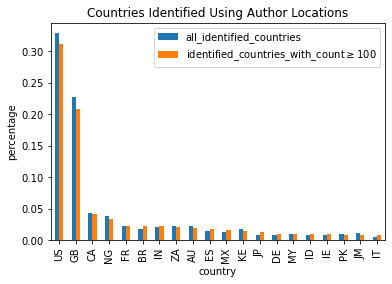

In [559]:
df_prec[:20].plot(kind='bar')
plt.ylabel('percentage')
plt.title('Countries Identified Using Author Locations')
plt.savefig('author_location.png')

# Summary
Out of 578,739 unique locations of 1,631,329 authors of English Tweets whose locations were available, we identified the countries for 38,617 locations which covers 885,376 authors (~54%). We manually verified the 1,311 locations that occurred more than 100 times and found that the frequencies of the identified countires for this subset roughly correspond to those of the countries for all author locations.